In [1]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout

Autosaving every 60 seconds


Exercise 8
===

Create a DQN to solve the "BipedalWalker-v2" gym.

In [2]:
import gym

env = gym.make("BipedalWalker-v2")
obs = env.reset()
print(obs)

[ 2.74753547e-03 -3.97763943e-06  3.09411753e-04 -1.59999728e-02
  9.20954794e-02 -4.08320135e-04  8.60192001e-01  1.70501120e-03
  1.00000000e+00  3.25022675e-02 -4.08291293e-04  8.53738576e-01
  2.88767701e-04  1.00000000e+00  4.40814018e-01  4.45820123e-01
  4.61422771e-01  4.89550203e-01  5.34102798e-01  6.02461040e-01
  7.09148884e-01  8.85931849e-01  1.00000000e+00  1.00000000e+00]


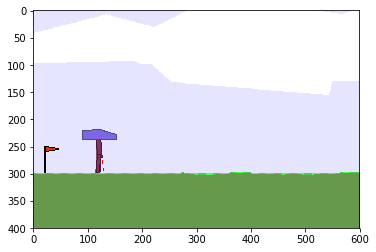

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

def render_env(env):
    plt.imshow(env.render(mode="rgb_array"))

render_env(env)

In [13]:
print(env.action_space)
print(env.action_space.shape)
print(env.action_space.low)
print(env.action_space.high)

Box(4,)
(4,)
[-1 -1 -1 -1]
[1 1 1 1]


In [5]:
from tensorflow.contrib.layers import fully_connected

neurons_per_layer = [50, 50]
n_outputs = env.action_space.shape[0]

def q_network(X_state, scope):
    current_layer = X_state
    layers = []
    with tf.variable_scope(scope) as scope:
        for neurons in neurons_per_layer:
            current_layer = fully_connected(current_layer, neurons)
        #print("input shape", current_layer.get_shape())
        # We use the tanh function because the output ranges from -1 to 1.
        outputs = fully_connected(current_layer, n_outputs, activation_fn=tf.nn.tanh)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name)]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [6]:
print(obs.shape)

(24,)


In [7]:
X_state = tf.placeholder(tf.float32, shape=[None, obs.shape[0]])
actor_q_values, actor_vars = q_network(X_state, "q_networks/actor")
critic_q_values, critic_vars = q_network(X_state, "q_networks/critic")

copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

In [14]:
X_action = tf.placeholder(tf.int32, shape=[None, env.action_space.shape[0]])
# This contains the Q-value for the actor's chosen action.
#q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs), axis=1, keep_dims=True)
q_value = critic_q_values

In [15]:
# The Actor's reward + future discounted estimated Q-value.
y = tf.placeholder(tf.float32, shape=[None, 1])
cost = tf.reduce_mean(tf.square(y - q_value))
global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [16]:
from collections import deque

replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memory(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1))


In [20]:
# epsilon greed algorithm to explore the state-action space of the environment at the beginning.
def epsilon_greedy(q_values, step):
    eps_min = 0.05 # At the start 5% of the time the actor will choose the greedy action.
    eps_max = 1.0 # Once it has finished exploring, the actor will choose the greedy action 100% of the time.
    eps_decay_steps = 50000
    
    epsilon = max(eps_min, eps_max - (eps_max - eps_min) * step / eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.uniform(env.action_space.low, env.action_space.high, size=n_outputs)
    else:
        return q_values.reshape(n_outputs)

In [ ]:
import os

def preprocess_observation(obs):
    # I don't think I need this method.
    return obs

n_steps = 100000
# Start training the critic DQN after 1000 game iterations.
# This has to be a lot bigger than the batch_size defined below.
training_start = 1000
training_interval = 3 # Run a training step every 3 game iterations start training_start.
save_steps = 50
copy_steps = 25 # Copy the critic to the actor every 25 training steps.
discount_rate = 0.95
batch_size = 50
iteration = 0
checkpoint_path = "./BipedalWalker-v2.ckpt"
done = True # Environment needs to be reset

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if done:
            obs = env.reset()
            state = preprocess_observation(obs)
        
        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        #print(q_values)
        action = epsilon_greedy(q_values, step)
        #print(action)
        
        #render_env(env)
        # Actor takes action
        obs, reward, done, info = env.step(action)
        print("reward", reward)
        if done:
            print("Agent died!")
        next_state = preprocess_observation(obs)
        
        # Memorise action.
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        if iteration < training_start or iteration % training_interval != 0:
            continue
        
        # Train the critic.
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memory(batch_size))
        next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        # Calculate the Actor's reward + future discounted estimated Q-value.
        #print("rewards", rewards.shape, "continues", continues.shape, "max_next_q_values", max_next_q_values.shape)
        y_val = rewards + continues * discount_rate * max_next_q_values
        #print(X_state, X_action, y)
        #print("X_state_val", X_state_val.shape, "X_action", X_action_val.shape, "y_val", y_val.shape)
        training_op.run(feed_dict={X_state: X_state_val,
                                  X_action: X_action_val,
                                  y: y_val})
        
        if step % copy_steps == 0:
            copy_critic_to_actor.run()
        
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

reward -0.08730362856952223
reward -0.04056842140737199
reward -0.15172792110704875
reward -0.16656893367787098
reward -0.22928336214121148
reward -0.06534465215815509
reward -0.08447360611234707
reward 0.030135598329714526
reward 0.10525816702521495
reward -0.2011417183150031
reward -0.2883044474347451
reward -0.17334886085145218
reward -0.1675839637027789
reward -0.1955822031881258
reward -0.13361895344739047
reward -0.19698536352146193
reward -0.1606133222254869
reward -0.32397051349720885
reward -0.35270164611735316
reward -0.23974692589524102
reward -0.2337731503729255
reward -0.13036675769234773
reward -0.13413805556187958
reward -0.09432769963395408
reward -0.0488556879019927
reward -0.055078132754205526
reward 0.004451617880846179
reward -0.04388498346538242
reward -0.013370241582787438
reward -0.06354550571674457
reward 0.001851939410916945
reward -0.009743316118480552
reward 0.033721347623836696
reward 0.036439891478849226
reward 0.08838938284804916
reward -0.0247358243204939

reward -0.10072757644250319
reward -0.1269814531458677
reward -0.03616630673733436
reward -0.19235405071395026
reward -0.1903274310904132
reward -0.20007633632960092
reward -0.22377337208951323
reward -0.1612126506892601
reward -0.13386975104587961
reward -0.10714182558357814
reward -0.020606862534732318
reward -0.011665384748492654
reward 0.0059931118879708745
reward -0.06620374326412648
reward -0.09260805118182658
reward -0.12374758209174037
reward -0.23439489229297833
reward -0.12238386516620822
reward -0.019957629491621956
reward -0.023664876644838975
reward -0.036145811076608886
reward 0.0024685881435307184
reward 0.06366244805000808
reward 0.0909999828449096
reward -0.08070404688529727
reward -0.04821159707206567
reward -0.03678920999509907
reward 0.014457273005685865
reward 0.07556003345010556
reward -0.03323379259712786
reward 0.010129930132256744
reward -0.10573009149564219
reward -0.07319805661940695
reward -0.10408009254175828
reward -0.08425837337384076
reward -0.0731298231

reward -0.1346629604164897
reward -0.03416843730941568
reward -0.07887596216538499
reward -0.1189941204535967
reward -0.029178156021199032
reward -0.2488252204512379
reward -0.09339243164418978
reward -0.10009456575228695
reward -0.010292613810766885
reward -0.11591441069182007
reward -0.1379889583826954
reward -0.05772330033124607
reward -0.04117735339168297
reward -0.07353636568115582
reward -0.01212216588345778
reward -0.045519550086114385
reward -0.01112945456333871
reward -0.026216551469627414
reward 0.05786751074851645
reward -0.01730374836063154
reward -0.056454441012592414
reward -0.16513402613481776
reward -0.08868246472982017
reward -0.09303648048897396
reward -0.170020858897139
reward -0.07867164194222302
reward -0.054295521185341464
reward -0.114868786693481
reward -0.1804630430229824
reward -0.10058390642929606
reward 0.01911712121872407
reward 0.037805776719270046
reward -0.042446562069720674
reward 0.015542504166453473
reward -0.06893026885838104
reward -0.02821560055803

reward -0.106224069107643
reward -0.10050123437976338
reward -0.08158761898294074
reward -0.0064407492568271
reward 0.03299724086376294
reward 0.004198682225234677
reward -0.022347775250773777
reward -0.07436114717363346
reward -0.05035955764230958
reward -0.029778159755244026
reward -0.03659538604956922
reward -0.0953295560886064
reward -0.12277322665178568
reward -0.14281127163939653
reward -0.17822138796959472
reward -0.11601472767086489
reward -0.07632780123352348
reward -0.1792886120009182
reward -0.03299261422391882
reward -0.04636068988837415
reward -0.06672222980501506
reward -0.03257078940407941
reward -0.016323665868926703
reward 0.05996095672259902
reward 0.004721949035593161
reward 0.08856629102306307
reward 0.0721042701816143
reward -0.0730786150055866
reward -0.004008496634722454
reward -0.09149536163430083
reward -0.1224086368112588
reward -0.2162074643864489
reward -0.19554560574228547
reward -0.31144358117305654
reward -0.4073598393421444
reward -0.10258437132209626
re

reward -0.07403428709322131
reward -0.010042121011741892
reward -0.038809242017745285
reward -0.10085184643357155
reward -0.03823074413078263
reward -0.0018929536509244057
reward -0.10329996834895136
reward -0.13179578916012563
reward -0.2511326076352831
reward -0.2308998455746335
reward -0.15975304742019691
reward -0.10099095204743919
reward -0.08060826115652872
reward -0.1257247987068202
reward -0.09656446595749991
reward -0.08065492576516779
reward -0.008316080252457326
reward -0.027271896944594934
reward -0.1365016604107312
reward -0.08295972613234005
reward -0.029828858716318282
reward -0.11220421818766149
reward -0.0414189385554005
reward -0.08198500579520226
reward 0.030928466287655672
reward -0.006384520299066613
reward -0.04702896423055879
reward 0.01215183798008003
reward -0.1100582917538121
reward 0.042959746000643215
reward 0.04151332671867652
reward -0.07647051756422776
reward 0.028676547882739153
reward 0.0531838905518835
reward -0.0023652794624240536
reward 0.04533744764

reward -0.23775884822269944
reward -0.11232322038181203
reward -0.03414774994446447
reward 0.019853919679433243
reward -0.043769524255538955
reward 0.0367407257545912
reward 0.058499491892185895
reward 0.08637947050802863
reward -0.00742750480454815
reward 0.004676418791583321
reward 0.01688479554036969
reward 0.007956372792742177
reward 0.026319838818362962
reward 0.05536310096253104
reward 0.035101210137197913
reward -0.01893480068657578
reward -0.019728919895498916
reward -0.04564408094773885
reward -0.1819992818774361
reward -0.10476182197778326
reward -0.13209435753161458
reward -0.15826092677531317
reward -0.15876599097218566
reward -0.19397043648366025
reward -0.11116603475492526
reward -0.13899102429790572
reward -0.1669106583782251
reward -0.19280637332910505
reward -0.0856472878059588
reward -0.033945156426685524
reward -0.11148707357313208
reward -0.02769433898035157
reward -0.10121054515944734
reward -0.09792080900239353
reward -0.05322692736462055
reward 0.0232869812584629

reward -0.11058278603988517
reward -0.035688559660766436
reward -0.04579094348425181
reward 0.003052403335231605
reward 0.040131625429302126
reward -0.087289147454076
reward -0.053694294737340095
reward -0.010497238793395865
reward -0.04765143743997689
reward -0.05780006889641517
reward -0.11999513979358131
reward -0.16308535599616167
reward -0.08629755313286867
reward -0.10388241396438307
reward -0.07806696003385317
reward -0.11309148306845536
reward -0.0875564874830069
reward -0.07119035542982195
reward -0.0475872669134499
reward -0.08250618956602031
reward -0.037758604909043106
reward -0.07612168118468753
reward -0.048995945197752105
reward -0.049098001774305275
reward -0.002225592771046111
reward -0.0942299883900674
reward -0.09214780466448352
reward -0.11633023819181777
reward 0.020593895043605627
reward -0.00650527607345976
reward -0.019118371217202862
reward -0.005699259706709099
reward -0.029977433122767308
reward -0.04276056855974769
reward -0.01815325501592817
reward -0.06841

reward -0.05846075493391251
reward -0.10049032656798486
reward -0.11296579455607014
reward 0.018932817959268447
reward -0.030176485364995224
reward 0.045204616258146715
reward 0.010075064782033762
reward 0.0432023296184178
reward 0.06388009621441397
reward -0.06338311560454207
reward 0.010532600587035708
reward 0.10120348544458806
reward -0.014257028564330669
reward 0.038223908096111314
reward -0.11412643496031935
reward 0.02758391569298373
reward -0.14814914381397698
reward -0.03619997431083749
reward -0.1220707567877388
reward -0.06317094502101096
reward -0.1601997090745385
reward 0.03224220536111948
reward 0.046030675089444036
reward 0.030985598395009598
reward 0.029004352904869267
reward 0.10246156752755192
reward 0.04830818567266332
reward -0.01874285212629239
reward -0.002069501040636742
reward -0.11176971951148791
reward -0.12472037590754229
reward 0.003089973264751014
reward 0.00887076879033466
reward 0.051044153613848044
reward 0.06797434892291392
reward 0.004465978407283867
r

reward -0.17976351699436693
reward -0.2162368642139492
reward -0.28426515454101164
reward -0.1509823085109773
reward -0.040129538734248765
reward -0.086745533693564
reward -0.07166784227041947
reward 0.025488169899989116
reward -0.057304778421179044
reward -0.10674368252646645
reward -0.050831652197936776
reward -0.12131088882093997
reward -0.15466340051602717
reward -0.06782985149721944
reward -0.09543326265557867
reward -0.12419931611555335
reward -0.15426466426226454
reward -0.16469550398920382
reward -0.16855388214496614
reward -0.16986160019109248
reward -0.13409346273300293
reward -0.1288727802702346
reward -0.20951251621742165
reward -0.1535558101998127
reward -0.26909835829701023
reward -0.26077499551623373
reward -0.2302232607171583
reward -0.25264958152218975
reward -0.27252052221116696
reward -0.15026749294056446
reward -0.21222170629496237
reward -0.15389503126893594
reward -0.14207629257730697
reward -0.09208339036898644
reward -0.16731678737016503
reward -0.18019079144390

reward -0.13652465668196598
reward -0.1993326929273243
reward -0.12891833866400876
reward -0.11338351962495433
reward -0.11556715184189303
reward -0.11471463169005255
reward -0.0667364722998692
reward -0.028323742827385458
reward 0.008990596992099607
reward 0.03942708618347798
reward 0.08219132189097204
reward -0.06957046467212596
reward -0.08567708814549006
reward -0.028455248045737784
reward -0.049728361605153315
reward -0.05033114700428101
reward -0.04959912985331715
reward -0.18450600512284032
reward -0.11626861854419869
reward 0.012060000331239556
reward 0.048742854910087854
reward -0.019336210542461006
reward -0.18559574344987184
reward -0.1813446389891397
reward -0.16496946212380242
reward -0.1455156815717469
reward -0.1912268991740775
reward -0.1612787211356547
reward -0.2290379275127483
reward -0.22541290257079435
reward -0.20285756376144168
reward -0.22491716101348963
reward -0.2261931087539925
reward -0.32458923423983427
reward -0.26988703953606596
reward -0.1524690722901361

reward -0.16343570532566518
reward -0.16106247534754536
reward -0.14788362972935679
reward -0.1001039009391795
reward -0.0989480524105293
reward -0.2998414398398648
reward -0.04828845385556574
reward -0.032870939995098866
reward -0.06457126167339507
reward -0.002247606310623651
reward 0.07709121302346411
reward 0.034890211352232886
reward 0.045001428479044314
reward -0.018198730802436572
reward 0.08483436250213557
reward 0.08742029000085583
reward -0.00020913636407909365
reward -0.102897218313942
reward -0.044169181873220824
reward -0.20863534211601362
reward -0.30307794174116365
reward -0.32441507152716087
reward -0.046280610822268656
reward -0.10391443806541564
reward -0.13818905787242408
reward -0.09207851801490614
reward -0.05447111150443279
reward 0.0017078966320609051
reward -0.08701740547111259
reward -0.05210453883032887
reward -0.07895070183693492
reward -0.14757045454960532
reward -0.006590690845594594
reward -0.006218643845424261
reward 0.09774075158287569
reward 0.114985430

reward -0.17890588536880728
reward -0.05683151278645392
reward -0.10210009637326897
reward -0.16828912621759853
reward -0.051852708908260096
reward -0.08579097087356237
reward -0.06044378162872721
reward 7.64523459294078e-05
reward -0.11438773976358795
reward -0.05928859167348029
reward -0.07544660357376522
reward -0.09763186877962964
reward -0.10541674116964964
reward -0.09300389327068878
reward -0.12280625315569493
reward -0.21090084425608083
reward -0.08189427405779966
reward -0.18423334138609415
reward -0.14743677912138675
reward -0.09952356682125306
reward -0.07311277063869409
reward -0.08987195321483575
reward -0.09414518711520413
reward -0.06562056935540424
reward -0.016411469889520313
reward -0.005879193746877485
reward -0.016925680142166562
reward -0.07410366620107905
reward -0.02875161618486241
reward -0.05801535924638569
reward -0.1384152267934703
reward 0.02112361256013722
reward -0.033718000062868625
reward 0.04604939410319904
reward -0.0505167739738199
reward -0.110664462

reward -0.0931353899538376
reward -0.08677810517436829
reward -0.13246411146543924
reward -0.05573717839991413
reward -0.14275766427918696
reward -0.048432600159186795
reward -0.08156078597125015
reward -0.04704937787646717
reward 0.004614536077209137
reward 0.08367233232474411
reward -0.04465087584766707
reward 0.06693026873968622
reward -0.03803477148334146
reward -0.04062295234810258
reward -0.09762346164533622
reward -0.007429663581236771
reward -0.06592689840063139
reward -0.07083765235747316
reward -0.08694157979750715
reward -0.065006332651188
reward 0.01631821932453754
reward -0.005829570704568623
reward -0.1493068587477045
reward -0.051883744349557816
reward -0.03385429623512622
reward -0.04924597606447982
reward 0.044016488461412095
reward -0.0211455615247881
reward 0.041108201062713054
reward -0.06911155926340717
reward -0.034052663640847046
reward -0.05560403881785343
reward 0.015501611767401858
reward -0.03995169951509467
reward -0.046329302929684436
reward -0.079888613087

reward 0.11537967835417731
reward 0.09136862735786802
reward 0.06979527933867521
reward 0.061987008134010854
reward 0.02921742694881088
reward -0.04697536943568047
reward 0.021669199095853083
reward 0.01810700297080553
reward 0.04466891679360824
reward -0.024003957707397043
reward -0.06485712056356158
reward -0.11702304753252082
reward -0.08168434216249618
reward -0.03698877809445039
reward -0.05968930639460249
reward -0.044629974416708795
reward -0.04600867944418463
reward -0.029890930279453547
reward -0.019717343365178278
reward -0.039334760740681415
reward -0.05241485645071414
reward -0.13802578675244542
reward -0.2001774805188179
reward -0.1860806299006895
reward -0.2185358353326492
reward -0.2264390307491389
reward -0.2923185186739853
reward -0.2987533386162832
reward -0.20219051336590277
reward -0.22513407631567298
reward -0.2167581478460585
reward -0.18715496495331213
reward -0.1039676758870205
reward -0.07493907598573603
reward -0.08097198359997133
reward 0.007747058520980113
r

reward -0.1365112717946323
reward -0.1438803405469548
reward -0.03707027194756973
reward 0.005554564652178316
reward -0.12171839945974082
reward -0.05683556212672605
reward -0.12362535908319586
reward 0.0038816524988192526
reward 0.05197819992153872
reward -0.06662095946157326
reward -0.026503309707838967
reward -0.07018361235343552
reward -0.061177114738878505
reward -0.16052847760915756
reward -0.13755217193406988
reward -0.1747034758105096
reward -0.11851386686123662
reward -0.09863939886655324
reward -0.1254371700051461
reward -0.1606731443839934
reward -0.16454895086656238
reward 0.02433754055739003
reward 0.0034530662802495955
reward 0.06649821359977118
reward 0.08823504147442122
reward -0.03512490555625779
reward -0.06138760033894987
reward -0.038886801680084786
reward -0.1271125199271897
reward 0.012995451067038682
reward -0.0652866821350027
reward -0.05987513083051231
reward -0.15968263656300039
reward -0.1883685745897833
reward -0.13749730604683374
reward -0.06183324915822133

reward -0.1136509987747815
reward -0.11252541504869552
reward -0.0431127342790149
reward 0.033937815909671515
reward 0.04770814815633974
reward 0.033805265391504025
reward -0.05005885416257256
reward -0.04842327225948414
reward -0.04400849861722816
reward -0.07921256484152506
reward -0.07205071846902572
reward -0.030784168513290477
reward -0.2483595277766363
reward -0.25920174782264593
reward -0.32036256005213604
reward -0.23003275032910395
reward -0.24555482539192605
reward -0.21184292353205572
reward -0.1861446530080903
reward -0.151508158307973
reward -0.12320496789229221
reward -0.13035628059815757
reward -0.10065652867778198
reward -0.03788363616620617
reward -0.06541583525728079
reward -0.09103174434826075
reward -0.12906505664304077
reward -0.02064325276398089
reward 0.0061304283322698334
reward 0.041440864419810416
reward -0.11018469289726225
reward -0.0447815564965812
reward -0.035501121659852336
reward 0.040947574902763864
reward -0.009649746682388266
reward 0.029968346787673

reward -0.009320976198113437
reward -0.013214377700605464
reward -0.06927247318663883
reward -0.05231160779240793
reward -0.1899083401682864
reward -0.2727291565805134
reward -0.30441733703692175
reward -0.30920794113989764
reward -0.04619077392573654
reward -0.14132919671516675
reward -0.09161186808498871
reward -0.0489012889536548
reward -0.04449019328702446
reward -0.06449789101446557
reward -0.07476167829951731
reward 0.04308370459539623
reward -0.059335203620986085
reward -0.03288159132218918
reward -0.0181687479580738
reward 0.05685122841669914
reward 0.07057945304361939
reward 0.011931762670788654
reward -0.0051528183035434
reward 0.028504425979573082
reward -0.0474975787558872
reward -0.004505913373604804
reward 0.08757850167483014
reward 0.057250603859354925
reward -0.04585728992549348
reward -0.030944830119719307
reward -0.022813064286167486
reward 0.03434288269672137
reward 0.03348528772629683
reward 0.0035373667045618257
reward 0.001116646644214827
reward -0.054100361916130

reward -0.09249866134170041
reward -0.027573947903284268
reward 0.02372718404130882
reward 0.02323506789664449
reward 0.03876093055507757
reward 0.0005514404515861901
reward -0.015188932226052812
reward -0.09566366386471854
reward -0.09034420159989735
reward -0.03874257486239141
reward -0.02484679945833341
reward -0.13951155854540054
reward -0.11511019935050643
reward -0.11215471711437376
reward -0.046390690472345376
reward -0.16626722344757677
reward -0.020187590964265683
reward 0.04794935764934805
reward -0.034590512220398814
reward -0.07678048937941094
reward 0.003720713379146791
reward -0.009095454522162556
reward 0.07370531884013745
reward 0.06839274661128904
reward -0.020195873980632016
reward -0.13571905987465693
reward -0.14615275453077364
reward -0.12206016580263893
reward -0.10642006775425242
reward 0.01956946075765046
reward 0.015469712451919356
reward 0.04982606461108831
reward -0.11022800026184734
reward 0.012076088730511626
reward -0.058520893670381165
reward -0.005493045

reward 0.07968493571620003
reward -0.0376919462575389
reward -0.06845611420810492
reward -0.10007014267266906
reward -0.16627896734901237
reward -0.21316969273141045
reward -0.137177507360297
reward -0.119284496267324
reward -0.1089715632979267
reward -0.0542300098185855
reward -0.012880260583407108
reward -0.18139763333816272
reward -0.057474672426620146
reward -0.030101430895784338
reward -0.0772945467905509
reward -0.05008905900732384
reward -0.03938660612403855
reward -0.2318677568655882
reward -0.19996893600589358
reward -0.14541234722402088
reward -0.047947539705454637
reward 0.003630385185858896
reward -0.09065007225551616
reward 0.01976023781047024
reward -0.053869630960151654
reward -0.03358464278781266
reward -0.04578416218865519
reward 0.029589411470269125
reward 0.009040860428966069
reward -0.007347569789252165
reward -8.729726646637681e-05
reward -0.009747169357277626
reward -0.1503687828344491
reward -0.13764278494891316
reward -0.18960877242274893
reward -0.0593812777428

reward -0.040353084947025
reward -0.028854976786032
reward 0.03609452494562795
reward -0.06228953400702923
reward -0.09481368641367889
reward -0.06657727967059958
reward -0.12020872180254728
reward -0.17277956001992936
reward -0.1326068595141119
reward -0.18113630633436106
reward -0.11671563930333732
reward -0.12591279210408468
reward -0.09352635336261583
reward -0.12680734737679403
reward -0.11338574686503328
reward -0.11786492304884398
reward -0.15460177691777788
reward -0.20337885805979278
reward -0.21799113539549372
reward -0.18976635768171668
reward -0.18284157997166434
reward -0.06210740670937259
reward -0.045248949437285774
reward -0.12723481342330575
reward -0.11367278986666504
reward -0.11095966895480266
reward 0.02346002356985582
reward 0.155571819759495
reward 0.2183073643232266
reward 0.1671182086467743
reward 0.24232041683624356
reward 0.2849536737097337
reward 0.34779557276839157
reward 0.30862884136758156
reward 0.2280109601553556
reward 0.19162234647495272
reward 0.2653

reward 0.06328853961335756
reward 0.10270182452256506
reward -0.03207584612447321
reward 0.024991644767040105
reward 0.052070391169960206
reward 0.11957970301555902
reward 0.10477267218194466
reward -0.09952891756981191
reward -0.14609974228651432
reward -0.052858574320875
reward 0.08518107619336034
reward 0.06963576318763429
reward 0.11218538746288283
reward 0.023286294447614035
reward -0.0066122013401579945
reward -0.04140614079191116
reward 0.050831024511343546
reward 0.0553672973124296
reward 0.12314648054663076
reward 0.082247072728195
reward 0.039110882462786205
reward 0.130178003828672
reward 0.027895979339655937
reward 0.060834946899562786
reward 0.043683692721476305
reward 0.02286252666415056
reward -0.03548351167501633
reward -0.047787449174965815
reward -0.008411667564153244
reward -0.0343492218250913
reward -0.038592682680634316
reward -0.04604919183818452
reward 0.022368786597473166
reward -0.023024277151520386
reward -0.02992956536558089
reward 0.09736587532361232
reward 

reward -0.10024377226038461
reward -0.1469811480343342
reward 0.01747341624276902
reward -0.03747830213147602
reward -0.12845970660285158
reward -0.12628864349132354
reward -0.16072681353638146
reward -0.030624644571711813
reward -0.006985102354547773
reward 0.05194879799049174
reward 0.05708519433832237
reward -0.1624149996671173
reward -0.10791901229177327
reward -0.07699746898564792
reward -0.05756626927836278
reward -0.17580973030130187
reward -0.13989292368865922
reward -0.12511026819120194
reward -0.03602655525238261
reward -0.007615912633203737
reward 0.012411017761531112
reward 0.07177527957898155
reward 0.030503730051026086
reward 0.05467471213309504
reward -0.05736312894654346
reward -0.13588226736541162
reward -0.18927806659498728
reward -0.2240989899827868
reward -0.21617688028798848
reward -0.18828531518801336
reward -0.13287572914870072
reward -0.19947395913598753
reward -0.2343365061794994
reward -0.08792554748694052
reward -0.05521013579567365
reward -0.1167753618651065

reward 0.04543196145279177
reward 0.00028388652326512276
reward -0.10382214185305526
reward -0.24105071507110434
reward -0.23334983061421843
reward -0.05425521581800561
reward -0.11097963103236326
reward -0.0868972519844259
reward -0.06435315201170476
reward -0.002433035060330156
reward -0.07351687187124445
reward -0.08172717243798211
reward -0.034767939868854084
reward -0.023418154020306385
reward 0.09045820367778815
reward 0.04017890378419152
reward -0.003111309096050136
reward -0.22366116505388633
reward -0.2150484962374296
reward -0.17009437933246818
reward -0.09450974143328898
reward 0.00876441707776631
reward -0.13953428020918274
reward -0.078674693654646
reward 0.0012322748332081728
reward 0.0049002927169725236
reward -0.04796375283222755
reward 0.01961172026955265
reward 0.0978106818017671
reward 0.01654789894043757
reward 0.027714291685636407
reward 0.034550660933124755
reward -0.06420661895519174
reward -0.10240577686155976
reward -0.15069389437792874
reward -0.09680613164467

reward -0.027499099656099563
reward -0.08095570132271673
reward -0.01168266953700599
reward -0.12750232020784685
reward -0.07024255933863943
reward 0.03375933324519004
reward -0.0015653644349894608
reward -0.06520749509937399
reward -0.23879495147864144
reward -0.12913493975757517
reward -0.10652632451830758
reward -0.058890148305187795
reward -0.07439818221501585
reward -0.024500275857248118
reward -0.08948071542093035
reward -0.13176175558567046
reward -0.024757280181230426
reward -0.026541366445271962
reward 0.024847869327349375
reward -0.0314665532740392
reward -0.06750220522355627
reward 0.04844415547568995
reward 0.07776704588981243
reward 0.13413291304659178
reward 0.020166673108779856
reward -0.14274577667257202
reward -0.16013363098197012
reward -0.25950186513543605
reward -0.2810431449710867
reward -0.3002189129646697
reward -0.16189806071304239
reward -0.07689585701729346
reward -0.10475335055148842
reward -0.03740553033971572
reward -0.07391635413953616
reward -0.0678961747

reward -0.0020357965988381916
reward 0.04115702203638988
reward 0.05542676419159717
reward 0.10111170795395719
reward 0.08529050277777143
reward 0.1447754155748813
reward 0.007737776692603223
reward -0.042776446289461124
reward 0.03864850194822301
reward -0.028771501334648023
reward -0.02331387869707046
reward -0.06686311284841905
reward -0.19830234936667346
reward -0.30829208229357596
reward -0.2185895894637931
reward -0.3167164027985862
reward -0.2262143473625183
reward -0.1377435338389564
reward -0.0618464193416044
reward -0.11321464386852319
reward -0.04760509682024655
reward 0.026349822091364127
reward -0.08455234787053902
reward -0.09372678875793825
reward -0.07061037352852557
reward -0.12001872573430487
reward -0.1024997961753126
reward -0.019694358754240044
reward -0.012715472671840877
reward -0.0037341230388407178
reward -0.17908141501475391
reward -0.052085636715009764
reward 0.02048984573039527
reward -0.11084130098131903
reward -0.11737453140500895
reward -0.116990926285989

reward -0.04707646547672926
reward -0.09299186913541056
reward -0.06648668340690522
reward -0.16806385771433274
reward -0.065988237499584
reward -0.13606528236415594
reward -0.07774007788650109
reward -0.05776743157938078
reward 0.027263494275820543
reward -0.10879268560826205
reward -0.016270816067445848
reward 0.047563814945087046
reward -0.03495290768874104
reward -0.06842682461025112
reward -0.08496458558872032
reward 0.025794939374555195
reward 0.038880906123263094
reward 0.002259095541473851
reward -0.02395655915446996
reward -0.13271810037067228
reward -0.3074284515380859
reward -0.3398373339229038
reward -0.29261043264490366
reward -0.14913913251786393
reward -0.10275565781487736
reward -0.0489243702257017
reward 0.019840400687116202
reward -0.03478209063855966
reward -0.054103837030134924
reward -0.04340887854889389
reward -0.051420700883845386
reward 0.024248527917651932
reward 0.01548691047634018
reward -0.14595647349862742
reward -0.025322866279779893
reward 0.0342892098793

reward -0.20514508614492816
reward -0.1972867418132964
reward -0.18412804762592158
reward -0.22455444496204965
reward -0.18952354627881957
reward -0.12740391794010988
reward -0.07661665804509357
reward -0.10424893311210225
reward -0.02336696871243042
reward -0.06988182203065446
reward -0.06999373418817562
reward -0.09938970149733754
reward -0.01797276215770883
reward -0.05152616897475202
reward 0.028094033895909875
reward 0.025761117247397988
reward -0.06204122518718235
reward 0.0423012436916581
reward 0.16001834464084438
reward 0.19817688860809815
reward 0.09458539200745325
reward 0.09189074441036744
reward -0.08787636801400958
reward -0.05322539780881226
reward 0.010912077777138018
reward -0.23962222487998047
reward -0.19519004723049846
reward -0.22222414920269798
reward -0.20514580779685224
reward -0.11493921895217231
reward -0.07993945039525738
reward -0.001965624289299108
reward -0.11459375069266109
reward -0.13655441491494064
reward -0.1511785150174552
reward -0.23068475683530054

reward -0.0621097818652883
reward -0.00891647081036098
reward -0.02269256958926139
reward -0.11761589681650142
reward -0.10264256242384763
reward -0.011649201028011152
reward 0.057054903217131824
reward -0.024283669444429137
reward -0.021354835673358784
reward 0.08310451273000934
reward 0.1495015641843869
reward 0.13598138552647665
reward 0.03623920329772988
reward 0.03849555178397795
reward 0.08881764371784553
reward -0.01885231184347184
reward -0.003880990610353033
reward 0.036908677537003554
reward -0.01845910147980031
reward 0.006619549399938033
reward 0.06527378869151469
reward -0.09006885718279449
reward -0.2261485083202511
reward -0.2113260290090055
reward -0.18176668735584361
reward -0.27849068145852446
reward -0.2701769488643515
reward -0.033231191105364655
reward -0.02484137478439118
reward -0.04420475605588427
reward -0.08500770265626811
reward -0.07774098859239752
reward 0.012535502154885112
reward -0.0178960381324132
reward 0.08609123075239358
reward 0.041899945317952124
r

reward -0.09298231998142821
reward -0.2078785082499198
reward -0.1162781588385098
reward 0.011527277151140245
reward 0.07631935804503939
reward -0.0024988242180213442
reward 0.06454583906477208
reward -0.06817781933148584
reward 0.009664914154375722
reward 0.040159939002067144
reward -0.005314856094274428
reward 0.08704032659060632
reward 0.10419740620387748
reward 0.07534759544704427
reward 0.16523103794338787
reward -0.04048641704089099
reward -0.10809699278460663
reward -0.17675005620718004
reward -0.23138136573709897
reward -0.252291755370197
reward -0.1821176121234894
reward -0.0802964307597144
reward -0.018593695390620363
reward -0.036919410495350496
reward 0.012469470247423191
reward -0.007637510010555827
reward -0.022059890126391868
reward 0.017658523931452914
reward -0.029525132295147402
reward -0.1717139479670885
reward -0.21263792446573582
reward -0.09665144305019419
reward -0.027748638473471803
reward 0.0017861153281621064
reward 0.021015141906853038
reward 0.00677301946292

reward -0.09232673306843964
reward -0.06574935276211284
reward -0.12190304927031673
reward -0.040600740626067444
reward -0.02123855407876029
reward -0.051232463579614126
reward -0.10577296300251456
reward -0.06425470368570158
reward 0.06942869364530385
reward 0.16656231000960733
reward 0.048104159061248
reward 0.06191856176286427
reward 0.054039602710363344
reward 0.012371335900499335
reward 0.020325250344774046
reward -0.058534957343128816
reward -0.2839589188346111
reward -0.2578522793236844
reward -0.09620163312145956
reward -0.12985152964720884
reward -0.17289531020323198
reward -0.05401506319817213
reward -0.04302814978493367
reward 0.04609391852083761
reward -0.04769224361758804
reward -0.026903434692542243
reward -0.08712436344036074
reward -0.11624091838142768
reward -0.07448791152787128
reward -0.04684889968382261
reward -0.09031139100809482
reward -0.12461689603227333
reward -0.12726100535783993
reward -0.05103167165653962
reward -0.018508156279007135
reward -0.06126694956818

reward -0.01736681962144649
reward -0.02869839804726454
reward 0.03786473959944249
reward 0.06460688467429465
reward -0.10387916113043566
reward -0.13706501482728373
reward -0.2638115145762785
reward -0.10514661397345446
reward -0.048640817668458375
reward -0.16302775902686817
reward -0.0982376189016106
reward -0.09956681095894059
reward -0.14195614948034263
reward -0.08048889179832887
reward 0.016320394316004978
reward 0.02437634210997872
reward -0.09325556554328751
reward -0.15914379130784034
reward -0.09307915278720313
reward -0.0349843995590115
reward 0.022093444110013634
reward 0.054152584852301386
reward 0.031422683691570544
reward -0.08362901485753167
reward -0.037446818202991346
reward -0.19832267713546753
reward -0.09407065738883905
reward -0.08082473228716947
reward -0.08844295793339929
reward -0.101492830807001
reward -0.11408838982518
reward -0.023620470503925666
reward 0.11086277893942653
reward -0.0006953751108397955
reward -0.11006907277527159
reward -0.25774543082714085

reward -0.1970688855498508
reward -0.23411116723273953
reward -0.17434271713976304
reward -0.08170635080305771
reward -0.036371213160086534
reward -0.06087856514868987
reward -0.07062657824119314
reward -0.12987254850069802
reward 0.006533728752851499
reward 0.006792931080467189
reward -0.09614910312474728
reward -0.17272281559308253
reward -0.17271713776056158
reward -0.0514784466761967
reward -0.02126265108992889
reward -0.05924191613236619
reward -0.002771604256292342
reward 0.016822278450272385
reward -0.08018807156880578
reward -0.14821046959243325
reward -0.07226230119297809
reward -0.06843243589949127
reward -0.06389986191545725
reward -0.022213473855036893
reward 0.06405191072926494
reward 0.10298708783429639
reward 0.15820394509691368
reward 0.17643725103198812
reward 0.22352791495558552
reward 0.2741960571314041
reward 0.22118855253751213
reward 0.3262766340133295
reward 0.3516826558801008
reward 0.41413034855413855
reward 0.3156937291170283
reward 0.3054540100106695
reward 0

reward 0.054805255661069745
reward 0.07458058847925347
reward 0.11543139358699837
reward 0.05330804962967382
reward 0.04774455026461492
reward 0.07030729988224979
reward 0.10032977171861866
reward -0.0026057972764765742
reward 0.004363470947105317
reward 0.005106096522052992
reward 0.0324096217354121
reward 0.06536507895076898
reward 0.11217316538212617
reward 0.053237236008744415
reward 0.12432295366536555
reward 0.08271901010083241
reward 0.02758049376805504
reward 0.1314353492577218
reward 0.11057820597270378
reward 0.17490626299865134
reward 0.13545752641129244
reward 0.15976211480086586
reward 0.13090270806184118
reward 0.05988598489151885
reward -0.06498421502113343
reward 0.1353262479511792
reward -0.05117297221279493
reward 0.07630762994634181
reward 0.10815422799145956
reward 0.027870868687635823
reward 0.11129487513410063
reward 0.02417153132878856
reward -0.012505845975173159
reward 0.012615951961985132
reward -0.04497642770361074
reward -0.13181574920641523
reward -0.076279

reward -0.18837411136198806
reward -0.09985783695358975
reward -0.037016614577900286
reward -0.010480135919107118
reward -0.15317510019773484
reward -0.11445045508838153
reward -0.052819926839833393
reward -0.14019612480222488
reward -0.08837103351129277
reward -0.06969624895232356
reward -0.09545006861163137
reward -0.00742904287659835
reward 0.05661191195890736
reward -0.02501487163188557
reward 0.009761718179945644
reward -0.13379310078861878
reward 0.05752775645320066
reward -0.034073302365379934
reward -0.04497967991003582
reward -0.09460853338181478
reward 0.04618508805488687
reward 0.017915964813574655
reward 0.07642576711483354
reward 0.03215550495862567
reward 0.08830292447521089
reward -0.12918868976831435
reward -0.3134034789601974
reward -0.22942913871282297
reward -0.11329682954928846
reward -0.11990315437857749
reward -0.12782391578545477
reward -0.02004371676116904
reward -0.1354078512986489
reward -0.1903578061993737
reward -0.09325755984248185
reward -0.160619018285265

reward 0.04669779594089524
reward 0.044650210126375246
reward -0.08748835882864989
reward -0.027717949057816528
reward -0.03297167474679451
reward -0.11489606271215178
reward -0.004139361557315185
reward -0.0017804328724752225
reward -0.11774322490175021
reward -0.09408233768541353
reward -0.055396269620092836
reward -0.06022329900900305
reward -0.05212687273988407
reward -0.02687505660125819
reward -0.04575489262659403
reward -0.06039333221927503
reward -0.06780869538204917
reward -0.09693422755862462
reward -0.08509002541123728
reward -0.05159120304702035
reward -0.014508425935770458
reward 0.09196018504262517
reward 0.008769443346416961
reward -0.04854287690906732
reward -0.05311662466001127
reward -0.03238963679559227
reward -0.04623257559655217
reward -0.10733485235222452
reward -0.15738027968506665
reward -0.10622664762703785
reward 0.022182484154960973
reward 0.010881943743946357
reward -0.003886383519524403
reward -0.06382923229194079
reward -0.05677040908855625
reward -0.02508

reward -0.0507567191555498
reward -0.05308532332528438
reward -0.04292974627945529
reward -0.10991711205939228
reward -0.17920467656203548
reward -0.07449929567481135
reward -0.144025360782069
reward -0.15713408880301388
reward -0.13542112914409937
reward -0.049364322146959586
reward 0.009050488301674493
reward -0.05232288777560765
reward -0.04570653809054733
reward -0.2260367864569052
reward -0.19718824301067195
reward -0.14867673560762276
reward -0.23155697755018986
reward -0.11082035968468004
reward -0.04414348645520906
reward 0.02525997687487389
reward -0.09433727820416199
reward -0.16378389390309533
reward -0.09854505329878147
reward -0.08938293546126805
reward -0.03926362266726405
reward -0.010335251538037878
reward -0.04129078811235583
reward -0.0060199355466439945
reward 0.005991485380806474
reward 0.04565104575910815
reward 0.007110971551536022
reward 0.017960736059262565
reward 0.025367051974160348
reward 0.08465475118061722
reward 0.06855372736777399
reward -0.00079036482175

reward -0.0790899792974745
reward -0.03114244744514404
reward -0.06016148826130949
reward -0.10016061166666168
reward -0.08601475454061068
reward -0.06624422491176707
reward -0.1827997482419014
reward -0.09893492129622194
reward -0.027521048369931453
reward -0.021987413424415788
reward 0.01915905693646335
reward -0.12822670672959632
reward -0.13501630836725234
reward -0.06365826818101197
reward -0.06917469324755067
reward 0.022512758545059006
reward -0.005484322396402206
reward -0.019119401312068414
reward -0.09577104451677412
reward -0.18647551342615093
reward -0.10439882277624933
reward -0.06381527397703719
reward -0.03476770063144294
reward 0.06373221872427773
reward -0.07711455070262366
reward -0.027339395484935306
reward 6.535258770317721e-05
reward 0.049038622299931466
reward 0.07244856999641419
reward 0.011100857544148596
reward -0.1830913386219262
reward -0.1182930546616547
reward -0.3172563337087631
reward -0.30348014706825455
reward -0.10557519171713223
reward -0.126283619343

reward 0.05182898517124103
reward 0.02709802893880471
reward 0.04301683049944064
reward 0.16229606601440913
reward 0.09887018025995044
reward 0.0899443090440653
reward -0.0438635577758177
reward -0.004830130731502576
reward 0.03332288515229616
reward -0.06545670227209846
reward 0.086895383713699
reward 0.15839030122158537
reward -0.01793074689706626
reward 0.010583037633103184
reward 0.08025801956996229
reward 0.03598999129441111
reward 0.10037462027347323
reward 0.15227392363230613
reward 0.2226609955329754
reward 0.20330053021881062
reward 0.11231948494203876
reward 0.07469300601225923
reward 0.10430559389517259
reward 0.09835368851496129
reward 0.11275907221605762
reward 0.03100637302701149
reward -0.02653181410734754
reward -0.051473079436599935
reward -0.0592688110391278
reward -0.05730479957318527
reward -0.09748192410051593
reward -0.07302539793004108
reward -0.09184400887177288
reward -0.11184520126500597
reward 0.033923352359745085
reward -0.04301689411172989
reward -0.0354194

reward -0.07243518253167353
reward 0.0438632470878251
reward -0.10880267492930212
reward -0.028476932515798043
reward -0.10412331731392664
reward -0.035106762133833916
reward -0.0025472019622885395
reward -0.04273075338927674
reward -0.06356830046367418
reward 0.021868246607168428
reward 0.06999528973877628
reward -0.017036126654421908
reward -0.15343033878008644
reward -0.008842432584720249
reward -0.06849552588318761
reward -0.09232126438480448
reward -0.06270240674733159
reward 0.05100946930693638
reward 0.08371590795706811
reward 0.057377734394273565
reward 0.14248088997155242
reward 0.04845280326437831
reward -0.0490561938141684
reward -0.05943184203134107
reward -0.07050982323785063
reward -0.1399203985780738
reward -0.12349266648405932
reward -0.029825253425934277
reward -0.03819386438405568
reward -0.07108440101694652
reward -0.08784145601593943
reward -0.062261031732898896
reward -0.21022000127233945
reward -0.14785963953466555
reward -0.09319601599741943
reward -0.13983082890

reward -0.23899736515805034
reward -0.17689265137583615
reward -0.23449013056160928
reward -0.15500946537100146
reward -0.12337836556654587
reward -0.10071556019964988
reward -0.20831335856561434
reward -0.08864379630268414
reward -0.1943424313698227
reward -0.09299759142030407
reward -0.047545183683442425
reward -0.04355180711407344
reward 0.029114109743389394
reward 0.029679675859332975
reward 0.0288059045427302
reward -0.1733230104626533
reward -0.08653109427034986
reward -0.08702864969068105
reward -0.112883637477152
reward -0.09130781110923325
reward -0.09924408276937666
reward -0.052954379642958245
reward -0.05525497802175386
reward -0.020181268731595006
reward 0.02388909634210397
reward -0.06623023365909601
reward -0.028806708902937316
reward -0.04097574854475804
reward 0.0700427408907636
reward 0.047887686457194115
reward 0.07106181722917644
reward 0.06526554747793695
reward -0.02927386017733786
reward 0.012895506729353788
reward -0.04753163225946239
reward -0.04285362749670083

reward -0.21076587210350164
reward -0.18036173241196204
reward -0.24408319076484528
reward -0.23150262057781218
reward -0.18083666062260229
reward -0.21434292300542077
reward -0.19523994676272194
reward -0.16456175424810476
reward -0.12102645896481072
reward -0.16837203307429385
reward -0.10712716015143477
reward -0.18035991403485377
reward -0.2326173189228743
reward -0.17250847258308954
reward -0.17999266557208526
reward -0.15615053977209667
reward -0.2320626009441307
reward -0.19714315589459452
reward -0.31721714092318726
reward -0.32761793993229604
reward -0.1989715610001435
reward -0.2620055965021735
reward -0.16936026530547307
reward -0.2319213450292936
reward -0.18739466473848887
reward -0.14114199216840362
reward -0.20429885914893936
reward -0.20128052134185234
reward -0.1759518890890975
reward -0.23529556561505088
reward -0.2373492590305756
reward -0.3424355301062278
reward -0.30241528942262597
reward -0.3033588063593527
reward -0.3660879762692589
reward -0.2812849858194901
rew

reward 0.11419855899919118
reward -0.021519993676875553
reward 0.09730459095160904
reward 0.03440674852580013
reward -0.04026493569985028
reward 0.06534447870981736
reward -0.07683667686594528
reward 0.06572212360721436
reward 0.10440781624230072
reward -0.012789684783992776
reward 0.04022991441194257
reward -0.10494250782330712
reward -0.037371378869060626
reward 0.012520843303354217
reward -0.09074062307675916
reward -0.09998332073271539
reward -0.043271257081570036
reward -0.0050701745442068135
reward -0.0656034757129963
reward -0.03193598634884522
reward -0.046505391828421734
reward -0.10671878137387014
reward -0.14566375615304158
reward -0.2575014135042838
reward -0.06626234744212323
reward -0.06433304438166518
reward -0.12835855819325556
reward -0.1682909128401194
reward -0.1100843350596532
reward -0.19953191977196594
reward -0.3124909949302674
reward -0.20796338823447638
reward -0.17587742171953863
reward -0.23290405416818896
reward -0.2737939770233092
reward -0.2428655614707257

reward 0.05705499237746525
reward -0.08569654381275177
reward -0.05715741318502132
reward -0.08679477557584382
reward -0.08747957501658919
reward -0.06894762376946725
reward -0.1651821012794668
reward -0.11345652955448772
reward -0.23672626210956932
reward -0.13984041146261622
reward -0.10982409156382543
reward -0.09673966500068162
reward -0.1094450824370508
reward -0.18629591096808837
reward -0.23149181869381574
reward -0.2598171538294185
reward -0.23429942324837233
reward -0.22602175794246682
reward -0.2639496351417634
reward -0.20257924111448747
reward -0.13844523245975174
reward -0.13163423678281058
reward -0.21416782655516775
reward -0.12172597435368146
reward -0.06906381012632834
reward -0.06722726076492638
reward -0.1395014251247107
reward -0.17650939061936752
reward -0.16271811622611562
reward -0.10473128878446089
reward -0.059583062394673716
reward 0.004284244721073702
reward 0.04019251586148739
reward -0.015215283053623295
reward -0.013672052730273967
reward -0.02439626428465

reward -0.02716532501195849
reward -0.11697580436590352
reward -0.20885337336858173
reward -0.021034123171151504
reward -0.08467120645002339
reward -0.037580241195150826
reward -0.11843189134200473
reward -0.09658889568429459
reward -0.14625033194690518
reward -0.047299346515540824
reward -0.015311545168167337
reward 0.03922913242260645
reward 0.03409647418104585
reward -0.014147714990620288
reward -0.0174861085631771
reward -0.09229214795430563
reward -0.093947925238425
reward 0.01753394349213194
reward -0.07246543716590224
reward -0.1134915424183158
reward -0.15092049139702973
reward -0.1094700419095751
reward -0.05477082175733555
reward 0.05258035947676798
reward -0.058834166149297755
reward 0.002754367620980213
reward 0.06003369092460897
reward 0.05740285429998121
reward 0.05518038408304092
reward 0.0004209019648474324
reward 0.08682627669434244
reward 0.10042934078119992
reward 0.058291764626954776
reward 0.03509411208964949
reward -0.015189713589934123
reward -0.10341986745489758

reward 0.13569768870897103
reward 0.17133293814444162
reward 0.16671827402751227
reward 0.18475020358478825
reward 0.21671343719533329
reward 0.1799389951810967
reward 0.2840603493334089
reward 0.1536154755353928
reward 0.21048329546869762
reward 0.25373014085979123
reward 0.24705513708666094
reward 0.2102239007041947
reward 0.2910587277036073
reward 0.27421143340143533
reward 0.25317082209050346
reward 0.2901128198199632
reward 0.33312659995412836
reward 0.35042803939290357
reward 0.3373854005569104
reward 0.41972651656209303
reward 0.3634483136409516
reward 0.4002589729154547
reward 0.34962514024273456
reward 0.29459627824150697
reward 0.35027561580908284
reward 0.39549821269979785
reward 0.3714420598626545
reward 0.4174876644361719
reward 0.4405079788118029
reward 0.12967345040000752
reward -0.10692261053900479
reward -0.05792224739121277
reward -0.14478685558789695
reward -0.22226583081570156
reward -0.19167298401992366
reward -0.23377786255340677
reward -0.10083302288382957
reward

reward 0.03160460485050446
reward -0.003169392125114589
reward 0.08021049599545274
reward 0.15178370397177904
reward 0.12054227519330835
reward 0.12252274555631881
reward 0.01898897214730461
reward 0.015828846949716473
reward -0.009642923736627054
reward -0.018610638436221336
reward -0.1481472022533417
reward -0.02460932371989274
reward -0.15802898931503295
reward -0.0663086338992023
reward -0.13211322218580498
reward -0.2300150851408617
reward -0.03608025468846994
reward -0.04726309810613947
reward -0.10117189469606641
reward -0.06822519514346938
reward -0.08512361396774207
reward -0.052094526733248984
reward 0.04163021231402031
reward -0.09121058309355541
reward -0.04111254384856409
reward -0.05134926324100441
reward -0.08606718548467442
reward -0.03777661188470446
reward -0.003010735914779055
reward -0.04568963602290794
reward -0.01743206646215841
reward -0.04488945149529518
reward -0.15455789180596552
reward -0.04508628122733288
reward -0.11149246942479497
reward -0.035938545065781

reward -0.07493910359385854
reward -0.19127860202391822
reward -0.2590393529079088
reward -0.2268921854926539
reward -0.22383583988227174
reward -0.289849604845047
reward -0.14408185656733413
reward -0.11448151782787624
reward -0.04551286012034544
reward -0.12037782584543921
reward -0.12613791004164032
reward -0.15917065341305942
reward -0.12257906700851176
reward -0.08125081176231377
reward -0.07165273654450842
reward -0.0668605979738136
reward -0.14602420377365455
reward -0.2646900442441293
reward -0.18647959910544523
reward -0.13890397436048507
reward -0.09731124046323747
reward -0.09827295998817334
reward -0.1014846634471015
reward -0.10690057374289046
reward 0.02122867107874127
reward -0.009110678512807868
reward -0.06228871081968965
reward -0.12910467095815473
reward -0.12013008782042933
reward -0.016917695139226797
reward -0.02149173550763747
reward -0.050893248482162916
reward -0.15957815519695334
reward -0.05011009328511047
reward 0.03562018276532898
reward -0.0976832262100849

reward 0.21447272144865245
reward 0.23202386428612135
reward 0.2751481229722654
reward 0.15049500595858908
reward 0.17713923552558697
reward 0.1693127313896132
reward 0.1712150769741206
reward 0.10555910368760664
reward 0.10358389482788712
reward 0.14865680303310724
reward 0.11574117890993872
reward 0.17906139972769833
reward 0.2190463017012882
reward 0.25424786327513516
reward 0.2744854398626098
reward 0.19839622326255368
reward 0.13347365599040442
reward 0.11165231229260922
reward 0.2282613504234715
reward 0.23774140445653177
reward 0.2543818734119858
reward 0.24540389609211116
reward 0.23528067664313224
reward 0.3001219341753606
reward 0.29775578571808364
reward 0.3096014296346625
reward 0.168755204684149
reward 0.19188358133037767
reward 0.20833953262923266
reward 0.010580253117853699
reward -0.06833704542862154
reward -0.22716104684828836
reward -0.0952393862759375
reward -0.13416648683843496
reward -0.23546276516730158
reward -0.17414331360658247
reward -0.06377082938323346
rewar

reward -0.09196578241959315
reward 0.029094163380759992
reward -0.0754789986439196
reward -0.03201861387889935
reward -0.011079427898282406
reward -0.1265993526301414
reward -0.042659610993563954
reward -0.10020993582407398
reward -0.07205967154568199
reward -0.04557750474426385
reward 0.050486310139015264
reward 0.09568719575734849
reward 0.0767485743476852
reward 0.12203476614170684
reward 0.13207788335158546
reward 0.13935878070121957
reward 0.1531020191784787
reward 0.1487495113093486
reward 0.14659368846227205
reward 0.18826726164922586
reward 0.14258293229907726
reward 0.0477012182820961
reward 0.10491328825796332
reward -0.0331482846736908
reward 0.11513252907968288
reward 0.22530464382643361
reward 0.22678853399057947
reward 0.2807183157044001
reward 0.17801637725035466
reward 0.08177608206221604
reward 0.04432391882766545
reward 0.07272900976450124
reward 0.07596238482772476
reward 0.013184602038887078
reward -0.10960539246313669
reward -0.04910038765271742
reward -0.007109734

reward -0.08921360226181124
reward -0.12230511743612742
reward -0.058296922449454905
reward -0.04295810215508828
reward -0.17534214107195656
reward -0.08481932658051539
reward -0.08800669064469546
reward -0.16009124505009156
reward -0.18362221662203587
reward -0.17307361133893212
reward -0.2103059050268403
reward -0.267275336924129
reward -0.2106868439141851
reward -0.1552909231226128
reward -0.1783940041722652
reward -0.19198916641783298
reward -0.24635857013289678
reward -0.29454391384124756
reward -0.22790652915293869
reward -0.21350498126449127
reward -0.244665816148121
reward -0.14683955386355643
reward -0.14450878013450336
reward -0.1540000710487366
reward -0.09424125354687458
reward -0.10523751081291763
reward -0.04244925769808201
reward -0.11219587180351094
reward -0.08393715570001674
reward -0.14240522952459037
reward -0.05460495781045442
reward 0.010046703334982008
reward -0.11125573014209075
reward -0.00570700938027675
reward 0.05809770742921806
reward 0.04867189689628394
re

reward -0.08350714320071226
reward -0.07962271481247746
reward -0.06881222820637632
reward -0.025862014836405114
reward -0.04916059018163202
reward -0.16516121346558785
reward -0.14014915557300467
reward -0.22131248186131175
reward -0.2776755185346664
reward -0.29899353510848775
reward -0.2637520840020072
reward -0.20393266935331597
reward -0.18300289944516093
reward -0.23050430742899697
reward -0.14064873635656847
reward -0.06019691249962234
reward -0.07011104603888363
reward -0.08357188745961136
reward -0.10056194882230486
reward -0.02660367231842386
reward -0.06697103548472928
reward -0.09466170842691174
reward -0.13882992252735718
reward -0.019412153980293202
reward -0.05126158777084287
reward -0.11452537992209422
reward 0.0015780204616087905
reward -0.03181480790419041
reward -0.08340107099472126
reward -0.13268975938729272
reward -0.12532611162172808
reward -0.10447603536227253
reward -0.17235702995459357
reward -0.133104392014076
reward -0.27279221419493477
reward -0.28622215843

reward -0.03384602546691895
reward -0.1705604410723907
reward -0.0817222130695846
reward -0.05864061002420094
reward 0.01837701623626702
reward 0.096946680575975
reward 0.02775817638799857
reward -0.016543523617722048
reward 0.028005011796951307
reward 0.0314915654106069
reward 0.036501390412957344
reward 0.02527100586031611
reward -0.04268514807852969
reward -0.12597905469569567
reward -0.01760565442573612
reward 0.02722360288139233
reward 0.10365534778436261
reward 0.10776739077643535
reward -0.05976627496568192
reward 0.01558736705780028
reward 0.0696794990503917
reward -0.034588270950691745
reward 0.06640846113364023
reward 0.2193508532289725
reward 0.2572287552227328
reward 0.22946723194921062
reward 0.22507002334532644
reward 0.28531257340584115
reward 0.3274340729854776
reward 0.2899133649865798
reward 0.2879211075953687
reward 0.19772494070252283
reward 0.1943666989149643
reward 0.08830510926955318
reward 0.09127637727119219
reward 0.10075196273831591
reward 0.16433070675538305

reward -0.07688804580162033
reward -0.23279398584151964
reward -0.2900385452998315
reward -0.24757347701553623
reward -0.1553927844602603
reward -0.29475809932314007
reward -0.17939244654278652
reward -0.16318687695422107
reward -0.2343317174814718
reward -0.3093530977567042
reward -0.20570377647880564
reward -0.1709571591326542
reward -0.23590625557160994
reward -0.1455640871805672
reward -0.15142555663196927
reward -0.24742300866156292
reward -0.16320341767969426
reward -0.1043028562533204
reward -0.11454126374131826
reward -0.04501872909582648
reward 0.008528511780301864
reward -0.04103733934555108
reward -0.19512225969632527
reward -0.2091466182545464
reward -0.11302404787998671
reward -0.010967495979450351
reward -0.0573519080926492
reward -0.11230023999676099
reward -0.03341523883037226
reward -0.16667121246297534
reward -0.14631700353153185
reward -0.032500506917055264
reward -0.10912503748589066
reward -0.060843079065051944
reward -0.10939807999865309
reward -0.0834989192021616

reward -0.38000874835470194
reward -0.290302999335531
reward -0.10602015910310102
reward -0.029222556798192034
reward -0.008479182425608453
reward 0.015347035558149522
reward -0.001396311277816916
reward 0.029373682099746515
reward -0.013246328491141157
reward 0.04062956343811153
reward 0.04611171708259994
reward 0.0222832545119478
reward 0.008638495448444049
reward -0.04482964428265772
reward 0.0018674991578855223
reward 0.09396285327920278
reward 0.2010115062569176
reward 0.1975167283743613
reward 0.24210637180701508
reward 0.271531362999977
reward 0.16559838425164516
reward 0.05872507952405047
reward 0.12079487563646932
reward 0.15073996769484257
reward 0.20037368915381806
reward 0.11658280196215903
reward 0.058865399686894006
reward 0.12062287756362558
reward 0.04622728737195393
reward 0.017078687949897545
reward 0.01463576639660976
reward -0.024149133109913186
reward 0.07870046136424934
reward 0.13349416226839156
reward 0.19663495491565505
reward 0.09345837486636174
reward 0.04817

reward -0.06288382167979056
reward -0.07923877304271057
reward 0.008158628446558621
reward -0.06653540716525498
reward -0.0037602180244816017
reward -0.047500045694751775
reward -0.04549557224313758
reward -0.001593990720877285
reward -0.1318914627234135
reward -0.025935849718818876
reward -0.13629061289628405
reward -0.03627602959111258
reward -0.04360614479001607
reward -0.17964813803956764
reward -0.2619811289343753
reward -0.19333983081228417
reward -0.2926198209864785
reward -0.3097404617964909
reward -0.3749395986355758
reward -0.30036109426243973
reward -0.3291187657051805
reward -0.4246967945579562
reward -0.30363141098376367
reward -0.35185494248072247
reward -0.36408444301287274
reward -0.2451740885599734
reward -0.29841308256172006
reward -0.26387291254772194
reward -0.30193293911578895
reward -0.44284406383832353
reward -0.42591111742935905
reward -0.25317954866388576
reward -0.1699004990314297
reward -0.24756825184614473
reward -0.19473777088976207
reward -0.20659019919351

reward -0.2590629066898301
reward -0.34477835517086153
reward -0.39441528576348267
reward -0.19177769990714438
reward -0.19210028805399681
reward -0.10514844327203127
reward -0.11479519250559134
reward -0.10760174045373277
reward -0.18546956859287134
reward -0.20859714142481425
reward -0.18261333132095575
reward -0.21059776983894285
reward -0.15989372102151755
reward -0.16497135623118925
reward -0.20395519364466236
reward -0.14646841794259935
reward -0.22845395036538502
reward -0.25262957994641827
reward -0.29873309622093597
reward -0.2872717814430075
reward -0.39491663837432867
reward -0.2695049169836299
reward -0.20676713363582694
reward -0.16197790572276466
reward -0.19055789249726113
reward -0.20317276346310292
reward -0.2117889694372816
reward -0.16207408414902508
reward -0.1891665193215283
reward -0.129359783576934
reward -0.20986776768429097
reward -0.21720712006452944
reward -0.3047423868033563
reward -0.3134016511590371
reward -0.18016853476995975
reward -0.1299508109024439
re

reward 0.011695808097721397
reward 0.027023578151658085
reward -0.014417508740420672
reward -0.07548301361605773
reward -0.1188040597864843
reward -0.1112434182463155
reward -0.11286373989585811
reward -0.1250173542300208
reward -0.19407988623777792
reward -0.13302695488438512
reward -0.18958224370750976
reward -0.1968362960020713
reward -0.23023315601490274
reward -0.14135864035147339
reward -0.11957414146824402
reward -0.14737896244129758
reward -0.17493452126076167
reward -0.11881574750011671
reward -0.10620902665619475
reward -0.04341840549489127
reward -0.0022440131312407973
reward 0.07502883957067943
reward 0.10591157910486007
reward -0.05815176530122442
reward -0.12978144184748452
reward -0.10223157508972446
reward -0.07797758285161957
reward -0.027793052569077794
reward -0.05025484726112828
reward -0.14238914697351382
reward -0.1559159561897785
reward -0.23501021731644173
reward -0.12543853995690585
reward -0.09057841770088264
reward -0.13128463505200416
reward -0.0697794986125

reward -0.05348974987989527
reward -0.06187899576112106
reward 0.02872810371218543
reward -0.023490403595173074
reward -0.142721722086273
reward -0.1874753556251526
reward -0.1333723379770891
reward -0.06446013136802622
reward -0.04823075961353524
reward -0.12474686868985731
reward -0.09399150961933372
reward -0.09034638343738059
reward -0.047128220885206476
reward 0.0030897544306408547
reward 0.010945596649536572
reward 0.002382367552100485
reward 0.0011977031534731314
reward -0.06296035587459592
reward -0.06393981819841368
reward -0.13026081069885828
reward -0.1245676540447603
reward -0.08998163446292133
reward -0.08570850816972955
reward -0.06257058566657957
reward -0.0005691152665167308
reward -0.12224305643453623
reward -0.10468435298351939
reward -0.18196326249073042
reward -0.04557694351916043
reward -0.09825747865503004
reward -0.18675988864898682
reward -0.10586012379724277
reward -0.08166733556812843
reward -0.07552101585325569
reward -0.09200201589240155
reward -0.0572013611

reward 0.022700551366105826
reward -0.039691262662482796
reward -0.051518700404419804
reward -0.05988020195474825
reward -0.12833422010119522
reward -0.08711038731199532
reward -0.11440291940459914
reward -0.07882541877128249
reward -0.05466346137751328
reward -0.04799588917724335
reward 0.012714860638012708
reward 0.01889363040372557
reward -0.1008659216626666
reward -0.10421138399220081
reward -0.04998305144780379
reward -0.06547292153204387
reward -0.07897387773320148
reward 0.00919797090051011
reward -0.13707721249262433
reward -0.1980299807389583
reward -0.12676085280306787
reward -0.17056936424417135
reward -0.17898628332149402
reward -0.08680989517586861
reward -0.15356775418619237
reward -0.16640236579252551
reward -0.22165327479283486
reward -0.33310499266783333
reward -0.260068882028263
reward -0.32051039306322676
reward -0.3042891257125133
reward -0.24702614713578344
reward -0.19862593543640683
reward -0.16214917976217086
reward -0.23530677030483826
reward -0.261082042319072

reward -0.0701265189632526
reward -0.00881332784754797
reward 0.042682262645338115
reward 0.06141533909491714
reward 0.04420463452413968
reward 0.09891235628315055
reward 0.05016131696793737
reward 0.08042275565984186
reward -0.05284773162863436
reward -0.030862671049089227
reward -0.06242774694513438
reward -0.11374020825987549
reward -0.030079255912439387
reward -0.06202485112995979
reward -0.07623217110946005
reward -0.02901429020403728
reward 0.016424397670290105
reward -0.0690723603861735
reward -0.09532202791263608
reward -0.06421703077886767
reward -0.04326687466244608
reward -0.1518527630928247
reward -0.06554381082357559
reward -0.0388947799540258
reward -0.0981158606547509
reward -0.1286037208844144
reward -0.05623881153758112
reward -0.03279160126213119
reward -0.007424038331057786
reward -0.01578563971087344
reward -0.05504562342004741
reward -0.04927247176948525
reward -0.10012260101553386
reward -0.16118077506822587
reward -0.165380630094367
reward -0.1299446487855704
rew

reward -0.09268758514174388
reward -0.06085326914694195
reward -0.033331014757142514
reward 0.06332855524746488
reward -0.031167607199465534
reward -0.10281944900751115
reward -0.1897923523187637
reward -0.23995719141553062
reward -0.13960597328579005
reward -0.14755419809408238
reward -0.24348964561389042
reward -0.24950240350951142
reward -0.2913612494936334
reward -0.025671648438077642
reward -0.15858545030091273
reward -0.14629203616295303
reward -0.07027432282917796
reward -0.07608970922938117
reward -0.03767001996503812
reward -0.16045783404509167
reward -0.12335351533293018
reward -0.03317349633599252
reward -0.019361527401422392
reward 0.007973840083417436
reward -0.08585599976390727
reward -0.11817564199943917
reward -0.08274295527138423
reward -0.07395798276879173
reward -0.051891150845075784
reward 0.043923355808120755
reward -0.12220151658852867
reward -0.1006061940076152
reward -0.0385665728122592
reward 0.017830054431857846
reward -0.08637908717054474
reward -0.1267045259

reward -0.21884519333650182
reward -0.327298442883473
reward -0.17944127771609308
reward -0.20093528628659574
reward -100
reward -0.1172108949057168
reward -0.05216653917224483
reward -0.19728737747616767
reward -0.20716187839303823
reward -0.23413100201710732
reward -0.22653349834802572
reward -0.2954726595637353
reward -0.3168061812183823
reward -0.3275403678582637
reward -0.23656810910556778
reward -0.3567088235616684
reward -0.32690709303728477
reward -0.2892233959618777
reward -0.39070868813991544
reward -0.31521917269306066
reward -0.1853950394205653
reward -0.15325138610449782
reward -0.11775257433691456
reward -0.1446018731189409
reward -0.2774400353034326
reward -0.2259569729520355
reward -0.25876455793965214
reward -0.1754133054095413
reward -0.17244894316071863
reward -0.10426632488552859
reward -0.22418830955028535
reward -0.1439655392644493
reward -0.2681877022345728
reward -0.19697362079940176
reward -0.2148268596792522
reward -0.17615436037102367
reward -0.26186650200684

reward -0.021531254570303096
reward 0.031145985779242095
reward 0.006728528716789389
reward -0.05181833337958486
reward -0.17448994586865224
reward -0.06768403404898128
reward -0.029163274696780137
reward -0.07156497407273135
reward -0.10056021709281386
reward -0.07011092391464258
reward 0.004757787927664424
reward 0.014876206916996301
reward -0.13780552264054854
reward -0.027904760929166814
reward -0.05230666116615573
reward -0.02246875634105435
reward -0.050524772135892536
reward -0.0006129278763941162
reward 0.2568261822457013
reward 0.15918928639093796
reward 0.20388332009695573
reward 0.21584931569273472
reward 0.23590521948317478
reward 0.2299994559481661
reward 0.05547270553981916
reward -0.13267106078688742
reward -0.19013329076795588
reward -0.1094575311468464
reward -0.18363464577745367
reward -0.11227621117153504
reward -0.05111841485113511
reward -0.10279034306140652
reward -0.07177947577540554
reward -0.24646338868902865
reward -0.08500739581167706
reward -0.11788784613149

reward -0.0031469072500876494
reward 0.01120557020517464
reward -0.13076625394821167
reward -0.1379506073447639
reward -0.10828537126356516
reward -0.008690305578616653
reward -0.0036020271615234056
reward -0.18912129689368615
reward -0.13098755812111856
reward -0.20856656512382962
reward -0.1022974213898472
reward -0.1474902708643707
reward -0.2970455013910941
reward -0.2394113375780575
reward -0.18264296074334965
reward -0.3287316569217961
reward -0.20516653523589928
reward -0.2587526350883375
reward -0.247800656546027
reward -0.2833515063286899
reward -0.37783426499366757
reward -0.28042081307893635
reward -0.11556117722474782
reward -0.02731949530872215
reward -0.06803534738894886
reward 0.025473083691519988
reward -0.029062162558235346
reward -0.0435277810558798
reward -0.021782870780107527
reward -0.05208690065394657
reward -0.11389386113484937
reward -0.1554827900727578
reward -0.13825597391209934
reward -0.05908880276863916
reward -0.07688063231560087
reward -0.1340480364973701

reward -0.1632937702445697
reward -0.051982106067813214
reward -0.024205189529798395
reward -0.1628787991603204
reward -0.10080764668916269
reward -0.05317104669613132
reward -0.038626371582470384
reward 0.016431885054435925
reward -0.09258338038126745
reward -0.08918258424599847
reward -0.02595852980119566
reward 0.02018221551630711
reward 0.03671219473050378
reward 0.05006363380742025
reward 0.05617230388445797
reward 0.02652742798544072
reward 0.0455835232056606
reward -0.03364654803565352
reward -0.05545880978774458
reward -0.009375731671177685
reward 0.04853689577604692
reward -0.04501692373831538
reward -0.09514494017312297
reward -0.1983742212131011
reward -0.13740214974101636
reward -0.07431268144255548
reward -0.03523841450263425
reward -0.02947055098749678
reward -0.010980489431798046
reward 0.0046482827234717375
reward -0.02812765796776727
reward 0.05697802346981204
reward -0.013719716506619394
reward -0.04797545579695954
reward -0.11876887190140026
reward -0.206104699615411

reward -0.04029634140436218
reward -0.017939572987947232
reward 0.05584176189174732
reward 0.0072558094665244564
reward 0.008907851831863553
reward -0.06155121700992148
reward -0.1793655854066201
reward -0.07143194242964258
reward -0.0753733374262946
reward -0.07315681556441662
reward -0.14431433812707542
reward -0.17833333405955
reward -0.2622603565652041
reward -0.1654691470615358
reward -0.08163034909421771
reward -0.0886988333015651
reward -0.11503776383399963
reward -0.10926313552964659
reward -0.15227970850900915
reward -0.0669882796085704
reward -0.10577515339851379
reward -0.02995749037635169
reward -0.08627421349167046
reward -0.055397091614272566
reward -0.07776781105995177
reward -0.03814412515135364
reward -0.006488532621266314
reward -0.07258211441834828
reward -0.025621152645956262
reward -0.0775657338679505
reward -0.07171366608184365
reward -0.03830835441546805
reward -0.02416249309956104
reward 0.02913134608220659
reward 0.09108158376369078
reward 0.12917157915764854
r

reward -0.23676301179473278
reward -0.19472784959696404
reward -0.12444399896461873
reward -0.2144260303576793
reward -0.14685181751504228
reward -0.15249192313719842
reward -0.07680699170068984
reward -0.1038518126074699
reward -0.055415782180242804
reward -0.010479063912454609
reward -0.10641000685282911
reward -0.1119499629923131
reward -0.09756864889462848
reward -0.032309869586179575
reward 0.0011700083754099585
reward 0.007624521813629746
reward 0.15363000622466025
reward 0.09265920042458624
reward 0.1535726184569401
reward 0.1920100078119657
reward 0.047928935279779275
reward 0.07391961932024996
reward -0.05507703550656608
reward -0.020623130828051752
reward 0.00633390775748956
reward 0.04432545552635858
reward -0.011016746394102103
reward 0.013083741635866317
reward -0.005829696590502146
reward 0.09596063759387012
reward 0.14428872468464168
reward 0.07678253629378029
reward -0.09068736792355686
reward -0.08077617587316097
reward -0.03535547465662079
reward -0.006354650198399177

reward 0.07619888976488627
reward -0.07981630651156049
reward -0.0526973187301438
reward -0.05011018141110797
reward -0.01139388553359824
reward -0.15287512969970704
reward -0.20200288494267662
reward -0.28376557413737097
reward -0.29378825066024
reward -0.16421684066655473
reward -0.18056475649111584
reward -0.08022490675718386
reward -0.14701855464506092
reward -0.06281878564384671
reward -0.05768355595328507
reward -0.09337601704604087
reward -0.1507760688337409
reward -0.2498478956222534
reward -0.14750146021959512
reward -0.16068314536447853
reward -0.1639848868922833
reward -0.1135884633185763
reward -0.25205604696273803
reward -0.2332874255210108
reward -0.14334280756942455
reward -0.12029428540668675
reward -0.2290481749375667
reward -0.227099559863409
reward -0.2163758438149884
reward -0.19432822027293267
reward -0.2020580267720437
reward -0.1286210580272827
reward -0.16533704268932342
reward -0.21357801920558167
reward -0.09562736170898654
reward -0.10264353321693238
reward -

reward -0.2620102219472788
reward -0.19960140155664133
reward -0.1937443620614583
reward -0.10347203315472006
reward -0.11040985298672507
reward -0.08653066316311492
reward -0.1915151599378642
reward -0.13376280878890212
reward -0.11947774953166856
reward -0.2364933089017868
reward -0.3141154065132141
reward -0.3053595156470947
reward -0.35248241611321646
reward -0.24537584162986537
reward -0.04426182554271125
reward 0.11320843748923395
reward 0.06803982843032007
reward 0.18252462509581052
reward 0.12093516884591543
reward 0.054615856380290546
reward 0.03869453833349619
reward 0.08493714936704541
reward 0.0340246727425588
reward -0.02965719236254183
reward -0.056114375791956425
reward -0.12052424867365491
reward -0.09156702478448298
reward -0.0748040223529392
reward 0.016222530093712547
reward 0.07525282955278427
reward 0.11117676998679787
reward 0.1260145032566872
reward 0.05292532681901577
reward 0.1171690912464588
reward 0.1567637468628342
reward 0.027328580935794922
reward -0.03846

reward -0.12249732590400933
reward -0.08725198104306482
reward 0.02126720127774703
reward -0.13165919454892713
reward -0.013694034695306122
reward 0.024083900056630206
reward -0.07400711699326715
reward 0.015200205747362014
reward -0.046503482341766364
reward 0.01973220019149635
reward 0.08701008321090505
reward 0.1300522495161145
reward 0.0050266489982605
reward -0.08904629993438722
reward -0.03125106411059517
reward 0.041015841316152615
reward -0.011410817558336745
reward -0.1335746573838621
reward -0.012606708101447258
reward -0.056164254724689555
reward -0.029525909112447866
reward 0.042404295071764374
reward 0.03246819181575625
reward 0.06546995352460905
reward -0.07112803856531542
reward -0.11994326837857802
reward -0.0386549340324136
reward -0.04741298551235377
reward -0.0625022531161546
reward -0.14193108902814905
reward -0.14453167405835532
reward -0.07087182710492511
reward -0.0950187380754614
reward -0.03354674936420693
reward -0.06571643771019761
reward -0.10731174730491422

reward -0.03649186456650434
reward -0.036476126100032605
reward -0.007053242797750865
reward -0.0038026881157726847
reward 0.045549482630678054
reward 0.06178688092257888
reward 0.08242657955691718
reward -0.03966760590986254
reward -0.032716378455911244
reward -0.013318020963431541
reward 0.00016820864633577612
reward 0.01960861402527156
reward 0.04130304365501724
reward -0.07859980479875964
reward -0.10109827522436897
reward -0.05795740432857823
reward -0.025615570732690298
reward 0.01747718471422729
reward -0.018253208102087755
reward -0.042766774847039765
reward -0.03773517454611951
reward 0.024561162195942447
reward -0.0022564560262802527
reward 0.050761689661349085
reward 0.015648382297853113
reward -0.011598738595155776
reward -0.054845243868976296
reward -0.038246035031385905
reward -0.12426157037417213
reward -0.03575427102918196
reward -0.0427685726038604
reward -0.10046139399210376
reward 0.04017261295862268
reward 0.06045464112205105
reward 0.03393906783271672
reward -0.123

reward -0.05519313785901519
reward -0.048646676737951686
reward -0.0033499567258016283
reward 0.027886849405465774
reward -0.020490591989592525
reward 0.016000035051956588
reward 0.03828263860419312
reward 0.06310666720677624
reward 0.017751482132623217
reward -0.033774715632813146
reward 0.037254331843834795
reward -0.01736067804621009
reward -0.026094915568435212
reward 0.05944374121303567
reward 0.1363793904832494
reward 0.16093977801042225
reward 0.22244261211659316
reward 0.2505996087381931
reward 0.24256381767670396
reward 0.0979768365224226
reward 0.06983011838709767
reward 0.12092366884143796
reward 0.07526050591956342
reward 0.07598852610251464
reward 0.15037000229192313
reward 0.02788563524596492
reward -0.175111421235261
reward -0.0920483051768733
reward -0.08655802101955558
reward -0.1134115152456915
reward -0.09410543190531788
reward -0.06477473500212601
reward -0.09347055689493579
reward 0.0018603826998144155
reward -0.06646345063050471
reward -0.05677155899690829
reward 

reward -0.07240961448973082
reward -0.2174544632434845
reward -0.17033048396539172
reward -0.16385554019158274
reward -0.059564549481861975
reward -0.0042302292612351865
reward -0.10272959508498392
reward -0.266880116860073
reward -0.24841697166478857
reward -0.18104225270083604
reward -0.10810586425413674
reward -0.12153367187165144
reward -0.13690971358617385
reward -0.08043996498222894
reward -0.11207472241165194
reward -0.0632688516459576
reward -0.16675623978892293
reward -0.06978809117075153
reward -0.04270330941617331
reward -0.08081106648897239
reward -0.10014451408425123
reward -0.061477313829809685
reward -0.02132368573517155
reward 0.026780378169764054
reward 0.0659192153018695
reward 0.05616656363862491
reward -0.038364073455333714
reward -0.010367468270891352
reward 0.016726630274568624
reward -0.02641819067824041
reward -0.05567847752190754
reward -0.1294706946781123
reward -0.12265016476087058
reward -0.05494438847265771
reward -0.08435402798072801
reward -0.242162501772

reward -0.1275697983106001
reward -0.14871497792244207
reward -0.07430047610665523
reward -0.044249399893028854
reward 0.0010730957425446799
reward 0.004373409134417767
reward -0.003020969162167336
reward -0.027653904608201337
reward -0.13214911865240203
reward -0.15263882647837337
reward -0.11050764372203666
reward -0.06250026136104951
reward -0.12228425399462502
reward -0.14480556327069177
reward -0.03683813496514651
reward -0.03958490602177714
reward -0.1042204717359527
reward -0.20364237499237064
reward -0.08742805265596666
reward -0.1401071263154336
reward -0.11609969643553002
reward -0.18686740277665928
reward -0.15433186853175063
reward -0.17295781604449073
reward -0.176685675820978
reward -0.16984819866028555
reward -0.19320957072575773
reward -0.20277453271548074
reward -0.1716441760833095
reward -0.1315590378756381
reward -0.17397554341952126
reward -0.19484694854418558
reward -0.1242566813845181
reward -0.06744470973351183
reward -0.21389612486113224
reward -0.12569426982229

reward 0.012829828487267705
reward -0.071937420944374
reward -0.0550198799644277
reward -0.17913314270973205
reward -0.12426079001385325
reward -0.08404541910232735
reward -0.0051965871311329855
reward 0.0006834988852727208
reward -0.0821080573797226
reward -0.0606942124487582
reward 0.0061562184155999206
reward -0.040473557484760114
reward 0.019574371471788678
reward -0.06213862522443017
reward 0.049136395725956704
reward -0.01778635418549386
reward 0.0210500743640827
reward -0.04342508105844348
reward 0.048266548112206806
reward 0.06359021267190526
reward 0.0713636041287916
reward 0.05921056321692659
reward 0.04297205592465194
reward 0.023798136389439593
reward -0.08062070413430769
reward -0.13855327534675596
reward -0.13940968002452997
reward -0.07526348693829235
reward -0.1369309158478721
reward -0.041057869141945466
reward -0.03225105209287722
reward -0.12370338384310169
reward -0.030979939125236073
reward -0.030267463187406734
reward -0.03492038175261658
reward -0.165522942423820

reward 0.02424791785081463
reward 0.14064009045821102
reward 0.1400226876927599
reward 0.07772082694371421
reward 0.16367085834095532
reward 0.22364466990501936
reward 0.2894564672078906
reward 0.3551597927221663
reward 0.11591470203865549
reward 0.18779482528670466
reward 0.22509799972245753
reward 0.24690747619441072
reward 0.10696860925356665
reward 0.20251267560840122
reward 0.22455476692675205
reward 0.1762064585459803
reward 0.1852476859870274
reward 0.14075521545382008
reward 0.1848146887420689
reward 0.20989554840151112
reward 0.1741486984666642
reward 0.1488345530601493
reward 0.07631896728123971
reward 0.1758026168617053
reward 0.22930219172374536
reward 0.3172655302984122
reward -0.07255547904491937
reward -0.12567351961015266
reward -0.15101034938990573
reward -0.18122563672442035
reward -0.09265650132915126
reward -0.12393504229227197
reward -0.06244325937315776
reward -0.0033101127282958442
reward 0.0785351698131111
reward -0.047739184842539195
reward -0.09706789620717249

reward 0.00885592334329088
reward 0.07864986538102997
reward 0.10419192165809905
reward 0.07305854736389483
reward 0.16514490431087653
reward 0.22019825314952537
reward 0.21658540181862468
reward 0.2383880077898662
reward 0.08677739135392157
reward 0.09452406975249689
reward 0.03685622781348472
reward 0.13514628247783705
reward 0.1551445144138835
reward 0.021199688935656952
reward -0.050026236775032616
reward -0.12703004344340527
reward -0.06744897934012065
reward -0.24130413524309735
reward -0.1598832422003243
reward -0.21145517126719096
reward -0.12732572936720168
reward -0.27047239320317273
reward -0.2614497394821888
reward -0.24240641671974775
reward -0.10540586770632392
reward -0.08188780125528368
reward -0.08843278750360381
reward -0.20772085522114667
reward -0.15025586174372907
reward -0.2715108931322396
reward -0.259039147386786
reward -0.10127297376579726
reward -0.09123999161775309
reward -0.07397454912477934
reward -0.022644611956993473
reward -0.07075395916995413
reward -0.

reward -0.045721375525500624
reward -0.014315821538729862
reward -0.06814615797996522
reward -0.07320584440231323
reward -0.07688504648208619
reward -0.055203535571945336
reward -0.048499220610378396
reward 0.010902289808554528
reward -0.036936717338173115
reward -0.06510290224443985
reward -0.044104375510738536
reward -0.007260444357240849
reward -0.021570573937446005
reward -0.11315121954569414
reward -0.1463056908448561
reward -0.0991166002488469
reward -0.19249533208211145
reward -0.08416696319081124
reward -0.05160353295887535
reward -0.0468791693241808
reward -0.08782415486832545
reward -0.07475264492386333
reward -0.025539802697417624
reward -0.05817889160120385
reward -0.15190797739568496
reward -0.19907078771459485
reward -0.14079934827110704
reward -0.11472403943524889
reward -0.09410690995434325
reward -0.10119619494656341
reward -0.1703872040521278
reward -0.17402007361587649
reward -0.1416551850120698
reward -0.07026164217873086
reward -0.18216898418432087
reward -0.081920

reward -0.10698331670099812
reward -0.11947057955890603
reward -0.19445829548192314
reward -100
reward -0.11516281739269366
reward -0.19242765131934303
reward -0.3370204734702929
reward -0.21899744651681757
reward -0.24788614094097952
reward -0.2652245965646374
reward -0.20288814882367626
reward -0.08823001258132002
reward -0.2452538859844208
reward -0.34049450940150994
reward -0.3492930449333543
reward -0.40848962672551353
reward -0.3270972302598129
reward -0.4445646053155251
reward -0.33828650608004635
reward -0.26999129990052445
reward -0.28250897646164097
reward -0.45364545639356213
reward -0.39120306728598614
reward -0.2748492370093992
reward -0.2803445689158444
reward -0.28626530630379216
reward -0.27174516322672054
reward -0.288189987163287
reward -0.34539067101478577
reward -0.37367052880923074
reward -0.39732898457844934
reward -0.3915759472846985
reward -0.3435705471626089
reward -0.258152446105197
reward -0.260076967598029
reward -0.2539008475873886
reward -0.308069782772633

reward 0.07045094378027401
reward 0.15893569366723076
reward 0.17603910722470834
reward 0.13407189361427255
reward -0.018736422538757326
reward 0.11933317109064433
reward 0.17519111132313786
reward 0.15745599237403274
reward 0.1451176705077501
reward 0.16269171118394174
reward 0.08642393994429118
reward 0.045786874413490296
reward 0.14975571002749197
reward 0.1353408877672723
reward 0.18328081357151726
reward 0.24069688293967476
reward 0.11410979604202733
reward -0.3602573913226374
reward -0.28073938461145004
reward -0.1543681241711012
reward -0.11599987419957503
reward -0.21126726022184983
reward -0.10387284859021387
reward -0.014762631663203588
reward -0.019528096834819708
reward -0.07817019439775413
reward -0.18155165963128933
reward -0.1866278537194534
reward -0.18051212237616818
reward -100
reward -0.1317133352438977
reward -0.04054598330446775
reward -0.05383529367739064
reward -0.108572848108614
reward -0.05048652481846512
reward -0.1626537164074479
reward -0.14905032603943508
r

reward 0.12959172294426685
reward 0.04223670689580454
reward -0.09536392663886975
reward 0.054595747710212944
reward -0.04057874129872506
reward -0.19058445293579412
reward -0.17290158935938488
reward -0.1357149855160266
reward -0.14817280514445413
reward -0.1977954057685426
reward -0.13916229414731793
reward -0.14992144641854277
reward -0.23070137671309426
reward -0.13342060866976135
reward -0.2542346440156325
reward -0.21864836501317075
reward -0.2051333563056108
reward -0.1131822474754729
reward -0.0707529978548828
reward 0.040378365169019576
reward 0.0015781694334301277
reward 0.01632509082289435
reward -0.12927924108505248
reward -0.03844121954722454
reward -0.17788778932889537
reward -0.10129936636144828
reward -0.14405109310150147
reward -0.05483217996018097
reward -0.059645589196333566
reward -0.13059403344166678
reward -0.08299591209707859
reward -0.04726875780438987
reward -0.060117480985980576
reward -0.08988457306225975
reward 0.07808014273512856
reward 0.10761009304489794


reward 0.038617680401525016
reward 0.03235683091771911
reward -0.02635396095456859
reward -0.10238141719500342
reward -0.029942456575996687
reward -0.017852302098496624
reward 0.027471960351045488
reward -0.13135484615961474
reward -0.14627180826918335
reward -0.04721665380601923
reward -0.0767439141729621
reward -0.09962043125256195
reward -0.1491232491470459
reward -0.15201385847805957
reward -0.10043737538018307
reward -0.052235092249206125
reward -0.2518790389696769
reward -0.13168163630806537
reward -0.11152596256375735
reward -0.279011556307476
reward -0.12181261618430056
reward -0.10735885017482133
reward -0.11325645146480241
reward -0.11223985183768645
reward -0.15354602480778434
reward -0.0968680000756838
reward -0.07873091051663247
reward -0.1851166694958993
reward -0.0876689545196299
reward -0.20082704182480665
reward -0.26646397113800047
reward -0.1794180897531744
reward -0.09846384475971207
reward -0.03864733287627496
reward -0.009750163144994845
reward -0.0347158167816372

reward 0.03749473191528335
reward -0.03939689525594995
reward 0.011859446822703928
reward 0.04794980447653187
reward -0.13106404185295104
reward -0.0842662607465567
reward -0.11915549345332331
reward -0.17188799908216087
reward -0.21154815079029915
reward -0.06369522989487103
reward -0.10418187165260315
reward -0.00011417593497950289
reward 0.036930141544395736
reward -0.0015413279827393785
reward -0.11315968028704443
reward -0.022607932248233303
reward -0.034099938055911466
reward -0.055824949167853695
reward -0.018799549201514564
reward -0.022607004754229703
reward 0.0857519970276609
reward 0.02967506808316438
reward 0.051710748496134856
reward 0.023799930735929585
reward -0.11597476442080568
reward -0.05964301797763038
reward -0.04973690193207048
reward -0.1275546761353799
reward -0.03225234556218773
reward -0.05451197233305676
reward -0.04428278863026831
reward -0.0862578243662012
reward -0.05761108997007963
reward -0.08637382089871043
reward -0.08457136015957144
reward -0.20453741

reward -0.050560547412539555
reward -0.06855394786339994
reward -0.0976402532172648
reward -0.15330938204129418
reward -0.1053226732752949
reward -0.10032709013367139
reward -0.05015236051744978
reward -0.056951356342450514
reward -0.05000022921413428
reward -0.08178837677163037
reward -0.07615925231475856
reward -0.16060901447903939
reward -0.11352954541259688
reward -0.11282473497602032
reward -0.09769309348309477
reward -0.08455523959622131
reward -0.028716189360913472
reward -0.047021715372863516
reward -0.0022864819004602657
reward 0.0630302347859884
reward -0.0075206521340050025
reward 0.0299295994420262
reward -0.0020251016431050853
reward -0.0861047752483225
reward -0.07762486805650355
reward -0.05007439402319012
reward -0.07757678973241733
reward -0.07178226521570855
reward -0.06790705623819616
reward -0.1231767834928401
reward -0.2609835126399994
reward -0.1892095341692134
reward -0.2842841678244264
reward -0.24509315420326228
reward -0.22037852994294996
reward -0.25058478624

reward -0.29599478292162973
reward -0.26770054415755923
reward -0.396771750132244
reward -0.2542246941558284
reward -0.2983670485041975
reward -0.23774618032603642
reward -0.38992898631095885
reward -0.23545174208276598
reward -0.2288447580595896
reward -0.15543288834834215
reward -0.32358023993174356
reward -0.25001370985580623
reward -0.14576171713217229
reward -0.17261929063396578
reward -0.2242221546936082
reward -0.1806614902467395
reward -0.18478341725301142
reward -0.14983882054832404
reward -0.18725432481769244
reward -0.12920263498330747
reward -0.08020574104982364
reward -0.07523338240823346
reward -0.25254330213864884
reward -0.18602005002514133
reward -0.17027774546754373
reward 0.10863349228192025
reward 0.10666433730221733
reward 0.18985656174512414
reward 0.1852118075517931
reward 0.18819056303007528
reward 0.11740571125348291
reward 0.18630816080690543
reward 0.2332230540484831
reward 0.2662512132219802
reward 0.2233352886203471
reward 0.23770939789057516
reward 0.15124

reward -0.06836192588373978
reward -0.16200085529914168
reward -0.20473915266990664
reward -0.1254455267674419
reward -0.09139713247554374
reward -0.13131869339133437
reward -0.2512289054393768
reward -0.1301375388174096
reward -0.06719951074319962
reward -0.0438435142285223
reward -0.027438441105472812
reward -0.04268170080489536
reward 0.04883161555909739
reward -0.06668530457191038
reward -0.007718549656779993
reward 0.063855466300673
reward 0.12340910443981293
reward 0.07155045830955836
reward 0.0755809529639866
reward 0.06588963722990333
reward -0.01628521333168481
reward -0.056421749864385404
reward -0.018199415021461367
reward -0.010692945993494057
reward -0.0007265070210261248
reward -0.05470829308455981
reward 0.03949452967607859
reward 0.02241771633013342
reward 0.05699953023869964
reward -0.025372285284060804
reward -0.0076310439307037195
reward 0.022481377945606486
reward -0.11591903583208839
reward -0.023336039771252585
reward -0.005649035889922082
reward 0.042915176659921

reward -0.07428183424774679
reward -0.0915110656094633
reward -0.11794285421867577
reward -0.18754468743006508
reward -0.23458023564133287
reward -0.2684496754125509
reward -0.30318237908283036
reward -0.4576912486553192
reward -0.3921909041216569
reward -0.5016977071762085
reward -0.44946401462761515
reward -0.42117487236962603
reward -0.41843572519109384
reward -0.10374241236205739
reward -0.1613470877806322
reward -0.09199045289249708
reward -0.10376260989442737
reward -0.13630380485754334
reward -0.10364736097685161
reward -0.21403775770558442
reward -0.18992706519590585
reward -0.09664373570918941
reward -0.06283382417767587
reward -0.2500799214045219
reward -0.24199379865328235
reward -0.2588192435105665
reward -0.3203411757946014
reward -0.17542536826658373
reward -0.17125120983488176
reward -0.13108124700724474
reward -0.16193357791624
reward -0.2635276860396079
reward -0.19331196346667628
reward -0.15214311538604627
reward -0.1767681731106866
reward -0.20521700103116008
reward

reward 0.04968343187249285
reward 0.13791979944853103
reward -0.024117442011833187
reward 0.0705454901237331
reward 0.09920499043188664
reward 0.06659580446501116
reward 0.09470466194217109
reward 0.10064372117317091
reward 0.104318357057571
reward 0.09141182728818414
reward 0.08688741378833167
reward -0.055889198621116465
reward 0.09656482944772765
reward 0.012091212590534292
reward 0.21245476770401
reward 0.4247927186138557
reward 0.43970242317683295
reward 0.3960346982982019
reward 0.46102817140729874
reward 0.05534699599444866
reward 0.015352621532545054
reward -0.12396339603265365
reward -0.10652106370528422
reward -0.16858784200851107
reward -0.16102345601717397
reward -0.1423509301592626
reward -0.1355013472900092
reward -0.22215943284169856
reward -0.12772564291886837
reward -0.0879816879620084
reward -100
reward -0.2138724050836857
reward -0.10785694057245931
reward -0.3265241849819831
reward -0.3188692177931444
reward -0.23637894944148913
reward -0.1710760396758807
reward -0.

reward 0.30838182293729877
reward 0.2705372441253042
reward 0.2310382276648246
reward 0.34071695061587065
reward 0.3882715702089161
reward 0.4317986726352304
reward 0.4223457795735849
reward 0.41550300796915646
reward 0.2293336542447432
reward 0.366103132141049
reward 0.38131733247349964
reward 0.2762757177750246
reward 0.32563807607993
reward 0.34957383011056187
reward 0.3752126795369029
reward 0.4567829425502947
reward 0.015838158355097033
reward -0.2109132688799087
reward -0.12870210403583826
reward -0.027725994923640022
reward -0.05881921444154824
reward -0.08096136932911253
reward -0.10976783354763309
reward -0.06984398195213547
reward -0.10821419181598618
reward -0.17647053969571624
reward -0.05173023646857512
reward -0.034609669433415605
reward -0.021091396797176393
reward -0.06313601104418555
reward -0.15668521978342587
reward -100
reward -0.15650873454266712
reward -0.08103723186806445
reward -0.17618454070835055
reward -0.32851408910751345
reward -0.13865647715098312
reward -

reward -0.2315381391659224
reward -0.25693454140504896
reward -0.17364174629902812
reward -0.1808045211711212
reward -0.278184737013718
reward -0.39564224704106526
reward -0.34306867464383684
reward -0.19052555002886865
reward -0.21384529509493788
reward -0.1708714901338749
reward -0.22245485815524463
reward -0.1809887105222889
reward -0.2890688918431588
reward -0.25432439861793454
reward -0.23491493133369654
reward -0.41992758576075356
reward -0.5566256654262542
reward -0.5473532580186212
reward -0.5625930245904971
reward -0.5558512806123765
reward -0.48256041219035845
reward -0.5162294855787184
reward -0.49347821319593177
reward -0.4720456707353614
reward -0.4155184378858161
reward -0.4085245461377545
reward -100
reward -0.12785664663192453
reward -0.33556127104163175
reward -0.37587571819623194
reward -0.3088142595515023
reward -0.2532488661716292
reward -0.38821151288350303
reward -0.27953411175944715
reward -0.27131718912581543
reward -0.28069279653750784
reward -0.164151053025889

reward 0.16916646060352272
reward -0.014090205987293328
reward 0.04395301562042321
reward 0.039709389973466694
reward 0.018400084657622807
reward 0.03453267409586153
reward 0.04917355267025491
reward 0.10696403406682414
reward 0.09508781792197608
reward 0.19229208036544349
reward 0.19550669669913132
reward -0.030294016407864482
reward -0.015515051707597764
reward -0.1924373771349601
reward -0.052923350580636616
reward -0.025106652884538123
reward -0.015193277065561171
reward -0.08719377389012684
reward 0.0032840243810830063
reward -0.13915203648431676
reward -0.12912946761033528
reward -0.06904830039737293
reward -0.07399923288365103
reward -0.0033598724494751705
reward -0.027443495135780382
reward 0.02218117547470729
reward 0.035665603366263246
reward -0.09825423336029052
reward 0.0054506012058586975
reward 0.02592700611956427
reward -0.027296300637073542
reward -0.041234449554659776
reward -0.07777137369740673
reward -0.08496745294008372
reward -0.042403611939523675
reward -0.1946783

reward 0.11840771611531457
reward 0.21287775925552857
reward 0.24715063398345982
reward 0.2865129269851834
reward 0.23382643571556835
reward 0.31660174245390277
reward 0.17013109938303744
reward 0.28163655784560204
reward 0.14395287267367163
reward 0.2737560531371966
reward 0.3111954887900063
reward 0.3668412603809119
reward 0.30460933673404494
reward 0.18134846782684325
reward 0.3730755314537454
reward 0.2758479495843239
reward 0.2746682196458204
reward 0.38660527746712936
reward 0.35290926792489824
reward 0.38393280920259876
reward 0.15914922181765356
reward 0.19994380764166278
reward 0.3372303105809184
reward 0.3170081674783761
reward 0.08057060871327999
reward -0.12962645457634997
reward -0.10680537638762216
reward -0.11591962602855843
reward -0.2482994478599768
reward -0.127820080081623
reward -0.1149201293492739
reward -0.15218507989808255
reward -0.2370778217633154
reward -0.15262625969424276
reward -100
reward -0.15242645265593988
reward -0.16691752384841452
reward -0.119807899

reward -0.25867447996139525
reward -0.1441174542109148
reward -0.09355521191588023
reward -0.07342519069129523
reward -0.02429661019240152
reward -0.0007942226457811098
reward 0.027034504211872135
reward -0.17551849436759948
reward -0.2247406484285967
reward -0.016151070253516715
reward -0.04049678817589369
reward 0.030044799704421487
reward 0.013954860583875999
reward 0.038208161410989226
reward 0.023766040071666692
reward 0.09903347835107881
reward 0.16185261028981063
reward 0.251506380239263
reward 0.20776163591015356
reward 0.18384967833942356
reward 0.11920248675346373
reward 0.1903440232277248
reward 0.2124296402355816
reward 0.24012158990812207
reward 0.12279904764890669
reward 0.0994098354279995
reward 0.2635871638471105
reward -0.027366955855640147
reward -0.08782562839984893
reward -0.005275390101107695
reward -0.09310616976451452
reward -0.1249560817877428
reward -0.13051046431064606
reward -0.07474626105400999
reward -0.19080893710021993
reward -0.11741297386311549
reward -

reward -0.010556139792785395
reward 0.24527741727478586
reward 0.2558081904306286
reward 0.21472815823554992
reward 0.3701253799789493
reward 0.30919111034462693
reward 0.1875324223836251
reward 0.26126662336747997
reward 0.3347516503752984
reward 0.3262919798103999
reward 0.364359390654603
reward 0.41006955206052675
reward 0.22613975715637202
reward 0.31633096880549694
reward 0.25730990893561273
reward 0.39769023823948063
reward 0.3340821899763136
reward 0.2751459953324749
reward 0.281438590588713
reward 0.14943703142802037
reward 0.3275260618047827
reward 0.3627181475806374
reward 0.15142764576276024
reward 0.3224568139482099
reward 0.36962087613275735
reward 0.22803995964303617
reward -0.0859019205449123
reward -0.08500139630063165
reward -0.1850287741435816
reward -0.2567577653153526
reward -0.2397485764604431
reward -0.1645690717628456
reward -0.1450793889973688
reward -0.07008440049489575
reward -0.027434383630752564
reward -100
reward -0.11226390025608171
reward -0.0915439475272

reward -0.020493825812025676
reward -0.013729946637368453
reward -0.012961423192342569
reward -0.006594402430730189
reward -0.05195796542257165
reward -0.11757364447911461
reward -0.13436973690986634
reward -0.047602860726386136
reward -0.14267041420936585
reward -0.07645963530142931
reward 0.023899503353203254
reward -0.017253213065608453
reward -0.010005265514500148
reward 0.03870611200802917
reward 0.0855891107410604
reward 0.0733586818707818
reward -0.144819071610771
reward -0.07601015855833985
reward -0.06199573631216211
reward -0.06913397208849707
reward 0.03131081906687669
reward 0.03790225364355818
reward 0.034343921019928024
reward 0.024753194013211317
reward -0.03202950667792702
reward 0.013768133079926817
reward 0.029329839366767328
reward -0.02799845325141055
reward -0.0563279685835599
reward -0.07397138140080507
reward 0.03478052140966264
reward -0.1076656753222124
reward -0.09958931554782435
reward -0.13492342242153527
reward -0.08444196295026403
reward -0.146153076918005

reward -0.07265530014038087
reward -0.03122367943836791
reward -0.11011133511861047
reward -0.09183600200384201
reward -0.10512610499064247
reward 0.0028979469883641494
reward -0.09417041901096464
reward -0.24734915812810498
reward -0.08448465272641986
reward -0.233620690221579
reward -0.26053854313915253
reward -0.09685246693324559
reward -0.08379801892511081
reward -0.0432152190755621
reward -0.14745702147483827
reward -0.03961638519476246
reward -0.07426029372179214
reward -0.1799881353378296
reward -0.1782778562704734
reward -0.18912441182136536
reward -0.1143394552982414
reward -0.18072601528505083
reward -0.13795514133623563
reward -0.13983180820818275
reward -0.14998225805676235
reward -0.12027419457806202
reward -0.055321193265514775
reward -0.04756370908365037
reward -0.256991201082863
reward -0.12811060120685086
reward -0.1498680338864214
reward -0.19671746921539307
reward -0.17862116980552675
reward -0.2210451642672197
reward -0.10004639027577025
reward -0.06115606242795091


reward -0.09012266910379482
reward -0.11998228503843492
reward -0.18266534463872452
reward -0.27445962177660854
reward -0.27305044816274304
reward -0.17319932413101197
reward -100
reward -0.15688360732162188
reward -0.1762639089231251
reward -0.12710174518800169
reward -0.1033025459029614
reward -0.28554810623327653
reward -0.30459560596942903
reward -0.23821864363615144
reward -0.19959078554520976
reward -0.15690736950959175
reward -0.07203464105863422
reward -0.11980834321170965
reward -0.07567229070988517
reward -0.054442208874438916
reward -0.014845625772873614
reward -0.13067327626551256
reward -0.2599049265384674
reward -0.12781351152290665
reward -0.08313251911360373
reward 0.017989916880923065
reward 0.03239607197273644
reward -0.0991337550277712
reward -0.08536005009845343
reward -0.010562137357088481
reward -0.0010131112321875536
reward -0.119739956297195
reward -0.17250556876599715
reward -0.3767455932299308
reward -0.2248369943459123
reward -0.2286128607192684
reward -0.166

reward -0.24401167054234332
reward -0.2370728976434478
reward -0.1983657075028766
reward -0.15934963072522423
reward -0.25487486650507624
reward -0.3930495866139754
reward -0.2764904895598961
reward -0.24175937814114393
reward -0.14590045283445616
reward -0.24794196437192303
reward -0.36865737819671635
reward -0.3020478548414216
reward -0.2148135414535208
reward -0.22104825769755
reward -0.12411654604761366
reward -0.3089971125125885
reward -0.14851570510659046
reward -0.1692113241633598
reward -0.11915888583610695
reward -0.08839802298982645
reward -0.2595707994302102
reward -0.18707710790758414
reward -0.14100349995879666
reward -0.07258689901722924
reward 0.06660758157808036
reward 0.15323616862222805
reward 0.19551693972091322
reward 0.1982811413144272
reward 0.17976307206258987
reward 0.230645293089427
reward 0.13073175407740625
reward 0.2082280428575026
reward 0.24573977570911956
reward 0.18128410830198072
reward 0.2579106393516325
reward 0.2315318039835735
reward 0.2712390399194

reward -0.04081574219335988
reward -0.024861424049201525
reward 0.0060089111505885265
reward 0.015092119982176674
reward 0.02574169051353392
reward -0.05904130252202233
reward 0.05744506389305598
reward 0.14093965292124241
reward 0.16871659252034196
reward 0.1006716000677163
reward 0.0707424019576004
reward -0.05108988250795174
reward 0.05128165434017735
reward 0.1264705467623748
reward 0.15061538090356102
reward 0.19973200191731547
reward 0.009271116495132448
reward 0.035451932204383
reward 0.09412615946755659
reward -0.06437976395526634
reward -0.14045878202384235
reward -0.23355710609753808
reward -0.15294828075716005
reward -0.2704628672946586
reward -0.11420575137144084
reward -0.054117449548524765
reward -0.020541104422993325
reward -0.029318118464805896
reward -0.08526400568991852
reward -0.10069468173027186
reward -0.08116543886911212
reward -0.21896161651611326
reward -0.17390893745422362
reward -0.10871779909329336
reward 0.014165415940982478
reward -0.06732805877454184
rewar

reward 0.2806090300740552
reward 0.08797578008969863
reward 0.21803195097763442
reward 0.23722180874321844
reward 0.12914579892158506
reward 0.2495294415425722
reward 0.21465645160868627
reward 0.1433942749500275
reward 0.24590616374015492
reward 0.2174410687274564
reward 0.2641181797420618
reward 0.2933571275658648
reward 0.15089208459854125
reward 0.22629328444900262
reward 0.18045651932557658
reward 0.2999479746050573
reward 0.15813133478164676
reward 0.27506268597215894
reward 0.3481968982161797
reward 0.2118597116072961
reward 0.2930097656604421
reward 0.21670965347997204
reward -0.024527064387805875
reward -0.016558992033198515
reward -0.13912496906090216
reward -0.05521256126466776
reward -0.07143057471895904
reward -0.09801305078380311
reward -0.036458770094732
reward -0.11390090462805962
reward -0.11103139177958289
reward -0.06766902454693993
reward -100
reward -0.2929929788025729
reward -0.4055273575981446
reward -0.3304907237214425
reward -0.30299609908797587
reward -0.30469

reward -0.14450241925191384
reward -0.28261093073807103
reward -0.20505829829294145
reward -100
reward -0.19135191231403098
reward -0.14050612511439262
reward -0.03601715531959352
reward 0.036207745098978436
reward -0.012136400536682804
reward -0.16961705258128773
reward -0.09988683674087923
reward -0.17153598468487796
reward -0.36997751764456555
reward -0.2629068043157611
reward -0.28516343283190737
reward -0.23934048278238484
reward -0.2291944401095581
reward -0.21534048555770374
reward -0.17641078729789778
reward -0.14683344046733837
reward -0.2618159213822155
reward -0.22560949861994728
reward -0.27471257795808424
reward -0.30741719389392574
reward -0.3569788246574039
reward -0.3374286947269035
reward -0.3027174610624107
reward -0.31231763576392685
reward -0.36208746162483857
reward -0.39620515886942664
reward -0.2979683494171655
reward -0.24956895418125358
reward -0.3474120000203439
reward 0.03700177757798726
reward 0.09731353892734843
reward 0.04530858437220374
reward 0.077225833

reward 0.4288349364540233
reward 0.4559628604769098
reward 0.47094876863475765
reward 0.3067363098856742
reward -0.2023248698924378
reward -0.08089118872085971
reward -0.01707550450166304
reward -0.02336183657248697
reward -0.007568513506612593
reward -0.038992828011512756
reward -0.09022127767522531
reward -0.24554225520293035
reward -0.23617710640750644
reward -0.22236831414171773
reward -0.23848344610470076
reward -0.25325337626500644
reward -0.1067336344718933
reward -100
reward -0.04194322824045671
reward -0.2524886047748696
reward -0.1009914752393961
reward 0.04337161838180767
reward -0.21997549725885987
reward -0.1343432457857725
reward -0.04419766098939693
reward -0.23850756066044054
reward -0.17527459215239283
reward -0.1936919438125111
reward -0.14348052880846351
reward -0.0872922718906216
reward -0.07533650948705652
reward -0.04479819198195299
reward 0.014611447778408605
reward 0.029468971615182797
reward -0.03056310533960921
reward -0.24716840799649437
reward -0.17120363311

reward 0.21605731121699134
reward 0.35362064092807893
reward 0.37466828189033546
reward 0.3106999319713391
reward 0.35127707463694574
reward 0.05902422452469902
reward -0.04527000253439427
reward -0.09268536597652287
reward -0.08259928936866703
reward -0.06253175573986788
reward -0.13110432436293346
reward -0.1725742722135292
reward -0.1367806643644945
reward -0.09465095130602637
reward -0.09671803553899011
reward -100
reward -0.15493100843380028
reward -0.22962390899037335
reward -0.3321677551170214
reward -0.21767451324728898
reward -0.17235319237785532
reward -0.06078713480721598
reward -0.08466709588066335
reward -0.09523568750081529
reward -0.07751922239112079
reward -0.1327641169411477
reward -0.1457093876691446
reward -0.17098811938866335
reward -0.23579798723604417
reward -0.11353255666990511
reward -0.07509443728801515
reward -0.03296290797397277
reward 0.0033053695125725008
reward -0.03726626641674116
reward -0.01788712350307707
reward -0.08300753423686108
reward -0.050480526

reward 0.04970089906889991
reward 0.12400730717988033
reward 0.12939519345742911
reward 0.14127510742961352
reward 0.1045974333539348
reward 0.14794339898708211
reward 0.13231095756366526
reward 0.16036677717794984
reward 0.17511901721457293
reward 0.3153875067911013
reward 0.2915284093896599
reward 0.2705796660081061
reward 0.33887790103491555
reward 0.24924984413459883
reward 0.11075450253486632
reward 0.25958141016960146
reward 0.3081815600173478
reward 0.3028349773480578
reward 0.3004987076911561
reward 0.2648342235172168
reward 0.3032081314976772
reward 0.3519032913792551
reward 0.34863927425113383
reward 0.27725237154960636
reward 0.27018892153624646
reward 0.4427485130958638
reward 0.41741446830603773
reward 0.36672278366759486
reward 0.37210041624514856
reward 0.2753803785398433
reward 0.251430961150256
reward -0.17662682817081196
reward -0.22457768112421034
reward -0.18890800732016014
reward -0.19862938146951345
reward -0.2417356376549692
reward -0.21523486344019338
reward -0.

reward -0.09721052923935528
reward -0.03369069477651996
reward -0.13069196418384235
reward -0.12163658141241727
reward -0.03270147641459064
reward -0.024682350428349254
reward 0.0722578453894205
reward 0.11549329133131354
reward 0.14781311762251728
reward 0.07729177216556814
reward -0.09975467735528945
reward -0.2360113716920205
reward -0.0856469803188244
reward -0.08072718477500279
reward -0.05267252394542923
reward -0.20022311381499092
reward -0.09856139620009435
reward -0.15255311598665167
reward -0.08554493133671333
reward -0.05379789637802806
reward -0.1822805161476135
reward -0.09110309320536573
reward -0.11081392726495627
reward -0.08696347215089911
reward -0.04185012468743792
reward -0.07908542519174525
reward -0.04438624789992452
reward -0.08952250793559381
reward -0.03574144722086757
reward -0.0263127385385099
reward -0.03462780802387426
reward -0.19050222881635268
reward 0.0712732476896727
reward 0.1396596966160497
reward 0.14546643034637874
reward 0.14971954150915098
reward

reward 0.26517447438749886
reward 0.28066947784407886
reward -0.10723698710277677
reward -0.2067135295105411
reward -0.0924642299413681
reward -0.14516706505393168
reward -0.1395690246941489
reward -0.22829478146479534
reward -0.20894260495912287
reward -0.1906512222290039
reward -0.05112204246247965
reward -0.10182021377607631
reward -0.08832804366959757
reward -100
reward -0.10553889953569957
reward -0.1743138543621893
reward 0.01703914040972119
reward -0.08911168197832313
reward -0.15883016832827437
reward -0.18731130881347485
reward -0.15930974993990352
reward -0.10873615067784942
reward -0.06119054958751924
reward -0.008617254790432682
reward -0.041780312308013406
reward -0.13134301758666622
reward -0.2152312559729827
reward -0.15893729061717413
reward -0.10571303277792343
reward -0.21162149733993293
reward -0.4005382873217277
reward -0.4455776511828117
reward -0.4417145277659075
reward -0.37863681657979176
reward -0.31679490730290877
reward -0.25044275600201704
reward -0.20064623

reward -0.3427738016049044
reward -0.33613925862312316
reward -0.32899082191785417
reward -0.3060353564421312
reward -0.20703535075358898
reward -0.32036346522967135
reward -0.23517610347934553
reward -0.2469218465369856
reward -0.22445043404523568
reward -0.17795018636447557
reward -0.13781461761945124
reward -0.2563379028638192
reward -0.07313788440252009
reward -0.19776784054438393
reward -0.08192470087569029
reward -0.10189361568729832
reward -0.07194833010123966
reward -0.0666452942629513
reward -0.05697740318816007
reward -0.061741295476351314
reward -0.03920603686636971
reward -0.018477326123914214
reward -0.019841421544726883
reward 0.03566540908826174
reward -0.030524303854830077
reward -0.030905921415608682
reward -0.09770117775286657
reward -0.09221728655384055
reward -0.20882147177060326
reward -0.14404616729418557
reward -0.034548130723674145
reward -0.1337436451911926
reward -0.02468829418340452
reward -0.007373182241769473
reward 0.0323994471142576
reward -0.140565235773

reward 0.07447118131319799
reward 0.17755647647465544
reward 0.2611511224198349
reward 0.3425444823910301
reward 0.30177728772424744
reward 0.08177576647201934
reward 0.24463295399182566
reward 0.13110118989149494
reward 0.21459105192621783
reward 0.2453554793444461
reward -0.14942587047768122
reward -0.15173454183193577
reward -0.20336218970188144
reward -0.23146015763326735
reward -0.2022581226345363
reward -0.18176153569518028
reward -0.24158436143495504
reward -0.27115291337501285
reward -0.15474643478193204
reward -100
reward -0.2929050390943885
reward -0.19315640836828363
reward -0.17049694288666606
reward -0.3715820542176588
reward -0.3372456206291409
reward -0.28795370133362824
reward -0.2794296581155895
reward -0.24437743737445372
reward -0.2735172194564974
reward -0.3809311590989454
reward -0.2904292746057753
reward -0.2931059461190772
reward -0.3714417901039124
reward -0.3379720937411002
reward -0.3378426735401154
reward -0.27353421504588027
reward -0.35727061573664465
rewar

reward -0.07900267513632955
reward -0.12218810101734785
reward -0.2765421786656006
reward -0.1277407186460056
reward -0.1144002769456012
reward -0.2843952203989029
reward -0.2010782251934061
reward -0.11577591603448688
reward -0.1325261079906074
reward -0.18226275384290963
reward -0.28232676879564683
reward -0.15400736377062774
reward -0.1027088390515113
reward -0.06639085010736157
reward -0.16895884180068968
reward -0.21357025607426844
reward -0.13413064074516295
reward -0.02688070554182752
reward -0.018346746691497055
reward 0.049650349402190104
reward 0.06554816266633129
reward 0.20174970758492575
reward 0.27139727544594905
reward 0.32950203626441543
reward 0.14464378317197402
reward 0.14135924096902092
reward 0.3558203789253279
reward 0.423527733995206
reward 0.10176119563976688
reward -0.1507078572286754
reward -0.10328529111018474
reward -0.06328185743041714
reward -0.08438134956731728
reward -0.14545421410915718
reward -0.19555802658490976
reward -0.2422976087217774
reward -0.25

reward -0.012182804728304257
reward 0.04653281773895723
reward 0.12389863374174412
reward -0.005230352799098885
reward 0.028182088613510146
reward 0.1637990207536148
reward 0.18093504104893043
reward 0.2278385436708153
reward 0.23830664433802046
reward 0.11788811403073839
reward 0.033719251990318305
reward 0.1533001046123256
reward 0.13813236540595075
reward 0.23691424125559118
reward 0.3005466945407287
reward -0.10733128218216287
reward -0.1852594942636954
reward -0.10513530826546835
reward -0.09915811562538146
reward -0.08241757545302557
reward -0.17574022431809835
reward -0.15212986349713592
reward -0.12714548365275183
reward -0.1371910094633621
reward -0.14575141080668816
reward -0.21113724911285484
reward -0.2419421174393463
reward -100
reward -0.09559388348038654
reward -0.0779720736473688
reward -0.06266807885635402
reward -0.13811234392818306
reward -0.08553011395991315
reward 0.00255265382260645
reward 0.04570121208291414
reward -0.21842890898619075
reward -0.166706850105802
r

reward -0.22857023895991233
reward -0.13857481861114504
reward -0.15067922029190164
reward -0.19149007749557495
reward -100
reward -0.1578398274803015
reward -0.22886768152316836
reward -0.18572675806278016
reward -0.18457059730035252
reward -0.02133813479372372
reward 0.07745464760526652
reward 0.07502017592576338
reward 0.046977365325045255
reward 0.01386521804116011
reward 0.020191966090932614
reward -0.06325785827872997
reward -0.047622527966246136
reward -0.1039244836717844
reward -0.24694373762607574
reward -0.1772340341610181
reward -0.16238811928685276
reward -0.16265866947595448
reward -0.10187731093053101
reward -0.09351544290584839
reward -0.14793808488142693
reward -0.1114764280667141
reward -0.06109744268850831
reward 0.005893132143434485
reward -0.036081536061777664
reward 0.01806639975050594
reward -0.14644849932193757
reward -0.11429995946089545
reward -0.019144743299391684
reward -0.11841685127145786
reward 0.09934056137538094
reward 0.06543460023403166
reward 0.117799

reward 0.0729854826927185
reward 0.16953203944673625
reward 0.21705125744317477
reward 0.26822771380534216
reward 0.20318053138078213
reward 0.20465108409526503
reward 0.24124790961329914
reward 0.2361689240388523
reward 0.08312331668535629
reward 0.18010905105481048
reward 0.24685540746704804
reward 0.2473491636253828
reward 0.13456978754202645
reward 0.24247125100979422
reward 0.1952848574320487
reward 0.29258779681241714
reward 0.3371576875363004
reward 0.3421210535387438
reward 0.12517249274129433
reward -0.11020608141747833
reward -0.014712718208633246
reward -0.16782846711932461
reward -0.12433837352196138
reward -0.03384599691936693
reward -0.07655680571950507
reward -0.0856338794318312
reward -0.09327958556797036
reward -0.10249480363319938
reward -0.18083891948064051
reward -100
reward -0.29040573903421685
reward -0.15181250479681113
reward -0.08279936708382882
reward -0.060169714322108755
reward -0.05538928448652287
reward -0.11492542347510161
reward -0.3137355062564202
rewar

reward -0.2790786551047684
reward -0.19634543429009832
reward -0.17070264723616213
reward -0.18252252560749957
reward -0.3062260742982217
reward -0.3279058460394553
reward -0.2790698836644479
reward -0.2792533208529166
reward -0.024735023632857386
reward 0.008929190158843994
reward 0.04801970648765565
reward 0.040159906148910525
reward 0.1693684981385467
reward 0.18003999416353383
reward 0.22768497812044855
reward 0.03498308277130127
reward 0.10587410637082188
reward -0.0016667798360177066
reward 0.18226755792375635
reward 0.20645252402013622
reward 0.0769911243120841
reward 0.03695149850845336
reward 0.1735717349169577
reward 0.15890347478157638
reward 0.2235461374074492
reward 0.2511472588630942
reward 0.14128443847525254
reward 0.15514044181508907
reward -0.11810320464770119
reward 0.045806216955184914
reward 0.11560611401025414
reward 0.13233025502202037
reward 0.038216599702835086
reward 0.0356514829794542
reward 0.10405853150711661
reward 0.21207281806446604
reward 0.194295615270

reward -0.15900898932861313
reward -0.19296431283128307
reward -100
reward -0.10909346754406632
reward -0.11097725114308221
reward -0.09871487607085115
reward -0.0036617798583992688
reward -0.19479163998365404
reward -0.32203200151522837
reward -0.26186437357806785
reward -0.24334152451340307
reward -0.3132862625519446
reward -0.3087172535260506
reward -0.13970169414197023
reward -0.2956583118438721
reward -0.21271183072617195
reward -0.1212833821661747
reward -0.15661311922302898
reward -0.2966352345148699
reward -0.1685983049386091
reward -0.17120457323392113
reward -0.16745488286018373
reward -0.04839838402630486
reward -0.02242714184974793
reward -0.015620905802065044
reward -0.1743984112739563
reward -0.054369940801783846
reward -0.03530587033235254
reward -0.03917170479791869
reward -0.03504291399773423
reward -0.21683501899523155
reward 0.0031881196100854194
reward 0.10492023036695902
reward 0.21816390920017922
reward 0.243402760339426
reward 0.0328251495361328
reward 0.07798830

reward -0.2958350979940403
reward -0.41434488906885186
reward -0.3053076690966794
reward -0.38781482330957806
reward -0.26411276032830955
reward -0.418034343322117
reward -0.39928087910016613
reward -0.25510745808250934
reward -0.2180772018185386
reward -0.20008047271753635
reward -0.2154894765991402
reward -0.23353100000490462
reward -0.2676810766601125
reward -0.2518143069754843
reward -0.2398761152271564
reward -0.40108000739415367
reward -0.35967945663134376
reward -0.3054015183411869
reward -0.3795010855836744
reward -0.43760713362693787
reward -0.3855262645704984
reward -0.3579234248174786
reward -0.24404120733322185
reward -0.34062562921656825
reward -0.4017976956939916
reward -0.20759299739104636
reward -0.2642335687243261
reward -0.19245701677559962
reward -0.24207148330002554
reward -100
reward -0.16624275847706316
reward -0.07113567131815672
reward -0.12174452246161811
reward -0.09081444651695864
reward -0.11693790398528539
reward -0.046067402200463334
reward -0.076729627440

reward -0.09496455129432341
reward -0.034202622881634906
reward -0.017195561982360198
reward -0.15580543854676351
reward -0.23032618873318275
reward -0.0935339742146058
reward -0.25821748513976495
reward -0.19211361037972496
reward -0.1162023699548564
reward -0.14559116710342676
reward -0.15615445454833093
reward -0.0727217463860351
reward -0.2759665579001085
reward -0.19521728213991907
reward -0.13321858461501382
reward -0.11330371297036941
reward -0.14657188288634962
reward -0.15956721176200775
reward -0.2895110714435577
reward -0.16339856020309737
reward -0.28885787900289134
reward -0.24682498582838144
reward -0.3292809953689575
reward -0.35078024220466614
reward -0.2967654912269289
reward -0.21038661871966263
reward -0.15242596321358914
reward -0.22220276696703778
reward -0.31590978336334236
reward -0.2468647389946352
reward -0.18479599608196084
reward -0.1390617033023697
reward -0.28014721528689185
reward -0.16574240949145394
reward -0.13907350084053974
reward -0.25664994891484816

reward 0.04068380341966721
reward 0.010375757614769148
reward 0.1213954492541133
reward -0.03745490574836731
reward 0.07408119867449346
reward -0.011816504160564335
reward 0.07166457204526337
reward -0.003301969687145148
reward 0.09543139391696445
reward 0.00709908413887023
reward 0.11979389949444219
reward 0.13976899737736223
reward 0.024575557053468016
reward 0.07282091392756412
reward 0.09394059390839678
reward 0.11996304457353937
reward -0.06232347941398621
reward 0.016855664833614704
reward 0.043926164070766355
reward 0.1091044662039082
reward 0.10184222524518012
reward 0.14663718995583117
reward 0.1594493561423581
reward 0.1346183251380137
reward 0.1913496968984544
reward 0.18506552697795714
reward 0.11805244227250654
reward 0.23101209276557202
reward 0.2531720243193495
reward 0.27896509572243616
reward 0.2928072332077932
reward 0.2533100995164231
reward 0.22247111534706127
reward -0.1832875894426471
reward -0.04792993049820146
reward 0.05534368140048879
reward -0.072619109094142

reward -0.08980128439267357
reward 0.04744427063942616
reward 0.05077265296910342
reward -0.0052619440829803025
reward 0.05355750176314167
reward 0.08471022163830551
reward 0.03302894641965952
reward 0.008309966386575659
reward 0.02333171111360635
reward 0.015191225088082856
reward 0.06775257481079003
reward 0.006031800702683322
reward 0.031040020423285377
reward 0.06558312379066128
reward 0.13796794828516676
reward -0.05633380238215247
reward 0.010010763150681922
reward 0.01407165576935887
reward 0.06099200045724297
reward 0.14236035799470076
reward 0.13071055029584838
reward 0.20414629639473786
reward 0.1501754739013086
reward 0.14561949787710254
reward -0.031101212104160402
reward 0.08392593639778671
reward 0.04267292944590369
reward 0.15001479430351217
reward 0.18221900479018607
reward 0.14028985478126302
reward -0.0028896406491621257
reward 0.09169203304006746
reward 0.13163534374264
reward 0.046669154922165106
reward 0.1818302506711035
reward 0.2152038729129062
reward 0.203012046

reward 0.035389882693123396
reward -0.05968847428303848
reward -0.10754012775421143
reward -0.1005125901011702
reward -0.17346331572532653
reward -0.08762873748675201
reward -0.05929825266529716
reward -0.036582117588658904
reward -0.11530254920323928
reward -0.043778656395516195
reward -0.007664730750573303
reward 0.06709147255106339
reward -0.28481458957990247
reward -0.12414821699595138
reward 0.06317144406059066
reward 0.049623663783129934
reward 0.11231611914055903
reward 0.048457494063160765
reward -0.07781674933433533
reward -0.02598423926035682
reward 0.045293424969172394
reward 0.07105490645411312
reward 0.08280659895371664
reward 0.02426925129699174
reward 0.08498207932350618
reward 0.001554904858272456
reward 0.09646522535495466
reward 0.12447739244342527
reward -0.02179473996162415
reward 0.039764732758205315
reward 0.17960203665092517
reward 0.1542400748644121
reward 0.19650261363174187
reward 0.21759662828902027
reward 0.20990388335239377
reward 0.2073363156435367
reward 

reward -0.059296287572938235
reward -0.09109594136918459
reward -0.08266175491277283
reward -0.2590689669499771
reward -0.313567434579134
reward -0.25584280364243317
reward -0.24005446693954652
reward -0.10303109425119918
reward -0.2665023638010025
reward -0.18231442249899038
reward -0.23153085382830144
reward -0.15808972132346172
reward -0.288589534362156
reward -0.2810684317747764
reward -0.11435877712111947
reward -0.1368613053957633
reward -0.09826934314993702
reward -0.008728475285006341
reward 0.07408535819033933
reward 0.07600304808038938
reward 0.022651554706313835
reward -0.18662753240267554
reward -0.09578185229773528
reward -0.02305995967788637
reward 0.044438264880209445
reward -0.2502246298789978
reward -0.19418623475773006
reward -0.18420928883227286
reward -0.07605756090413116
reward -0.16090075747172156
reward 0.019809214145808673
reward 0.03724166961520599
reward 0.009946390980921732
reward 0.027702982517830207
reward -0.06139113759994507
reward -0.05221767520904541
re

reward 0.10668585616801403
reward 0.008602491299308953
reward 0.026122046172650813
reward 0.14491237637644075
reward 0.16152950479072264
reward 0.16971396927283863
reward 0.015373040676116945
reward 0.08999053875587326
reward -0.02380939229329309
reward 0.10525761613871405
reward 0.08273596791541206
reward 0.1784032855686554
reward 0.1465240179980313
reward 0.19371683461187958
reward 0.2003077403729762
reward 0.23717443773099864
reward 0.2817849412988812
reward 0.16266865766880995
reward 0.31477104237757875
reward 0.32879123778077807
reward 0.20764709273974222
reward 0.15995128138859946
reward 0.2608503139318867
reward 0.013249064445495607
reward 0.06749538350105286
reward 0.15742927502456044
reward 0.1458383665084839
reward 0.2048311220384738
reward 0.23010129835256316
reward 0.2461499371177958
reward 0.27553372926572883
reward 0.28268881610205276
reward 0.07729066149393835
reward 0.18963890151815663
reward 0.08721747398376462
reward 0.07029064265886704
reward 0.207272130326926
reward

reward -0.3230759195191258
reward -0.22295482796608584
reward -0.2728887012305921
reward -0.37175952386856076
reward -0.3122552798693509
reward -0.236741181159476
reward -0.11963434839248659
reward -0.033312637805938725
reward 0.035305403404206
reward 0.10516957616257738
reward 0.1423591427497943
reward 0.05540705139881689
reward 0.036413413794681715
reward 0.03256952047348022
reward 0.12891922868919714
reward 0.1379614457520659
reward 0.014930747429531013
reward 0.12696277937739908
reward 0.1556950365457213
reward 0.14983035641886994
reward -0.0212363555431366
reward 0.12362588977589105
reward 0.1768097614485388
reward 0.20112608147454294
reward 0.13880349136903217
reward 0.05105393282572192
reward 0.15051225259274828
reward 0.03987051328023157
reward 0.24653562761568126
reward 0.1824584092699711
reward 0.06979290463456314
reward 0.17478147490617588
reward 0.1840197457731983
reward 0.23156257992872215
reward 0.1341712593971733
reward -0.025604702631633676
reward 0.050673239628475086
r

reward 0.1610994764711155
reward -0.01780133716265124
reward 0.10352770674333034
reward 0.07784970747812577
reward 0.06625998185576247
reward 0.16389652979999114
reward 0.025578057368598753
reward 0.09371058134481694
reward 0.15387500791843875
reward 0.19872304018317843
reward 0.25936028437847414
reward 0.29963471829599164
reward 0.2213744772479414
reward 0.03958404014508049
reward -0.02065686325232306
reward 0.08518723904203708
reward 0.1957098544026342
reward 0.296115016614792
reward -0.1387615888800029
reward -0.11804643188303224
reward -0.1940228460695187
reward -0.26819350980920115
reward -0.1728873357971315
reward -0.2243756169474165
reward -0.2287606679925748
reward -0.18257692496886635
reward -0.19238650654675765
reward -0.07762237819805518
reward -0.06899335539420146
reward -0.0730079565566387
reward -100
reward -0.1410323322497346
reward -0.3332041296064853
reward -0.2606956289247477
reward -0.2780932145897962
reward -0.428323070526123
reward -0.30645458068060477
reward -0.43

reward -0.09346296204419355
reward -0.11180722549252467
reward -0.17434230144818863
reward -0.11885646138972988
reward -0.10056482503917293
reward -0.04965171291624396
reward -0.1649280268351249
reward -0.06491993056784527
reward 0.00547057843208313
reward 0.17206736479342177
reward 0.2052061566096823
reward 0.17215343424096985
reward 0.24433800983591253
reward 0.22205425499920467
reward 0.13302559884389126
reward 0.17238890202840051
reward 0.22822818812698106
reward 0.15030088297525804
reward 0.2363348783752245
reward 0.27400493417249866
reward 0.15262797792752467
reward 0.28304818054862135
reward 0.24188424036946687
reward -0.04499148416519165
reward 0.0626234584649392
reward 0.18531162281338007
reward 0.13724316401457243
reward 0.2077854683406689
reward 0.10638905851046007
reward 0.21700209518338054
reward 0.10175852370262145
reward 0.19755660302179046
reward 0.20078908130074571
reward 0.09610458453496176
reward 0.20043711067796638
reward 0.1812277183612184
reward 0.3001033088427326

reward 0.018723116194802297
reward 0.0874472684206531
reward -0.11983326705296717
reward -0.03176800713369909
reward 0.01635477247065524
reward 0.0016071555581287332
reward 0.02783707379291891
reward 0.013852808195623442
reward -0.016522471348445814
reward -0.014901247342426382
reward -0.01050261004766066
reward 0.11355590220383373
reward 0.1754102527346
reward 0.21520378456181982
reward -0.005162755648292716
reward 0.13845952292610156
reward 0.13226128935317408
reward 0.17822493831919423
reward 0.005965039571125125
reward 0.10446688579767255
reward 0.0426547236931287
reward 0.17542374236691322
reward 0.030104313333831605
reward 0.1382910064868241
reward 0.15282139047128057
reward 0.1551562425019673
reward 0.17353431296955293
reward 0.2436764728382867
reward -0.02475287551309773
reward -0.31381913139182754
reward -0.2470722854619084
reward -0.18117391196886462
reward -0.13815003813469814
reward -0.1464369253317527
reward -0.22480771438280858
reward -0.27110182690620427
reward -0.225012

reward -0.1560461496732089
reward -0.14722884674538303
reward -0.10308437194694418
reward -0.16859295371585967
reward -0.3596385497947522
reward -0.21459677659319457
reward -0.21153725639881238
reward -0.27417719846492206
reward -0.20741550179857673
reward -0.19455968877657714
reward -0.39899429817994314
reward -0.47620689479510103
reward -0.4144682575107727
reward -0.40517734872142436
reward -0.3284554872107106
reward -0.4663351185321808
reward -0.3716263214393476
reward -0.4193858208505807
reward -0.35983938048757974
reward -0.4414248446623461
reward -0.38408413945154746
reward -0.39449633073806767
reward -0.379975862185158
reward -0.2844187567348372
reward -0.3258293011007879
reward -0.37906032848358157
reward -0.2751318532422874
reward -0.48304272683005234
reward -0.4787093458408281
reward -0.520807421825686
reward -0.5939115529060364
reward -0.485762258215468
reward -0.3993615644016596
reward -0.36511731764395217
reward -0.3467777487437309
reward -0.3502160599320411
reward -0.3669

reward -100
reward -0.09587177567097832
reward -0.20801104590049785
reward -0.38049971957008166
reward -0.2175156636926589
reward -0.4006943890651055
reward -0.44293994915485385
reward -0.3978537569183123
reward -0.46248939196268835
reward -0.3330326099481899
reward -0.31563668840883097
reward -0.26183062730039125
reward -0.2869016871730711
reward -0.31575224276352737
reward -0.30115000812430326
reward -0.3732086255343769
reward -0.26140019859343044
reward -0.34866620143254473
reward -0.2893394901244613
reward -0.37348834975560385
reward -0.2629071304137214
reward -0.21693697613027318
reward -0.21625974661872935
reward -0.21241720890042617
reward -0.21271882804395034
reward -0.1865997872562756
reward -0.25948700586954515
reward -0.27389031696220845
reward -0.39887079518732116
reward -0.2585470163590602
reward -0.1923961490937519
reward -0.30428165300687393
reward -0.24736119935159584
reward -0.24377594742637143
reward -0.1680311140935235
reward -0.13150368548995406
reward -0.1762824708

reward -0.10325551504619149
reward -0.1279114198518919
reward -0.10956134553237033
reward -0.16871018075942995
reward -0.06567683607768832
reward -0.01241302705926791
reward -0.05625655635197839
reward 0.013355246454760562
reward 0.04875642395870687
reward 0.09994597448012663
reward -0.041713664758389224
reward 0.0499783488441133
reward 0.06218371315306735
reward 0.10681105301087569
reward -0.04977427887916565
reward -0.09164345423380298
reward 0.04029712596170502
reward 0.077903704816039
reward 0.10602423315582847
reward 0.055283435514724324
reward -0.009688010437966797
reward -0.0381644754643377
reward -0.0155117911041818
reward -0.15390865937868514
reward -0.06588671778857234
reward -0.1890231184959412
reward -0.25181236584981165
reward -0.10889504280118306
reward -0.28033958840370177
reward -0.16914564045270522
reward -0.1250408043066637
reward -0.12791525864601136
reward -0.1621950310071333
reward -0.11064505121090548
reward -0.03440983711969223
reward -0.06133514825339277
reward 

reward -0.22967618035542076
reward -0.20656504567007994
reward -0.28844158816337584
reward -0.13664439900671108
reward -0.14283083317117518
reward 0.09264932998021322
reward 0.1792179488010207
reward 0.20266849699499945
reward 0.1653945973443832
reward 0.2233842867999826
reward 0.30432525460195975
reward 0.1951630987326316
reward 0.2527522821894855
reward 0.2233609472645738
reward 0.24120097452499378
reward 0.21532808583001803
reward 0.2390192444754834
reward 0.0772292913595847
reward 0.04407269843419274
reward 0.169867616341145
reward 0.009356411616008663
reward 0.005307622432708742
reward 0.1345074944496155
reward 0.127488479296364
reward 0.23047478589406095
reward 0.11543931174278257
reward 0.22646930033292875
reward 0.12817004736264426
reward 0.1295510774453469
reward 0.2669336318904822
reward 0.3052174060207149
reward 0.2810619029232852
reward 0.310059488430897
reward 0.28096039651774507
reward 0.09386698508262634
reward 0.1926532139516189
reward 0.2166136032342911
reward 0.255294

reward -0.17391795616561356
reward -0.12198689870291642
reward 0.002109932391445893
reward -0.01197346019767408
reward -0.08501321633770849
reward -0.30216931581994133
reward -0.20713689050109813
reward -0.21156383188175812
reward -0.1698757136579568
reward -0.08592102882007446
reward -0.16030320776993542
reward -0.14763099515366254
reward -0.08742186868356189
reward -0.04436951147648431
reward -0.05956383628164823
reward -0.0955589214226875
reward -0.06272907877737172
reward -0.051667791949141895
reward -0.039326230252741984
reward 0.05001513075622619
reward 0.0440773413249336
reward -0.00660066171092232
reward -0.1642219696044922
reward -0.2160932149772699
reward -0.4259851015408822
reward -0.2427622929347626
reward -0.3582981990973131
reward -0.24231307585213646
reward -0.30903223118108586
reward -0.3210693815722926
reward -0.4567311878999063
reward -0.3775252002489663
reward -0.4466949553513768
reward -0.3912119258198224
reward -0.42000701864263124
reward -0.35489429164608455
rewar

reward -0.2445171578910932
reward -0.1802779345997987
reward -0.2964158747196198
reward -0.16102440051294262
reward -0.2953486630916595
reward -0.19891954779397109
reward -0.3138002953529358
reward -0.2875402913888319
reward -0.12372949256219729
reward -0.0791836364166464
reward -0.23291745988528056
reward -0.10628035013902504
reward -0.09804663308829283
reward -0.2581472318172455
reward -0.13948442768741298
reward -0.09483713850424003
reward -0.004912479519462533
reward -0.19778752984737946
reward -0.22306053412780483
reward -0.14152977379718687
reward -0.09169670720737937
reward -0.1809185168902341
reward -0.08921927275523059
reward -0.17176984822514438
reward -0.24094134163856507
reward -0.079636779951129
reward -0.08204537926016346
reward -0.07357822449279995
reward -0.11490055004755775
reward -0.027992479418450747
reward -0.0076176947481570445
reward -0.11062929193178932
reward 0.0012154648390903487
reward -0.0069594144726538715
reward 0.028028521231877844
reward -0.14879379773139

reward 0.26585305166261475
reward 0.1475248453617096
reward 0.3403163953389479
reward 0.39018548752288
reward 0.4439121451793519
reward 0.4050263329361894
reward -0.0386556015306619
reward -0.22436360826808302
reward -0.08686182002226629
reward -0.012719858016335283
reward -0.05163892938503627
reward -0.1066882200248089
reward -0.030203177769977663
reward -0.12988168206971387
reward -0.08702763209633273
reward -0.12737781976786997
reward -0.1868386039733887
reward -0.15170146480948912
reward -100
reward -0.15787564063771098
reward -0.11604726856587357
reward -0.1921738069165699
reward -0.08427699054217125
reward -0.06433849229397473
reward -0.1158578412437656
reward -0.08724209884261525
reward 0.022734040029487895
reward -0.0537014056431201
reward 0.014226570828328398
reward 0.06374057878330648
reward -0.14046743827613045
reward -0.1923052823973602
reward -0.25678744743195886
reward -0.3524790580272674
reward -0.1949825159713842
reward -0.25316766311061273
reward -0.2150228417129025
re

reward 0.14678303216930197
reward 0.22965289042495218
reward 0.27058219411434764
reward 0.16748627885570902
reward 0.19281739713753143
reward 0.06961209196404868
reward 0.1333907001541232
reward 0.0876257434527428
reward 0.08496422318382671
reward 0.09452960447012823
reward 0.1630526837436528
reward 0.2172325724407871
reward 0.050259503761928476
reward 0.13367815726507676
reward 0.1896189347989514
reward 0.13320092288653176
reward 0.1361117084821053
reward 0.2841830563980968
reward 0.268213904004896
reward 0.29485614934040766
reward 0.37661418103840755
reward 0.47656947756047485
reward 0.27201253298918526
reward 0.17209070263306064
reward 0.2559601830392409
reward -0.19868341248606522
reward -0.24840365832050879
reward -0.17661607650356262
reward -0.1897891670068129
reward -0.259845625269496
reward -0.20891783420468446
reward -0.2598444201151542
reward -0.2854399510741089
reward -0.27017467212677004
reward -0.26089626797047377
reward -100
reward -0.044465883120973076
reward -0.27929996

reward -0.04642151773140696
reward 0.03431524262112156
reward -0.13891655406369624
reward 0.02474280450146781
reward 0.05382395779708574
reward -0.03727711888646173
reward 0.09028332189857427
reward 0.07377985305684133
reward -0.035188182830810544
reward 0.07658642264651212
reward 0.13115358031615906
reward 0.09334405844342053
reward 0.14322279674215038
reward 0.18551975341544916
reward 0.22659088978939507
reward 0.2024486255957653
reward 0.1008744982481003
reward 0.06960809942086775
reward 0.2411336607052111
reward 0.26848325391550903
reward 0.2554164191657819
reward 0.09466062324636515
reward -0.13891108697901286
reward -0.05515115770476596
reward -0.16463825828350614
reward -0.2691833655335318
reward -0.13411945358911914
reward -0.03962818020841412
reward -0.08454371465631946
reward -0.10665925007944665
reward -0.09339917350364502
reward -0.03240632138711466
reward -0.13175887870788575
reward -0.08379190215849655
reward -0.1051077196598053
reward -0.09228830585731876
reward -100
rew

reward -0.07668829806673401
reward -0.2844934604366644
reward -0.3562078992128372
reward -0.23323509751173324
reward -0.2198429490955043
reward -0.1527800050178027
reward -0.09563443868845674
reward -0.32357645082473757
reward -0.34423304152488715
reward -0.22988319374296964
reward -0.21904016403381224
reward -0.28399546453879587
reward -0.35435091367385485
reward -0.4112158576041267
reward -0.3465675654698665
reward -0.4270129938050655
reward -0.3444344252083093
reward -0.44381096363067624
reward -0.47019628930091856
reward -0.47632681369781493
reward -0.41869454989560556
reward -0.4315243538442174
reward -0.5148345239162445
reward -0.4435392447025437
reward -0.43783130685347404
reward -0.5311244559288024
reward -0.28790192285349375
reward -0.19094951431238674
reward -0.1631561094213582
reward -0.140422746892975
reward -0.14165661112058414
reward -0.16344544677978107
reward -0.23562984824180605
reward -0.16911442129831256
reward -0.1632301768084192
reward -0.14793740743233916
reward -

reward -0.327805459605612
reward -0.3465182601236553
reward -0.3035248274079801
reward -0.3189135569436773
reward -0.30112702552003684
reward -0.3053215681798533
reward -0.5219322366714461
reward -0.46464161265007164
reward -0.32777588365518306
reward -0.28809114598194124
reward -0.28610021445838496
reward -0.374255857672279
reward -0.5040125048955288
reward -0.5918352187474575
reward -0.48881170691663234
reward -0.459000685771307
reward -0.43855187395643275
reward -100
reward -0.2878366281433664
reward -0.40211405377089976
reward -0.2918899687295926
reward -0.20221347079355076
reward -0.3952644082705191
reward -0.39655367779731754
reward -0.31192162596544887
reward -0.2780075094114953
reward -0.3154685617199886
reward -0.35696763197581094
reward -0.27923449858302346
reward -0.278548940820288
reward -0.1923377814295314
reward -0.22018818215709912
reward -0.3559652829964944
reward -0.2239327784921705
reward -0.35720942989985266
reward -0.2209197365402052
reward -0.15155292051254457
rewa

reward -0.28882047374298053
reward -0.3263635597748297
reward -0.26340305762525756
reward -0.39955097321669025
reward -0.33330856120384106
reward -0.29478912459461243
reward -0.2632002557768972
reward -0.3792012611230203
reward -0.2593413598614366
reward -0.1784178414718745
reward -0.26427338027158287
reward -0.277025091531231
reward -0.21528151516646832
reward -0.21806504264700682
reward -0.18701496338047371
reward -0.3709757737318651
reward -0.2583574533363516
reward -0.2895124986171722
reward -0.1945314637269844
reward -0.16103851150559637
reward -0.17699472754886741
reward -0.23100391332308215
reward 0.06231562209129334
reward 0.14015380883216857
reward 0.2779900876982392
reward 0.26059411776357894
reward 0.1735261754194907
reward 0.1989584519068412
reward 0.18866798027356346
reward 0.10770945763587951
reward 0.11640596469243247
reward 0.2015271141996622
reward 0.15816159612981756
reward 0.11399435114860534
reward 0.1806471393167637
reward 0.059941057840984246
reward 0.070039233605

reward -0.08074817087228545
reward -0.1318067794042112
reward -0.20393196469423366
reward -100
reward -0.2323453823570525
reward -0.08130874707499303
reward -0.03561297978564926
reward -0.04878509649527203
reward 0.012634444249466203
reward -0.03413057795109328
reward -0.08139670745520121
reward -0.07004621459764888
reward -0.23456654649475975
reward -0.2780022588272913
reward -0.2143111780665594
reward -0.2861396654844284
reward -0.18346788648752832
reward -0.1639199600054334
reward -0.1403606691932631
reward -0.1018005000851783
reward -0.27113953216870507
reward -0.16061658958936978
reward -0.126269275092952
reward -0.05253117918150549
reward -0.012748468825946158
reward 0.01713400234030319
reward -0.19131559721628946
reward -0.16213203706287105
reward -0.15307143791591427
reward -0.2292720022996255
reward -0.1740268361592886
reward -0.2523856836160012
reward -0.17649643588066102
reward -0.0911670680946097
reward -0.027644623784115828
reward -0.07407516566912452
reward 0.054911070948

reward 0.05856133379044366
reward 0.05706474983773885
reward 0.08511609617265525
reward 0.008725401506041019
reward 0.09489540157328946
reward 0.04819383551898829
reward 0.04421391877862289
reward 0.10455963914762238
reward -0.043386719147365485
reward 0.07374579285209963
reward -0.026769706885017567
reward 0.11060316665278574
reward -0.0315208604335785
reward 0.08516398637102598
reward 0.1400614682802025
reward 0.13649099556022246
reward 0.13301649279896524
reward 0.17679669077582486
reward 0.10221471332399971
reward -0.06982749676704407
reward 0.0015567068502018878
reward 0.10645064725626126
reward 0.14574001030154787
reward 0.0016495103041342732
reward 0.12130726311030673
reward 0.1339877100714862
reward -0.0067106368541717636
reward 0.18636932012912874
reward 0.04265291722615441
reward 0.15731321346611718
reward 0.21026361485079326
reward 0.23575521464590538
reward 0.30781299316146293
reward 0.14465564902623732
reward 0.24277667691977942
reward 0.26376672239376237
reward 0.13269711

reward -0.21332163489120592
reward -0.19507828703019128
reward -100
reward -0.20614870272410257
reward -0.09931230965465157
reward -0.05335273163253154
reward -0.017343450956098964
reward -0.027795189550636798
reward -0.2152939026233564
reward -0.17841503231235142
reward -0.09680925120912498
reward -0.1643229919998404
reward -0.14493570432334899
reward -0.18314073184279595
reward -0.2820428495804445
reward -0.16668627297865293
reward -0.21381093589586145
reward -0.2867769000530243
reward -0.20578773033148076
reward -0.3396392854849509
reward -0.265202853545238
reward -0.21668632229199755
reward -0.22524027572924055
reward -0.2400904600604607
reward -0.4284496192966323
reward -0.3822279866688143
reward -0.431341752826806
reward -0.48889352348871556
reward -0.6556618158022575
reward -0.4529027541061053
reward -0.575355360031128
reward -0.2676281888929191
reward -0.14466395155963685
reward -0.0908173439282653
reward -0.12138861924292381
reward -0.16048903956355365
reward -0.05753968999188

reward -0.07276558966793796
reward -0.21708475988854847
reward -0.1124384023437491
reward -0.20529049821694573
reward -0.21970960805813594
reward -0.09635564209453568
reward -0.053508111964416655
reward -0.24230883071820059
reward -0.14270037347934456
reward -0.10357324478431039
reward -0.24730955020586412
reward -0.23887859253088753
reward -0.1351035757716928
reward -0.19096567438734635
reward -0.047062738287258064
reward -0.167585265795391
reward -0.09984923060299433
reward -0.05939039186115569
reward -0.16417720961570742
reward -0.1964403675181949
reward 0.046760645908488954
reward 0.034894537829680314
reward 0.04585294273196978
reward 0.15186678429814315
reward 0.17764501864286875
reward 0.01119471796353894
reward 0.17805654399599696
reward 0.038178495645523065
reward 0.19136007963872265
reward 0.08141134464740754
reward 0.16908972096973132
reward 0.2236639280557004
reward 0.06473399515946587
reward 0.2102974522701828
reward 0.23192961025453435
reward 0.20747141380776102
reward 0.1

reward -0.14439663260451127
reward -0.2774874056975023
reward -0.30143508569399635
reward -0.25019888175246024
reward -0.2279039880791904
reward -0.14461512578041827
reward -0.11227172386985292
reward -0.0304917579256569
reward -0.18577958941459655
reward -0.058504366978989114
reward 0.017264161159388343
reward 0.037661143427523074
reward 0.0012366077167880272
reward 0.08302916870166485
reward 0.1265859797150952
reward 0.17639130289077504
reward 0.17892889370731607
reward -0.021016111135482792
reward -0.10971418873469153
reward -0.15594772828195247
reward -0.22808260790506762
reward 0.11046900707279472
reward 0.14028514986099974
reward 0.16271192712967952
reward 0.24840916194873552
reward 0.06643454980850219
reward 0.1909917556136333
reward 0.25533136381824395
reward 0.31265480758410197
reward 0.40281151408546356
reward 0.22689891873007798
reward 0.23563070387953577
reward -0.04522403249517083
reward -0.16345840838799994
reward -0.08848415228061332
reward -0.09464160767898967
reward -0

reward 0.21297749947190941
reward 0.06266651630401611
reward 0.15255684741337974
reward 0.18395061471990765
reward 0.15254987064997474
reward 0.13580279135704043
reward 0.23086606434024434
reward 0.19858464893246458
reward 0.06401489702860633
reward 0.1061008815765381
reward 0.20262127213660333
reward 0.2535114770804469
reward 0.07256156126658239
reward 0.15899331920156642
reward 0.18614503287288986
reward 0.23319642603097163
reward 0.2534812759057823
reward 0.2141377812336842
reward 0.1327617204984017
reward 0.16100520865122595
reward 0.26133153671805764
reward 0.16842788132031994
reward 0.13123706523577133
reward 0.1382377829551697
reward 0.20080507130747485
reward 0.24890879850601663
reward 0.11062780992190162
reward 0.21786746679983626
reward 0.3055965228610201
reward 0.3205462356206276
reward 0.2654625515776118
reward 0.18170307145516196
reward 0.27397226364130917
reward 0.34194329789251876
reward 0.05892795353382822
reward -0.07188058866466393
reward -0.1566374449168907
reward -0

reward -0.3025539406462887
reward -0.3208308759530409
reward -0.18100169279114486
reward -0.13303336850113726
reward -0.19662576249607824
reward -0.2440334047055301
reward -0.2485347683730809
reward -0.30839089616139964
reward -0.2635155784976892
reward -0.2824617373148577
reward -0.20110293682416516
reward -0.14646916847175767
reward -0.04222083827799017
reward 0.11280400086948976
reward 0.16631164369221113
reward 0.12451012460390844
reward 0.18567237867968192
reward 0.22712721920813309
reward 0.250443614879398
reward 0.21999184620466689
reward 0.3223320598331502
reward 0.1439410332043989
reward 0.2330884304211328
reward 0.1822640338597461
reward 0.262843924353312
reward 0.30222211517082737
reward 0.2206739275832843
reward 0.36292068723672005
reward 0.31025575724949794
reward 0.37518730590123606
reward 0.18035662341117858
reward 0.3232130936299533
reward 0.3645166422925042
reward 0.3959127891087379
reward 0.24651600726445397
reward 0.20496217274665832
reward 0.22408012859026702
reward

reward -100
reward -0.08925951732741105
reward -0.28178468412160873
reward -0.3696742774943522
reward -0.37744161111116403
reward -0.27464334064385726
reward -0.2267449307510345
reward -0.1557086843105933
reward -0.19297252792118674
reward -0.17028194418217954
reward -0.3197514410018921
reward -0.252403313808506
reward -0.20006182800747957
reward -0.18726583042310746
reward -0.3277229982217177
reward -0.23129873531224626
reward -0.16148528582124605
reward -0.12581033201946812
reward -0.30691589792569357
reward -0.242873804914027
reward -0.09614338431841306
reward -0.14764747837725886
reward -0.11068008589979042
reward -0.11987270165511311
reward -0.09660785428684754
reward -0.05913984428799542
reward -0.06369505135054188
reward -0.08368721948571309
reward -0.07087524333973837
reward -0.06345564393206408
reward -0.05018337754916559
reward -0.10842285317231762
reward -0.11650498436654036
reward -0.04214188409173053
reward -0.03087388407820753
reward -0.1470379185676575
reward -0.08539711

reward -0.17296775022353195
reward -0.26163322146733486
reward -0.17417450531651887
reward -0.11783540370030138
reward 0.06301419846216956
reward 0.17749889058633975
reward 0.1910157612254525
reward 0.2040088215031169
reward 0.23216959375438284
reward 0.1749160492420197
reward 0.2678788270982101
reward 0.25411974777311247
reward 0.2513994977677275
reward 0.17062500564257066
reward 0.26695970964270177
reward 0.25355709171979546
reward 0.10288831369082248
reward 0.22644490000450065
reward 0.24618119880563752
reward 0.22117611389944858
reward 0.1368533036708832
reward 0.19627197058507848
reward 0.3677200433072985
reward 0.18739690462748332
reward 0.3110494892283591
reward 0.32077926728152395
reward 0.34643361463140643
reward 0.29228938361311935
reward 0.22714668107804414
reward 0.08527944922447203
reward 0.28121868950517265
reward 0.3071731456117095
reward 0.3268016673660275
reward 0.3694820350768647
reward 0.17806003943085671
reward 0.21335168229513682
reward -0.3031870831477855
reward -

reward -0.2789104375483148
reward -0.1920942806296857
reward -0.36068809318542483
reward -0.4000888183116913
reward -0.3196659116840712
reward -0.25539893746159925
reward -0.26208835259009033
reward -0.31014153226216523
reward -0.25977108058784165
reward -0.22264106505120776
reward -0.1362831948151254
reward -0.27258090798060214
reward -0.1404221529075749
reward -0.3451337345441171
reward -0.3208226546446494
reward 0.06493795839945594
reward 0.05233489576975267
reward 0.0450392014980316
reward 0.09652688067300616
reward 0.14497609207271395
reward 0.1690437140904747
reward 0.1715167818677514
reward 0.02139502628644544
reward 0.16345411984969832
reward 0.2172525123673696
reward 0.07929769102732459
reward 0.1521357935743214
reward 0.1825362110038436
reward 0.05790904275576039
reward 0.18085729242716972
reward 0.189282116042277
reward 0.22365897372660906
reward 0.12949655055999756
reward 0.2206094404818952
reward 0.16494554829597474
reward 0.24313629555968658
reward 0.1880292780238284
rewa

reward 0.062076926577564626
reward 0.02420794513990624
reward -0.03447735619544983
reward 0.07084209308448859
reward -0.047709987878799445
reward 0.06734171332586296
reward 0.060106885511556775
reward -0.03240665936470033
reward 0.053048735418940764
reward 0.06683723781937692
reward 0.06379439149249005
reward 0.015635393778484247
reward -0.039504015127818974
reward -0.08690130154291552
reward -0.010558476130168824
reward 0.007519006331760496
reward 0.007739851236343385
reward 0.011514115015666869
reward 0.15007760478562948
reward -0.025675837755203258
reward 0.027276850938796986
reward 0.029438370307285397
reward 0.15481289130589027
reward 0.15463802318718106
reward 0.06334056361615664
reward 0.12890622610014996
reward 0.17263364580879315
reward 0.031122041304905028
reward 0.013136483271919078
reward 0.15294089730897426
reward 0.17774475394834555
reward 0.2807518907974192
reward 0.3290433642262417
reward 0.2974114635596377
reward 0.3511493703378619
reward 0.11202030441243828
reward -0.

reward -0.12869447296105624
reward -0.18510006480539956
reward -0.10647575635836334
reward -0.28730458288391314
reward -0.15032096501723616
reward -0.09725200211356627
reward -0.09791372646839189
reward -0.22167724489549787
reward -0.17145491570157162
reward -0.2120099271097503
reward -0.2993533094326632
reward -0.19868801695954508
reward -0.3050666953722612
reward -0.25410171010281024
reward -0.16209076217885895
reward -0.29451730966567996
reward -0.2092328426492062
reward -0.1640637493560251
reward -0.26402808193574034
reward -0.18784388702958765
reward -0.2012382744729219
reward -0.22724473595619205
reward -0.24252834963798522
reward -0.17411501201941532
reward -0.2220164084434509
reward -0.06971257317925762
reward 0.010777744809019857
reward -0.3165239159266166
reward -0.0866801978747956
reward -0.015342830336699108
reward 0.05578146564240376
reward 0.10612479337420522
reward -0.09045253682136535
reward 0.09230897655676626
reward -0.0475195631980896
reward 0.03332278108607211
rewar

reward -0.3200650345484392
reward -0.2410530454424893
reward -0.35597340536117555
reward -0.3700970645745583
reward -0.08166346391023832
reward -0.07877588542302331
reward 0.03879734467625557
reward 0.05485170287802315
reward 0.08426372188633863
reward 0.14656172343451448
reward 0.1237312124066617
reward 0.12808273712781634
reward 0.025930460186594985
reward 0.13800940749948318
reward 0.16666044215144604
reward 0.12886006190102423
reward 0.041169255097705915
reward 0.17470134348892816
reward 0.08218199721972268
reward 0.14157215654177013
reward 0.16210647384325427
reward 0.2605633514912902
reward 0.15691839170455935
reward 0.2988145672517648
reward 0.26232220567384684
reward 0.12654076178868492
reward 0.23820952246937532
reward 0.058005523443222046
reward 0.18129689054893453
reward 0.1660977838378759
reward 0.21377424216734053
reward 0.053094022035598744
reward 0.06782075572013854
reward 0.15386787508494684
reward 0.19881782734279374
reward 0.07982449088666056
reward 0.2156127936343717

reward 0.3417304628249659
reward 0.1247004608008859
reward -0.0848186940858782
reward -0.02284854780352484
reward -0.04145987290099864
reward -0.07364423631008869
reward -0.11262603336060499
reward -0.08001779362818813
reward -0.03579448758070716
reward -0.11971496826886999
reward -0.10396422010200396
reward -0.13440979183201213
reward -100
reward -0.09115988111137967
reward -0.010866981224338695
reward -0.05604125759224294
reward -0.0394125816354359
reward -0.0674211094531092
reward -0.1009025904208468
reward -0.10854333437406832
reward -0.22708394122701556
reward -0.06542360132932663
reward -0.09429331141101399
reward 0.07939246471722801
reward -0.15576286240418633
reward -0.17750044107032661
reward -0.2809325912098102
reward -0.20180967677552225
reward -0.15463461695994038
reward -0.0832294027124146
reward -0.044956727364198666
reward -0.2440042682091407
reward -0.2747969208138796
reward -0.2271791745828644
reward -0.2223370418875911
reward -0.13455921434762136
reward -0.25263124100

reward -0.16552414684823594
reward -0.277646190825963
reward -0.1996128502863156
reward -0.12974852224500918
reward -0.10060571761021007
reward -0.05141449598309988
reward -0.19035393770535666
reward -0.14952039252160496
reward -0.10506563665470461
reward 0.1469348442854309
reward 0.1681694710254669
reward 0.23619527761810827
reward 0.2792121936867218
reward 0.2362435209719697
reward 0.2544953197816741
reward 0.31609261206176686
reward 0.3030107839204762
reward 0.20249255601565164
reward 0.2883755295604988
reward 0.34981849377780394
reward 0.33557172074709113
reward 0.1652194623152427
reward 0.28202432942993777
reward 0.2536839573870276
reward 0.1832307436224325
reward 0.20662133979797362
reward 0.22072681713104245
reward 0.35707237384616086
reward 0.1635275856653861
reward 0.2808305220702039
reward 0.13972880514463026
reward 0.21295834851264955
reward 0.20467038202285767
reward 0.2357621905008928
reward 0.3234686343814227
reward 0.3107243022474931
reward 0.2437027009328194
reward 0.35

reward -0.09075219269283064
reward -0.08393144844821758
reward -0.035898109925509875
reward -0.17546388506889343
reward -0.17937882328033447
reward -0.05569605482048201
reward 0.02680721995411723
reward -0.06008181182543555
reward -0.043658785263698485
reward -0.048627960761386965
reward 0.05675649870031248
reward -0.09534093634287635
reward 0.047799431957985083
reward -0.06970925919214647
reward -0.12784464184443275
reward -0.07454767648379126
reward 0.04143858209834793
reward -0.11277799359957495
reward -0.006964726218725629
reward 0.017473559283911554
reward 0.018346142673149587
reward -0.1204843820730857
reward -0.06053248975814483
reward -0.07548570235570154
reward 0.0371384226094835
reward 0.021164069166271567
reward -0.0483551617326946
reward 0.038041389454335675
reward 0.07792272348734308
reward 0.06573789335715172
reward -0.11332343713442602
reward -0.017558222264610096
reward -0.02450997328715474
reward 0.028546421653120813
reward 0.05106094729305728
reward -0.056945198853582

reward -0.2854556892939883
reward -0.23319272029714233
reward -0.324715260426201
reward -0.35730900438626845
reward -0.27130068383779327
reward -0.24082931691498027
reward -0.28739295681317883
reward -0.28352623017628875
reward -0.021038696883774494
reward -0.013256569226581662
reward 0.07224585798743226
reward 0.15068517724680455
reward 0.1411836347239232
reward 0.06527004249890882
reward 0.08491615392546256
reward 0.22990207074454208
reward 0.1459740714444727
reward 0.06701358222961426
reward 0.21752679050602391
reward 0.2606446394867123
reward 0.27803727580703275
reward 0.3224284418412297
reward 0.4136815100384363
reward 0.43691532498306873
reward 0.41893024162724063
reward 0.39620712750596715
reward 0.4254762101245261
reward 0.4596710378124814
reward 0.47279566411870994
reward 0.46239254225964893
reward 0.46908271013347924
reward 0.39382784825596995
reward 0.40237354623340194
reward -0.17429943659558053
reward -0.2059681700423546
reward -0.13529556449254593
reward -0.11486639014879

reward -0.27813012396334313
reward -0.27197609770796316
reward -0.363138530968764
reward -0.4842129777272531
reward -0.48223200400670607
reward -0.3310915024637383
reward -0.47940588609377305
reward -0.32780732348531805
reward -0.24422241555804894
reward -0.3254389280478171
reward -0.24732376891434862
reward -0.3639902510643005
reward -0.3108665958937511
reward -0.24893930733668626
reward -0.35704889337221907
reward -0.27984314130889176
reward -0.14660831716228231
reward -0.12821858867009361
reward -0.10787132477760315
reward -0.09551049637794494
reward -0.03578736369243908
reward -0.136323410987854
reward -0.17901762127876283
reward -0.09983819737724252
reward -0.09484976795339858
reward -0.07534359714180562
reward -0.17880623785654465
reward -0.2286192042827606
reward -0.277217230399452
reward -0.15815712858771772
reward -0.09854520336358899
reward -0.16727436441990112
reward -0.2152866852283478
reward -0.14558408464004882
reward -0.19429851964141176
reward -0.2509270954926797
reward

reward 0.03002029811592246
reward 0.04371021545687488
reward 0.09759847026354827
reward 0.16352215787903412
reward -0.007896478970847914
reward 0.10223714501352069
reward 0.13221758123069374
reward 0.0053377166589124725
reward 0.11451392517160712
reward 0.16446114602159667
reward 0.1731499939669346
reward -0.007186422983806524
reward 0.17870159201526364
reward 0.08344157878557959
reward 0.1475635447373192
reward 0.06728933596611023
reward 0.04170365818341811
reward 0.1648129085358223
reward 0.16527352899669268
reward 0.16685303470878377
reward 0.1098364563477703
reward 0.11727169517061425
reward 0.131376445982207
reward 0.11321053628446387
reward 0.10519585651684507
reward 0.13754664086870932
reward 0.028905850410461436
reward 0.027023559490837262
reward 0.16292630354587656
reward 0.20288045813685707
reward 0.02629871471723157
reward 0.06024872899055479
reward 0.0743364743391649
reward 0.21120415920906022
reward 0.20701600232422454
reward 0.2586538843924719
reward 0.2735385075103649
re

reward -0.15230587331453724
reward -0.036001840674018744
reward -0.011039430085852025
reward -0.15549694359154265
reward -0.2835574605464935
reward -0.11814947535908057
reward -0.16736635144551476
reward -0.16741834362347804
reward -0.07498003743603426
reward -0.1002657805381592
reward -0.12565694965303537
reward -0.13925178658102627
reward -0.0866898395808886
reward -0.12194562932889458
reward -0.15791067894489366
reward -0.19639829126165467
reward -0.11090734028851926
reward -0.10648547199695685
reward -0.12422219155665667
reward -0.15515785781672567
reward -0.1652424860403341
reward -0.07353034879339794
reward -0.02682946785532948
reward -0.18630909768740453
reward -0.1448733984070814
reward -0.11777099267149992
reward -0.11517183204734308
reward -0.1190836162510618
reward -0.3117578711509704
reward -0.3177100594224419
reward -0.4357540110747031
reward -0.2768451181529831
reward -0.27242812569664593
reward -0.175618494439706
reward -0.3600909078121186
reward -0.3391549316754798
rewa

reward 0.22366449176342793
reward 0.1879365366239009
reward 0.2052008945058482
reward 0.18516121826134938
reward 0.22943926188049404
reward 0.19561508336968622
reward 0.24159007846060362
reward 0.20993150248415843
reward 0.25175292423271645
reward 0.2176388643259009
reward 0.2627840848564834
reward 0.28704513608268695
reward 0.22642730089464552
reward 0.22240380740950288
reward 0.11494432289635134
reward 0.1049301942640876
reward 0.1285237203334427
reward 0.07370637925465781
reward 0.044667348623275746
reward 0.17792639328203252
reward 0.1700987316964207
reward 0.049814848820366076
reward 0.23341669580567018
reward 0.27254660358163757
reward 0.10540373698870105
reward 0.19309060784786597
reward 0.2508946658135263
reward 0.18110605833927906
reward 0.26485613095655886
reward 0.1985065779785291
reward 0.3288130200212238
reward -0.03491226879165429
reward -0.07640143432030366
reward -0.1273329537510872
reward -0.08232236019770423
reward -0.07901834100253942
reward -0.150890400012333
reward

reward -0.0912192889909266
reward -0.11348532543742972
reward -0.07695151279483868
reward -0.028294431743976643
reward 0.030048752240886645
reward -0.09197855130094236
reward -0.12165288972854614
reward -0.11252121933301171
reward -0.012882115602493287
reward 0.014543486197788311
reward 0.04113682627677918
reward 0.16466918624453752
reward 0.043891547838848036
reward 0.11128231118227452
reward 0.16468380134746757
reward 0.023059835036598027
reward 0.1655090092048144
reward 0.10233984158395457
reward 0.1925053956322546
reward 0.29422581726471564
reward 0.3373524144460871
reward 0.12446421821912368
reward 0.017608904679615105
reward 0.1239841736615891
reward 0.08888503162065904
reward 0.1634927134513855
reward 0.13745874404907227
reward 0.2671279662979346
reward 0.15320105828816333
reward 0.0840559748013838
reward 0.09947866964340213
reward 0.21531708907238803
reward 0.24429389670438648
reward 0.21769854620937196
reward 0.2031167212869855
reward 0.2671917330351279
reward 0.09196909479300

reward -0.026173509737982922
reward -0.08364892738212135
reward -0.058790072742125124
reward -0.3091602254708596
reward -0.3204393455187492
reward -0.1483252251148224
reward -0.09411345275243005
reward -0.09129139574369032
reward -0.09239757140477381
reward -0.09344310752550879
reward -0.09431951769192895
reward -0.09509899353981018
reward -0.09606420604388038
reward -0.005248724606470988
reward -0.1245647495587655
reward -0.055182818651233236
reward -0.10972633473078172
reward -0.09642727716764052
reward -0.008349687599448551
reward 0.07919915142974904
reward 0.013579383548802533
reward -0.1355724296569824
reward -0.10292893703778466
reward -0.01356209397874245
reward 0.02215891845996769
reward 0.027729351874580824
reward -0.04786431417954133
reward 0.006350159555732576
reward 0.047387241995868204
reward -0.013925691085364726
reward 0.0683056948110504
reward -0.013655415002750526
reward -0.06805500912666321
reward 0.08916431007694181
reward 0.08560949581825768
reward -0.05421962507566

reward 0.16526523670684473
reward 0.1743298824164456
reward 0.020117928743362417
reward 0.05722926123936853
reward 0.14956928340763126
reward 0.21455069697000786
reward 0.26689860834517376
reward 0.20079009316464316
reward 0.05499179784456652
reward 0.07060637932097075
reward 0.055443365136783496
reward 0.15384265542270328
reward 0.13667809313535687
reward 0.27759999985930117
reward 0.2241662699946706
reward -0.08298299313460669
reward -0.04495557489406455
reward -0.1761551920766788
reward -0.09779975787798328
reward -0.04548829321066657
reward -0.12719625767071924
reward -0.11670516983878294
reward -0.15324096727584477
reward -0.09510133481025695
reward -0.00474302715975863
reward -0.12501769493081363
reward -0.08822439273198326
reward -0.1584248326207957
reward -100
reward -0.13431247574429248
reward -0.27504893996318064
reward -0.30747040438652035
reward -0.27492916022281294
reward -0.249267570444207
reward -0.3517601592143364
reward -0.2562560027358681
reward -0.22963046464995274
r

reward -0.010475904508189736
reward -0.03525712116559583
reward -0.010305660167855784
reward -0.19759056183586737
reward -100
reward -0.11682652238312426
reward -0.2832116382469722
reward -0.2598737371443264
reward -0.21853341946291505
reward -0.20876540379052214
reward -0.3126258071660995
reward -0.33081670105457306
reward -0.25143060106577364
reward -0.1996242471279651
reward -0.22085151999158037
reward -0.1864740745731429
reward -0.3002797374725342
reward -0.23041158967232717
reward -0.32050772412617884
reward -0.2623121726914968
reward -0.17044718693441724
reward -0.19983947149912282
reward -0.1936499218940735
reward -0.08255537060090763
reward -0.053567309648537745
reward 0.009386561179461718
reward -0.06061251480465968
reward -0.21310619703928393
reward -0.20235424739078958
reward -0.14703356685246352
reward -0.10745078652152626
reward -0.2061988434791565
reward -0.2667048707871187
reward -0.23335017816425346
reward -0.05940653816859047
reward 0.04089196023125663
reward 0.0269936

reward -0.027443329120676912
reward -0.1439535097118561
reward -0.11467853057106514
reward -0.13811894766183946
reward -0.10706642113863264
reward -0.18232249912975482
reward -0.09086080162486773
reward -0.2220489377318875
reward -0.15018791103363038
reward -0.059526614525618304
reward -0.08510238605233636
reward -0.0663346845212752
reward -0.11223787990796963
reward -100
reward -0.15428812034994335
reward -0.062003122909616626
reward -0.29219514046733464
reward -0.3035065572857857
reward -0.2943453917503357
reward -0.1771811527781855
reward -0.27650409622986993
reward -0.23645814557870468
reward -0.15199688255116325
reward -0.28133672126134474
reward -0.20335957461662618
reward -0.2492130254904441
reward -0.23832676283518595
reward -0.08730337106410366
reward -0.23145407462120057
reward -0.17774234498580113
reward -0.12318037188828677
reward -0.2563231697082519
reward -0.23600465631484988
reward -0.16160992764852716
reward -0.09861899247039516
reward -0.125269150813423
reward -0.12487

reward -0.10359572733478917
reward -0.25154547422130785
reward -0.1669787203546794
reward -0.123813241173796
reward -0.05280091663421234
reward -0.01897092993238296
reward -0.019964565914260265
reward 0.014834427385737241
reward -0.1080000763038806
reward -0.23244232352574548
reward -0.2678158958554286
reward -0.22243346988751253
reward -0.25087306662400444
reward -0.25942807789643485
reward -0.2378974439303092
reward -0.14792352139425483
reward -0.05905737952515297
reward -0.20947883272171022
reward -0.2361728922526018
reward -0.21157436696688453
reward -0.22749918691317358
reward -0.15124714717925697
reward -0.1384165075211725
reward -0.008482834608532639
reward -0.13251517359415455
reward -0.0388111418731671
reward -0.21260360256830968
reward -0.1775110355956529
reward -0.12308575240771094
reward -0.10563937632242958
reward -0.009945395842352248
reward -0.03722526923596137
reward -0.018829404751460943
reward 0.01992596878911757
reward 0.09658712254903774
reward 0.05858531243440821
r

reward -0.1376387191189047
reward -0.14140618292429835
reward -0.27982728441556176
reward -0.1913659505048009
reward -0.17055840505328873
reward -0.24742954953511437
reward -0.17578351245048024
reward -0.2571030570666007
reward -0.202843812656974
reward -0.2670433760484048
reward -0.1923618501456703
reward -0.22350888880093778
reward -0.13333540845854325
reward -0.16336483698422985
reward -0.19392694509029387
reward -0.09530025655316957
reward -0.19550436981518945
reward -0.07028505870139694
reward -0.05076001189910145
reward -0.024720935447388168
reward -0.10725483934084694
reward -0.11420520345370093
reward -0.10330689068635186
reward -0.007820373641205655
reward -0.05855428297360748
reward -0.035887613539551125
reward -0.01483084409721622
reward 0.0271560759719623
reward -0.08455892137686175
reward 0.020038488673473985
reward 0.07214759216443169
reward 0.1154029710744866
reward 0.015172125101089493
reward 0.05150190950300407
reward 0.04963380562335035
reward -0.043716105461120605
re

reward -0.18222877970747098
reward -0.14672365704734464
reward -0.2878063089847565
reward -0.03190784258843263
reward -0.06806469949086388
reward -0.011825849109319816
reward 0.04656931917755462
reward 0.031334752098427426
reward -0.0842285436789171
reward -0.03862414813041687
reward 0.013212891807542579
reward -0.03501093721389771
reward 0.04987051101525862
reward 0.15560825341629012
reward 0.19477747463029405
reward 0.0898127589170328
reward 0.12976465834998607
reward 0.15182355923067065
reward 0.12828976146977566
reward 0.08533040026823797
reward 0.1607173847698576
reward 0.1915361450254674
reward 0.21358310054971952
reward 0.10503279652286318
reward 0.06781206414848566
reward 0.015164373635112999
reward -0.14026455244908886
reward -0.1105103569229432
reward -0.02052455915115141
reward -0.12234320508440216
reward -0.08207328171304144
reward -0.20787915498018264
reward -0.17901375578164244
reward -0.16410274215230009
reward -0.1800746862888336
reward -0.2619674689827995
reward -0.172

reward 0.20082111768393518
reward 0.08408914808432377
reward 0.15686822239010234
reward 0.18210424331252495
reward 0.10339395888098425
reward 0.03535211920738221
reward 0.019762550950050355
reward 0.10701628770385012
reward 0.17526098612870541
reward 0.13701599221195918
reward 0.1955440608133826
reward 0.21230608079287747
reward 0.2585328820940238
reward 0.19408384383085653
reward 0.16055289105878387
reward 0.1899281036144289
reward 0.23851285867754451
reward 0.07394729995727539
reward 0.1867953138027288
reward 0.06193088364601135
reward 0.10558632857703233
reward 0.13494491939430484
reward 0.10665822764610126
reward 0.14098015935719377
reward 0.1204195814343678
reward 0.05396093575159826
reward 0.12907931297681263
reward 0.23981022186153853
reward 0.18352332957585893
reward 0.21658474324970822
reward 0.2758933545935074
reward 0.3441056374158025
reward -0.2280033882961902
reward -0.31283784589375685
reward -0.2432820119857429
reward -0.29580523021947247
reward -0.2066571144262926
rewar

reward 0.28916572191498147
reward 0.2719604364236219
reward 0.23177951415081494
reward 0.1606689065282933
reward 0.24123728284726617
reward 0.216697553127206
reward 0.2909242875400231
reward 0.2380252870321274
reward 0.36685977856152757
reward 0.22256334129969396
reward 0.2880533370773009
reward 0.28805587318160886
reward 0.34436383316017893
reward 0.34182745881711574
reward 0.3786334702549111
reward 0.3382986595513545
reward 0.4357091235691334
reward 0.3469382589260749
reward 0.26577489175399027
reward 0.24110508730766547
reward 0.4359827736646162
reward 0.4605357726549295
reward -0.10750425030713737
reward -0.27915159131425965
reward -0.3087288885447294
reward -0.16458295856680227
reward -0.18656756351372886
reward -0.18486045446783234
reward -0.26828712445078107
reward -0.1911575584411621
reward -0.15023698104785244
reward -0.2197589723665521
reward -100
reward -0.21212957705433286
reward -0.14923709292278223
reward -0.2736834905842917
reward -0.23450446751498172
reward -0.167458165

reward 0.15547825566927354
reward 0.1472374007304533
reward 0.17395412468036267
reward 0.1699417946421733
reward 0.083576445261635
reward 0.22570244361957154
reward 0.20863907206058502
reward 0.28745197666499583
reward 0.201560867190361
reward 0.3083999987877064
reward 0.33630618532681716
reward 0.23306908830006798
reward 0.3640802088645846
reward 0.3368103932495955
reward 0.34644676897681076
reward 0.3354177198996678
reward 0.34912686704804335
reward 0.4122109205114342
reward 0.03240047825872898
reward 0.005836605926353548
reward -0.04475938594341278
reward -0.016180710434913637
reward -0.0704021307885355
reward -0.061377510885904873
reward -0.11729382447401446
reward -0.05184402088324347
reward 0.018193366604849697
reward -0.16616808124005084
reward -0.1651914750945194
reward -0.16369830592473583
reward -0.2538475501717331
reward -100
reward -0.2532724387362656
reward -0.06357256389657776
reward -0.09295278754502195
reward -0.024627752337903625
reward -0.02097130370637018
reward -0.0

reward -0.11066479070981226
reward -0.1540868791439014
reward -0.06395704189866361
reward -0.14794861237208168
reward -0.11655914017487101
reward -0.13777997461954872
reward -0.12302874682658387
reward -0.09422000170549971
reward -0.13173140271504605
reward -0.11128577658157514
reward -0.06647476780795632
reward -0.11492820636431494
reward -0.01073429886293034
reward 0.08378229547826868
reward -0.03601016680399695
reward 0.05126446057352972
reward -0.006276956908934931
reward -0.1050275661945343
reward -0.09247149395942689
reward -0.028832699056494913
reward 0.01353136940684609
reward -0.01406336122840092
reward -0.023907688183495944
reward 0.012731588198057659
reward 0.016256052317611267
reward -0.05337184659677509
reward -0.1694828545252494
reward -0.13385412836074828
reward -0.13473885495033094
reward -0.09103617103971497
reward -0.06548956772701697
reward -0.05705473739416108
reward -0.09925551223754883
reward -0.08619414929905042
reward 0.002920757581303361
reward 0.00478678008180

reward -0.007822980126988083
reward -0.18338056493406713
reward -0.27912550881008424
reward -0.2164166002785707
reward -0.18788751016451127
reward -0.2645165682111078
reward -0.22559494075084124
reward -0.19880173127780254
reward -0.1856983835555367
reward -0.16251463413920547
reward -0.30734017682075504
reward -0.26680835092366106
reward -0.2508226670307503
reward -0.21019799164144568
reward -0.2371845633156128
reward -0.17023635122486072
reward -0.33006463472048203
reward -0.32687453444799025
reward -0.24743721810792976
reward -0.21975108772397123
reward -0.1820630152989551
reward -0.08299113826915841
reward -0.17222147011756897
reward -0.07026220078907804
reward -0.04012582455312322
reward -0.06484947578112403
reward -0.017559070991636137
reward 0.05271601495603919
reward 0.09595340245148863
reward 0.13562228365428652
reward 0.17494099186956075
reward 0.14319343780100455
reward 0.20496880335741124
reward 0.13460565539123193
reward 0.13540971152795436
reward 0.2000851199502025
reward

reward -0.06158106396646413
reward -0.18144013085878155
reward -0.08845994610262656
reward -0.0035122572580985265
reward -0.15115676287570098
reward -100
reward -0.1959424513400509
reward -0.11165703270588447
reward -0.1972418548066383
reward -0.16800078438429666
reward -0.2170571985228949
reward -0.09476055711507797
reward 0.07009615376591682
reward 0.12832784309234366
reward 0.02505003160486736
reward -0.23986806459476787
reward -0.1991314331687668
reward -0.20936331160863478
reward -0.1310449390802345
reward -0.05811477043485222
reward -0.010012633007146587
reward -0.01736367044140585
reward -0.043214342592841556
reward -0.16181861835718156
reward -0.1035895166088647
reward -0.18297979843616485
reward -0.08994596128769806
reward -0.1748577468395233
reward -0.11924679965905866
reward -0.19697149149576942
reward -0.13831193516772594
reward -0.09294602501168098
reward -0.04326092358357544
reward -0.007058149601411941
reward -0.12776943135261537
reward -0.08378615845243403
reward -0.195

reward 0.0002135647137983393
reward 0.09773370447070723
reward 0.10484834562021865
reward 0.003293920516967773
reward 0.09670247483171768
reward -0.00475159176190576
reward 0.07459043408254466
reward -0.009039798180263427
reward 0.08469714149191084
reward -0.04771322536468506
reward 0.05393673281001858
reward 0.09126832580042302
reward 0.1255857399901838
reward 0.19337041973212254
reward 0.18052272384021667
reward 0.2530873398266614
reward 0.05969811614354335
reward -8.67352485656829e-05
reward 0.133442044178646
reward 0.15456583210310387
reward 0.15527821938196937
reward 0.17668888280166078
reward 0.12013224871953208
reward 0.16787825083650565
reward 0.21310577466322297
reward 0.08618993782997131
reward 0.20946868213757786
reward 0.1401993929218953
reward 0.15040088041623317
reward 0.16124686809381086
reward 0.2638182620511197
reward 0.1488669501940421
reward 0.14948122294743738
reward 0.1886620309352875
reward 0.23025466881195822
reward 0.3255972904131665
reward 0.1781582750380039
re

reward -0.25294963124342157
reward -0.16404712139478644
reward -0.15960644074322822
reward 0.05264110172109905
reward 0.20392197279853383
reward 0.2170249871362442
reward 0.18598443477893079
reward 0.16994340633008986
reward 0.16054193342493722
reward -0.09610457987090189
reward -0.1011976055999585
reward 0.014214780588815867
reward 0.028753596451384585
reward 0.04301296327320556
reward -0.040307311971984686
reward 0.035090419015904734
reward -0.036585149208705814
reward -0.030373180905979076
reward -0.005218007604278731
reward 0.056421720385551447
reward 0.2774806702309771
reward 0.24160968834685992
reward 0.16550915833314497
reward 0.22992494420210283
reward 0.32744346084310855
reward 0.3142124271784115
reward 0.33933149323458633
reward 0.08818155672401189
reward -0.04612798351125874
reward -0.09673384331663687
reward -0.1118737200299875
reward -0.14403414416989868
reward -0.1888904219131624
reward -0.25394843416494595
reward -0.17554160841306288
reward -0.08887321265538414
reward -0

reward -0.22359235762829124
reward -0.1705563656586609
reward -0.09199713730812073
reward 0.027317834695179063
reward -0.06225657977639651
reward -0.17798325001975923
reward -0.12554949803335272
reward -100
reward -0.2537314235207923
reward -0.2478103606987105
reward -0.26808783937678854
reward -0.2352560460929982
reward -0.37194498062133785
reward -0.24236480559470555
reward -0.3599325706164054
reward -0.3534747699101754
reward -0.27468307342894294
reward -0.21847992160747776
reward -0.27228273928174535
reward -0.32942154010136804
reward -0.31375049662590027
reward -0.25464526116024444
reward -0.20647408369425035
reward -0.27695919536496033
reward -0.1888043546069385
reward -0.30474032831192016
reward -0.3178317096233368
reward -0.21898596302668016
reward -0.16977854623384156
reward 0.056238816499710076
reward 0.15665175898869715
reward 0.17406958079338075
reward 0.25098418336637446
reward 0.1630752669175454
reward 0.22168901310127315
reward 0.1870518574933585
reward 0.247921303390114

reward -0.0756109824180603
reward -0.02793992177807764
reward 0.04368891890180244
reward 0.03812306751895404
reward -0.06034424527486048
reward 0.03444562349507092
reward -0.06958287636439124
reward 0.040108964979536
reward -0.03509665473302087
reward -0.0357472669850737
reward 0.033335994298086875
reward 0.06560633167144926
reward 0.0423476596793949
reward -0.09090840601921081
reward -0.0014091241359710724
reward -0.02014317202568055
reward -0.056016772190730965
reward 0.07677932859314529
reward 0.05514257403177659
reward -0.12157321850458899
reward -0.07678220754557594
reward -0.06079123473167419
reward 0.025054777633070166
reward -0.0577516260941847
reward -0.0507455355326311
reward 0.06220065184426502
reward 0.030745066244049817
reward -0.1178131032784768
reward -0.03582140688950681
reward -0.05107913180647387
reward -0.11214728267987806
reward -0.13829157916704576
reward -0.03247892838716002
reward 0.1032334209419429
reward 0.11792472841241733
reward -0.019548630158107667
reward -

reward -0.1019567639549506
reward -0.2449084196190051
reward -0.1560555438063972
reward -0.19026056228777039
reward -0.24787357354164127
reward -0.16293357136062425
reward -0.101182606883698
reward -0.24849674642086028
reward -0.2519970624446869
reward -0.2299157918294259
reward -0.17336384805950056
reward -0.15794984626456912
reward -0.16022661819070183
reward -0.19510160716374597
reward -0.18647437461217126
reward -0.1650449423789978
reward -0.1671246319611891
reward -0.08330848494360837
reward -0.06339461322821349
reward -0.24834933288891992
reward -0.13318076141675195
reward -0.12184929760297378
reward -0.07075420305506802
reward 0.05355430677013244
reward 0.0870485607497363
reward 0.1299990132757242
reward 0.08823002502430183
reward 0.1861698417951415
reward 0.012468286911647693
reward 0.06262246961843769
reward 0.030611100276310046
reward 0.02842953165372449
reward 0.13153320896412685
reward 0.06852336905862759
reward 0.09542347525041073
reward 0.15365981305235515
reward 0.059671

reward 0.0893260929318177
reward 0.05749676690844069
reward 0.08071524505365542
reward 0.13716030991021308
reward 0.07307501708899584
reward -0.02807447377840441
reward 0.15279371489742746
reward 0.029316501299541387
reward 0.12280882919357755
reward 0.030825682242710203
reward 0.1661434693620883
reward 0.012296281973522092
reward 0.014298228104908078
reward 0.1514003218560603
reward 0.2016058582065535
reward 0.16453602929732955
reward 0.08019568789005281
reward 0.21813214534100053
reward 0.1778401738851861
reward -0.16815016903543098
reward -0.1092629265487194
reward -0.07258766788244247
reward -0.07100541975662325
reward -0.10220441941420003
reward -0.12867703679305026
reward -0.1214021047393496
reward -0.1416690324942283
reward -0.08469308747654841
reward -0.22558786565373376
reward -0.1212109262148551
reward -0.11924538016319274
reward -0.1672756037712097
reward -100
reward -0.20015022935519378
reward -0.15150347763031638
reward -0.055677939631329734
reward 0.08668758142617664
rewa

reward -0.24361303067207338
reward -0.11761120494542218
reward -0.10853273367015051
reward -0.15895681904380415
reward -0.16375634765625
reward 0.054510695536893
reward 0.06720664591383663
reward 0.04298280723889551
reward 0.1432572848415481
reward 0.07303355868657312
reward 0.14392591869124025
reward 0.07859869464238721
reward 0.16316632248391866
reward 0.11340006589889529
reward 0.19110653984722256
reward 0.14415201131502905
reward 0.12271542803446214
reward 0.16331547439414734
reward 0.18506689925998346
reward 0.24543703812028053
reward 0.24990452751800188
reward 0.23996775004082574
reward 0.29328210122041054
reward 0.2717936898067473
reward 0.15107706669636445
reward 0.14274244491259377
reward 0.21101915176709374
reward 0.28894047347824064
reward 0.3855315969664683
reward 0.33846204503696703
reward 0.1642686854998247
reward 0.1897269207734091
reward 0.21422432537016023
reward 0.1640025610923767
reward 0.26598954766710087
reward 0.1812345402240753
reward 0.23802422413060093
reward 0

reward -0.2842127637863159
reward -0.14947424118553268
reward -0.15096626250046022
reward -0.07671272352305387
reward -0.03838274310317061
reward -0.12024632380603013
reward -0.16461263998349746
reward -0.09696811998156774
reward -0.09267623774771089
reward -0.1818551789124795
reward -0.1653107469876631
reward -0.05305487895196459
reward -0.014701084081873024
reward -0.0010203223248614968
reward 0.07396853025754528
reward 0.028220738410949707
reward 0.052980185190834216
reward 0.04904242706298828
reward 0.10318613351206103
reward 0.06746440511825938
reward 0.03606981317202014
reward 0.032195126533508305
reward 0.13708774915023902
reward 0.004658458232879643
reward 0.02602510658900061
reward 0.1262208461183395
reward -0.024383534908294677
reward 0.00641771848996716
reward 0.02818138082822044
reward 0.09920482953885079
reward 0.11984421573774202
reward 0.06311712180448016
reward 0.13964202368880463
reward 0.18334257255853603
reward 0.21045805240353482
reward 0.14248435704630777
reward 0.

reward -0.06378933359934394
reward -0.09054895766576368
reward 0.010519871336728364
reward 0.09424172733649802
reward 0.0628067378684898
reward -0.10427291091283043
reward -0.026013947804767696
reward -0.05717850947380067
reward 0.025065585367458162
reward 0.005628246668453806
reward 0.055697992034875646
reward 0.01689066682920714
reward -0.04387064500747676
reward -0.024114038205847448
reward 0.01730672447243813
reward 0.06380494433989367
reward -0.09173540457089979
reward -0.06953952542940539
reward 0.09755478110413872
reward 0.07796213946368236
reward -0.08865063103039941
reward 0.0866153741056779
reward 0.04170177879433759
reward 0.008618871389520999
reward 0.06316757508087978
reward 0.047447840411252704
reward -0.030829630931220833
reward 0.0665059378606609
reward 0.07027749252081038
reward -0.02635712989171583
reward -0.06290677181879442
reward 0.08380965760871759
reward 0.08309422349384102
reward -0.0712300341129303
reward 0.04833897974769859
reward -0.020719816668024884
reward 

reward -0.21274273637435043
reward -0.17838791004816806
reward -0.19053411694989214
reward -0.2298491538876693
reward -0.19342117325465003
reward -0.0800789709943471
reward -0.1169805578390769
reward -0.16326185864272869
reward -100
reward -0.06513283006316055
reward -0.24202546580756823
reward -0.3514864803055898
reward -0.352071511169277
reward -0.3456492811838762
reward -0.34181690867742137
reward -0.336508183876671
reward -0.331250332037609
reward -0.2666814267107922
reward -0.19493947336669598
reward -0.23805537438392638
reward -0.1356616115053053
reward -0.24257859134674073
reward -0.14616981456033773
reward -0.25986565136909484
reward -0.2328304456075056
reward -0.2349757399559021
reward -0.23358435988426207
reward -0.08651863557681735
reward -0.07524441853625664
reward -0.1871014977296217
reward -0.23364237531026086
reward -0.16110168226559837
reward -0.052762475022671514
reward -0.008083142851994516
reward 0.0016501322089478403
reward -0.2068776230014909
reward -0.138808889706

reward 0.22397885055290634
reward 0.03138213272889691
reward 0.1395140423033495
reward 0.18518387936110653
reward 0.1495765414512154
reward 0.02213079911470411
reward 0.20617775315563258
reward 0.209714070756544
reward 0.23056146119975618
reward 0.056092521657545164
reward 0.11220294585786397
reward 0.03894719930948336
reward -0.10497831415633478
reward -0.10259852011998376
reward -0.10798808252811433
reward -0.05512873458456832
reward -0.1023389635501055
reward -0.07667540401794502
reward -0.10645904428724323
reward -0.13141574064890307
reward -0.10197030363111692
reward -0.1093323378569825
reward -0.16692061352894214
reward -0.1612970094853622
reward -100
reward -0.26774281848097603
reward -0.10923275499363655
reward -0.09201139295278724
reward -0.2996284389595203
reward -0.36251917078097545
reward -0.35410259131590643
reward -0.2745099383814746
reward -0.3488936255375556
reward -0.3410726501146964
reward -0.2922298881087296
reward -0.19759135998789518
reward -0.301740686416626
rewar

reward -0.1793860133740745
reward -0.2256773773679585
reward -0.249959022431755
reward -0.40043498452504356
reward -0.392063671509426
reward -0.29516399214548106
reward -0.40458939735094823
reward -0.27153338210632055
reward -0.20009933027109705
reward -0.35095616825421894
reward -0.36922587966918946
reward -0.2830060027884032
reward -0.28277917379180334
reward -0.1920621682735409
reward -0.256520701473562
reward -0.23191524186801427
reward -0.2640943438454192
reward -0.061718103832813384
reward 0.008194412310916999
reward 0.073806973508648
reward -0.0027942596276589286
reward 0.02992767046307048
reward 0.0034003267288207975
reward 0.04293609674771509
reward 0.08073377713208481
reward 0.12277925107567836
reward 0.10665941605600926
reward 0.1796201576134647
reward 0.031120134671531508
reward 0.07663200648625572
reward 0.06468779341379921
reward 0.20472042341999733
reward 0.11007775092124938
reward 0.19741379199119954
reward 0.06967053866386413
reward 0.21975354250466406
reward 0.1065097

reward 0.03513306616224226
reward 0.08760607293070678
reward -0.07125403197606286
reward 0.05978621160254709
reward 0.09688700605869725
reward -0.06578498848279199
reward -0.019977983107390445
reward -0.026297009706156758
reward 0.026598452011249222
reward 0.017173460642494375
reward 0.14016135928457857
reward 0.134232456082994
reward 0.053938320239383795
reward 0.040810133854549305
reward 0.2354546303220994
reward 0.191520550223567
reward 0.0471326573292426
reward 0.19414592980572354
reward 0.06640095080932219
reward 0.14525218259616293
reward 0.09272057692209999
reward 0.1186576637725047
reward 0.1621693746611821
reward -0.13084594798540108
reward -0.15213160712520046
reward -0.14914153932568552
reward -0.14787452233693682
reward -0.1159375733274891
reward -0.11975292269388954
reward -0.06823807164033135
reward -0.11126076241731754
reward -0.14970519391695777
reward -0.21481076734767904
reward -0.09789717547098914
reward -0.05759918018519051
reward -100
reward -0.15281343523540028
re

reward -0.2107888996322181
reward -0.24070286067327104
reward -0.2397838227748871
reward -0.28615207680066307
reward -0.26221732865605546
reward -0.2522240564882945
reward -0.2083942456896147
reward -0.2655592494805642
reward -0.19978277592704768
reward -0.2067964808865551
reward -0.22054381158469236
reward -0.2459022712556969
reward -0.29919029140472414
reward -0.2711677427494996
reward -0.2945350942782471
reward -0.21410732258024234
reward -0.39016154599189756
reward -0.2597260500573385
reward -0.33276812307040016
reward -0.35722754669189455
reward -0.3632781175772361
reward -0.370810448884964
reward -0.37941507879892744
reward -0.36253820545633947
reward -0.32203516389258574
reward -0.4077689185142517
reward -0.3999475907484702
reward -0.3941422606309243
reward -0.44266096234321595
reward -0.3360046065393895
reward -0.4538731079101563
reward -0.4914133881727866
reward -0.4122058130270755
reward -0.4880596617955439
reward -0.45436858978456185
reward -0.4490515684285342
reward -0.3773

reward -0.38682006152140375
reward -0.33913062227944374
reward -0.4355524500211086
reward -100
reward -0.11058778790811132
reward -0.15225722052901983
reward -0.12188968441194989
reward -0.2784192337095737
reward -0.2109527564860724
reward -0.1276407073914817
reward -0.10470319979410136
reward -0.09448158186053981
reward -0.1463599210455541
reward -0.2352351683775596
reward -0.1921574811140708
reward -0.12369350837474014
reward -0.2388388510147707
reward -0.16401575277316585
reward -0.192912682056427
reward -0.13792155870692627
reward -0.14554620956339911
reward -0.161401676575344
reward -0.08050010700332841
reward -0.16268843611081324
reward -0.14066139729817945
reward -0.14330864413579186
reward -0.14385876297950745
reward 0.040755944553519836
reward -0.23944609586397572
reward -0.042117364486060925
reward -0.031832187096275506
reward -0.014240699529647828
reward 0.04758100996900904
reward 0.11071086214056852
reward 0.10538110768145482
reward -0.02387379503250122
reward 0.07226439581

reward -0.09320082525261786
reward -100
reward -0.16010662680177942
reward -0.11621413603009434
reward -0.05601155480141591
reward -0.05449225712675591
reward 0.02115150733948807
reward 0.023467871940136453
reward -0.05970395423814963
reward -0.13899003381141792
reward -0.0008089069463312615
reward -0.0777679636652477
reward -0.10908476923902712
reward -0.100096401703133
reward -0.22466099020838737
reward -0.1412406125520726
reward -0.15714792277288053
reward -0.06856721139187925
reward -0.0995660999986163
reward -0.1876404953598976
reward -0.06454073926388104
reward -0.05113764257393393
reward 0.007120275235083271
reward -0.030574189465582352
reward -0.010707616530030101
reward 0.02155232682723237
reward -0.1366272383530923
reward -0.19766426479816437
reward -0.21173309578498087
reward 0.18691075767657495
reward 0.12850176523129264
reward 0.20973051797204467
reward 0.28218456175021395
reward 0.0076557917277367896
reward -0.1548747810723045
reward -0.29059077228943986
reward -0.1681821

reward 0.13541526449822539
reward 0.020043410778045653
reward 0.11125619136905589
reward 0.19411140912410935
reward 0.05547675325473032
reward 0.1397626223203727
reward 0.20775148517033937
reward 0.2568586650908663
reward -0.03255848684751432
reward -0.11781757310529788
reward -0.04952503841121873
reward -0.10613327652215956
reward -0.19874307956676945
reward -0.15111892568707902
reward -0.14755375866094989
reward -0.20450981879234315
reward -0.18746081437386825
reward -0.19783906030654907
reward -0.14406787578615254
reward -0.2032460611661299
reward -0.21075969616571827
reward -100
reward -0.21328403455497497
reward 0.025021158101987215
reward -0.052808263936841626
reward -0.04487564112421213
reward -0.06554532516301191
reward -0.2103486069023081
reward -0.12532769261300244
reward -0.3157434726556131
reward -0.3398445472915956
reward -0.2806308230583373
reward -0.325632933139801
reward -0.2542896308554591
reward -0.3128649027347564
reward -0.2563919061633615
reward -0.2179622611962193

reward 0.10326120418462802
reward 0.12922838528567418
reward 0.20953508783075658
reward 0.22221882256728753
reward 0.07135005704561989
reward 0.1399704082933712
reward 0.1287090174025697
reward 0.10275873863283193
reward 0.0038658215999603264
reward 0.0875376446247101
reward 0.19593669547505987
reward 0.0650241431792565
reward 0.17822895896533278
reward 0.19155534977605024
reward -0.20320179215599743
reward -0.22343231369058053
reward -0.22554910510778428
reward -0.23935832488536835
reward -0.24573874800490736
reward -0.16749917145914914
reward -0.18114176093827147
reward -0.14070171340462856
reward -0.1506172178256012
reward -0.1871262091401393
reward -0.21173576681980852
reward -100
reward -0.03871843771833004
reward -0.08731192269744492
reward -0.08545390947855264
reward -0.23791507941732568
reward -0.3034585092067718
reward -0.18215265682046916
reward -0.3232225599487611
reward -0.16988538091337654
reward -0.2031767689948744
reward -0.3106785174608231
reward -0.19787518710516133
re

reward -0.1303883668569278
reward -0.1288526363917484
reward -0.26533395005215477
reward -0.1605817659695967
reward -0.007562758873298627
reward -100
reward -0.18083979956228166
reward -0.17649299502414662
reward -0.3137856037517377
reward -0.3507264024813958
reward -0.3424420828819275
reward -0.33584881623586255
reward -0.31316335928537486
reward -0.22835672259472692
reward -0.2046369442955432
reward -0.20473294489505206
reward -0.07604182558305525
reward -0.02233864463882343
reward -0.21559462308883665
reward -0.23127003949738242
reward -0.21649486390059855
reward -0.27943854983647903
reward -0.14398497175087732
reward -0.3011072164376565
reward -0.2837567195892334
reward -0.21525005086601884
reward -0.19174014591534297
reward -0.18521566158760808
reward -0.2552279827138219
reward -0.06622673762058513
reward 0.021215438609066946
reward 0.04085054097685483
reward 0.023471295038860227
reward 0.12391341493152577
reward 0.02730150111516199
reward -0.03014416670799256
reward 0.10033658513

reward -0.07229491539562208
reward -0.14616109951709944
reward -0.3247612639566251
reward -0.2643954574062446
reward -0.17310492840682462
reward -0.22702755665443858
reward -0.14561419151639698
reward -0.17688607239112253
reward -0.33598138729731364
reward -0.24555987661166648
reward -0.36878903985023503
reward -0.299919329914588
reward -0.30266196532025486
reward -0.2696865239938089
reward -0.2814350918928794
reward -0.1925630851566703
reward -0.2685988268057482
reward -0.21939195239105347
reward -0.198683984819213
reward -0.2880562004248277
reward -0.26280919734637065
reward -0.17637211337079228
reward -0.21381769112831248
reward -0.2302695631846677
reward -0.1986306594212838
reward -0.20165228581428526
reward -0.10439909391241137
reward -0.1150850904364704
reward -0.18151624147097387
reward 0.2053071974118539
reward 0.26870812418594225
reward 0.2852421448148776
reward 0.27282986141134385
reward 0.21611945772171018
reward 0.17271268224716188
reward 0.13742213797569272
reward 0.168402

reward 0.11872678014019133
reward 0.19204107221214212
reward 0.08459272994759175
reward 0.16741555081765494
reward -0.005901186108589168
reward 0.024730092922844105
reward 0.08184896862506867
reward 0.08015257894992826
reward 0.07982837814092636
reward 0.07948605942726132
reward 0.14464452036562786
reward 0.1667283712052004
reward 0.12308288140492177
reward -0.07208161918603703
reward -0.0668803808533008
reward -0.0680906502481344
reward -0.13752015256307515
reward -0.09759115861796439
reward 0.018266568473094765
reward -0.06840511711438733
reward -0.1049163751566686
reward -0.0776581410610166
reward -0.1335633978843689
reward -0.10442226476266436
reward -0.09717864253818444
reward -0.10845113725674209
reward -0.10810959591355035
reward -100
reward -0.14968746836251257
reward -0.23753304119656604
reward -0.20063513630078575
reward -0.16565122321897974
reward -0.18419878291431035
reward -0.3399871247410774
reward -0.37059742907682824
reward -0.24086760943756994
reward -0.181365876449298

reward -0.09520825489510144
reward -0.12519731958911676
reward -0.04067983650886466
reward -0.05496010259089256
reward -0.012368437257911993
reward -0.19773306035995486
reward -0.04670329213415385
reward -0.04431780426294112
reward -0.1790439415772744
reward -0.08767714178761013
reward -0.05795034099749065
reward -0.014791657795777551
reward -0.16392517765363296
reward -0.12482797169685363
reward -0.12546407071749133
reward -0.1049574317932129
reward -0.121143383820854
reward -0.12398378737767418
reward -0.12694279988606652
reward -0.1299241345723494
reward -0.04491444409555269
reward -0.052244400694036686
reward -0.205422031005226
reward -0.13480395189920824
reward -0.1443869251410178
reward -0.14733214664459232
reward -0.11285273897116681
reward -0.07453550813230318
reward -0.1667800523440055
reward -0.14834943186044758
reward -0.17162265451749048
reward -0.06342286900684439
reward -0.056685123131707045
reward -0.2177167952855416
reward -0.16430332732200623
reward -0.1722484818299599

reward -0.0791921195511659
reward -0.12857941497690922
reward -0.29257964857419216
reward -0.20020943025920485
reward -0.3544238059123345
reward -0.3544674166043623
reward -0.3460308068593331
reward -0.32750964061419285
reward -0.2464497408339954
reward -0.3200293726126365
reward -0.29980381925900657
reward -0.3011258738040924
reward -0.23395004126748925
reward -0.3021872561772653
reward -0.2161522233604237
reward -0.3391804784139021
reward -0.3014818736712114
reward -0.30347634188334266
reward -0.30399949145317084
reward -0.15332511981858193
reward -0.20754478777271945
reward -0.04150429924329359
reward 0.022448725386206323
reward -0.005708685091171391
reward 0.04507843215478822
reward -0.04085038359959802
reward 0.05190521715763229
reward -0.047334488550823124
reward 0.073432651725262
reward 0.017452953338806924
reward 0.01715601208500082
reward -0.010073486407596682
reward 0.037921355924459305
reward -0.07017304786046584
reward 0.016812791855638096
reward 0.06975020650161587
reward 

reward -0.032169184166663936
reward -0.12960839546055114
reward -0.30440887395044053
reward -0.33581007465720175
reward -0.25611003882172495
reward -0.2009009750407399
reward -0.21522073231148486
reward -0.20108153771464132
reward -0.36433889524141716
reward -0.2464784261682211
reward -0.36782915973663327
reward -0.24301921371588467
reward -0.3627195161183664
reward -0.24970830927126797
reward -0.3481630574862174
reward -0.23768309205710578
reward -0.2846242005825043
reward -0.08916447997329498
reward -0.04598434304775768
reward -0.20089238365491469
reward -0.20818363360930564
reward -0.14667779282299145
reward -0.05873428580420892
reward -0.23728382190068442
reward -0.31687442096074303
reward -0.16070895473162453
reward -0.16439079960970038
reward -0.002962510899363364
reward 0.028420114701140656
reward -0.03849243585268419
reward 0.019372205501632253
reward 0.013348117717411252
reward -0.07993419679006178
reward 0.07122234408305612
reward 0.05558066260880819
reward 0.0841202258364366

reward -0.25402777157226963
reward -0.21122423347726763
reward -0.2180387684901579
reward -0.13569447928402
reward -0.033018216555656774
reward -0.1893486886024475
reward -0.2101757924954073
reward -0.16840983925171946
reward -0.020307751575041038
reward -0.07426896912917871
reward -0.05474172515194877
reward -0.2094939299424513
reward -0.09133538962437288
reward -0.11768898998834208
reward -0.17453031365076463
reward -0.1894662097295149
reward -0.12746850037574767
reward -0.06408051272740076
reward 0.009840346128967895
reward -0.04633110909960084
reward -0.040933757929786305
reward 0.010984291863821946
reward 0.03765305217107019
reward 0.0994108721244868
reward 0.04862055643399439
reward 0.19103351596695253
reward 0.046734875837959454
reward 0.12585393528138691
reward 0.1691962168038036
reward 0.14952734831421977
reward 0.24669670626226053
reward 0.19306743554777253
reward 0.15412543701050552
reward 0.14172030912449418
reward 0.23889160120896855
reward 0.24636985547422804
reward 0.305

reward -100
reward -0.26562600256440777
reward -0.22182290286068518
reward -0.38107011671860896
reward -0.2698472192699393
reward -0.17668800204384735
reward -0.21944483551360527
reward -0.09062828180237927
reward -0.03475238866188094
reward -0.20731428941090785
reward -0.12827668469564893
reward -0.13369199065165469
reward -0.2633166600904217
reward -0.33033608015378557
reward -0.16994435272118066
reward -0.2891440420150757
reward -0.2884502883752175
reward -0.13410226514295598
reward -0.30232938464482506
reward -0.27747480475152625
reward -0.2520907698990471
reward -0.1581767794498567
reward -0.1395967178454397
reward -0.12256495020772341
reward -0.18932390964424994
reward -0.1314434458609387
reward -0.1395151234815418
reward -0.21921683263778688
reward -0.08818252803047899
reward -0.06349976912685026
reward -0.0002291426029786929
reward -0.038505763667021464
reward 0.01867787626842686
reward -0.07009391299883644
reward 0.1297581612898398
reward 0.19399443433050068
reward 0.142084411

reward -0.14115342485576435
reward -0.2966197311878204
reward -0.21373319907959445
reward -0.19666926341715013
reward -0.18797489326419964
reward -0.19442440193166494
reward -0.2552729471524545
reward 0.05511576359675348
reward 0.1804005403635741
reward 0.11936665678024293
reward 0.18819784747020324
reward 0.2748170769722295
reward 0.23776928415940296
reward 0.18697453363736705
reward 0.23582602880556508
reward 0.2993661044073164
reward 0.19625354003452028
reward 0.09974689912796021
reward 0.2174406366652313
reward 0.242534527131529
reward 0.08813726027806838
reward 0.14902326329549037
reward 0.1965540491139433
reward 0.22311643518414176
reward 0.23886506006394506
reward 0.19783937279662833
reward 0.22745546800314903
reward 0.07906018662452699
reward 0.21596414556751484
reward 0.11169712162017821
reward 0.14480448150634764
reward 0.23090655637208618
reward 0.13602757080396255
reward 0.14958245929082115
reward 0.234674917954506
reward 0.17294422912597657
reward 0.3215562656499826
reward

reward -0.00018852980708859452
reward -0.015948968092601695
reward 0.08226939955602139
reward 0.07976064525330087
reward -0.003183573881786257
reward 0.13940222609279013
reward 0.0027176554997750194
reward -0.010348486344017208
reward 0.13061718665077793
reward 0.0741331059594884
reward 0.015502552350360955
reward 0.12316738614802385
reward 0.05502461878458778
reward 0.18260624726182823
reward 0.22232039311152524
reward 0.19895211053420306
reward 0.03996463418006896
reward 0.14850447495327576
reward 0.10111924195289614
reward 0.1988662667353913
reward 0.2060588126649293
reward 0.13985486625134944
reward 0.13303339174193843
reward -0.14317430120184949
reward -0.25193391723900466
reward -0.1387139323949814
reward -0.17210571901003285
reward -0.24499085220587555
reward -0.24825960932809127
reward -0.12318059515953066
reward -0.1703390484615612
reward -0.11927888345718383
reward -0.04741647926966468
reward -0.054359983364742195
reward -100
reward -0.19083089121803912
reward -0.094950285814

reward -0.2524323554039002
reward 0.11966054145413284
reward 0.13816038974126418
reward 0.24058505585471465
reward 0.21606926187639647
reward 0.3073596333753581
reward 0.1519611181418113
reward 0.2927954113709202
reward 0.34440509900659894
reward 0.200253529548645
reward 0.13686160715420922
reward 0.2148896983203095
reward 0.18535520840885011
reward 0.10893589258193968
reward 0.1447278322378806
reward 0.2199079349040985
reward 0.17670920697848125
reward 0.17562199433644496
reward 0.26268395078544327
reward 0.2166183590192046
reward 0.12084654235839845
reward 0.1720448100566864
reward 0.2482138916240919
reward 0.2945025261247563
reward 0.12648383704821387
reward 0.22883096104222375
reward 0.14250502332051476
reward 0.1760000352859497
reward 0.19882230146726207
reward 0.2089473663965837
reward 0.32064192064335345
reward 0.3779223054837078
reward 0.38208694612247496
reward 0.27318691554603824
reward 0.1069836998383216
reward 0.14627691398064058
reward 0.30753919919332096
reward 0.35707418

reward 0.1893713012347756
reward 0.11851748204231262
reward 0.20742575090066032
reward 0.19714903394904082
reward 0.20310053153689564
reward 0.24670802701628877
reward 0.2735641168488416
reward 0.33062457530004663
reward 0.2467033853348262
reward 0.07587456742922229
reward 0.24781225840023458
reward 0.2168821147219378
reward 0.2040397403429315
reward 0.10130562106768053
reward 0.2178727063617597
reward 0.13780486520131666
reward 0.1715065414110796
reward 0.2733077933508518
reward 0.3098693257792386
reward 0.28246496533385795
reward 0.1838923702836037
reward 0.3017883685391013
reward 0.19617153664429865
reward 0.1787425585910678
reward 0.02230447595173809
reward -0.03867326763258522
reward -0.10730506143788328
reward -0.17814928776337513
reward -0.11136131701173624
reward -0.03474569598833484
reward -0.09547052454843326
reward -0.06382079440841135
reward -0.20125108342764994
reward -0.09170877933959154
reward -0.07019461237552806
reward -100
reward -0.26315245863981546
reward -0.3656438

reward -0.1394733966808668
reward -0.252487392783165
reward -0.2226501802419354
reward -0.2577596293733497
reward -0.28551566100120546
reward -0.2792320178349801
reward -0.18938337349891662
reward -0.16530226818527052
reward -0.1074278644260117
reward -0.028006900218944468
reward -0.12960474753379822
reward -0.04536848717282589
reward -0.2240201380252838
reward -0.11931257424618581
reward -0.10805781349539158
reward -0.10057747815542045
reward -0.07000347591448493
reward -0.12164584851264953
reward -0.10125834536552429
reward -0.10406479779879371
reward 0.027902778027989614
reward 0.0900251328960671
reward 0.15092297706400754
reward 0.11415193296740056
reward -0.017237689892448598
reward -0.052072644154231934
reward 0.0416749401887246
reward 0.07519082199740977
reward 0.11941092508663426
reward 0.13138872546303992
reward -0.04294649052619935
reward 0.12475947826707598
reward 0.12049699337871345
reward 0.1532380358535977
reward 0.034201543410617916
reward 0.07390373813600498
reward 0.10

reward 0.1841551069442329
reward 0.1410955012814715
reward 0.18051328607951747
reward 0.21167476239865546
reward 0.03784229691823561
reward 0.10852424041429917
reward 0.12569061263402542
reward 0.20426707487569326
reward 0.2363800007499456
reward 0.20306404882517065
reward 0.07543033385276793
reward 0.14607841976475
reward 0.2537947302959085
reward 0.2883929570887575
reward 0.11796743988990784
reward 0.1349222433169671
reward 0.24193789094451623
reward 0.18834938645362853
reward 0.2835153969988434
reward 0.3236346579054247
reward 0.3292052150101833
reward 0.022268160593613064
reward -0.1659599205056838
reward -0.16452619328912071
reward -0.29119173052611275
reward -0.10574542822261425
reward -0.15407851412929147
reward -0.13405567559374168
reward -0.2359235978126526
reward -0.20472830058451313
reward -100
reward -0.2583498839425556
reward -0.35887529567380627
reward -0.37675492485364154
reward -0.2717833488242522
reward -0.3691225226322787
reward -0.2945932579179916
reward -0.241460378

reward 0.32329124371387563
reward 0.1509767793416977
reward 0.080360389649868
reward 0.17476366898861906
reward 0.0508218095675111
reward -0.09156364879461157
reward -0.11101168086820175
reward -0.11022988723430437
reward -0.23613364354741181
reward -0.1726807301290266
reward -0.06450946496964313
reward -0.16931895728905877
reward -0.13601333512177666
reward -0.15221147928638754
reward -0.20744853512446207
reward -0.20718098742302607
reward -100
reward -0.2798128215981779
reward -0.06791742194585279
reward -0.04483935818601402
reward 0.04976847989857196
reward -0.04923592922230226
reward -0.2243282572832586
reward -0.13110762856500624
reward -0.22939182979862016
reward -0.18374452028576072
reward -0.1423554354617024
reward -0.16189512728970834
reward -0.19843463182449342
reward -0.20234736013412477
reward -0.05907458160029727
reward -0.20524390216668684
reward -0.1980605396429674
reward -0.10818565054607249
reward -0.09888766193465516
reward -0.20207668224970618
reward -0.0371352555874

reward 0.23432842159271242
reward 0.15049289719263834
reward 0.14239187145233154
reward 0.21788138769795423
reward 0.09106731478373328
reward 0.15110119353956752
reward 0.1052628833346757
reward 0.2209034533686193
reward 0.05152721071243287
reward 0.11855665699640675
reward 0.2065543035720427
reward 0.07042000524202746
reward 0.18340718804095002
reward 0.15549081947430407
reward 0.22723863650606896
reward 0.26966433578288296
reward 0.2563361957320186
reward 0.32663258520602345
reward 0.39232054706530717
reward 0.3044874690884839
reward 0.19825509071350095
reward 0.14651411628723143
reward 0.21082782685756685
reward 0.3095401210036173
reward 0.3179012867848665
reward 0.25118959645430367
reward 0.09157737870514393
reward -0.2051495178371842
reward -0.20419772813277218
reward -0.19902296710014344
reward -0.18857200184319164
reward -0.24268095258871836
reward -0.2955402331231762
reward -0.23945291290845355
reward -0.20167589076360304
reward -0.17547337086995324
reward -0.2516597432295493
r

reward 0.11463984090951933
reward 0.0021319629748686
reward -0.06727087132136145
reward 0.07747339530107666
reward 0.04144129001525988
reward 0.1040290320797337
reward 0.11342373642772137
reward -0.08522742803891381
reward 0.0393732325568674
reward 0.06957767053314386
reward 0.14005466995762864
reward -0.022593315442401972
reward -0.11060076403617859
reward -0.0012899848690742866
reward 0.05978098645131539
reward -0.10935584656397265
reward -0.01785884869460856
reward 0.046252783938926234
reward -0.11106504201889038
reward -0.08821787540117662
reward -0.045645735025405886
reward 0.10356786249591113
reward 0.10232743442100972
reward 0.09743931372899779
reward 0.1750247337835645
reward 0.021917140523593812
reward 0.15656191710574618
reward 0.2106610069721586
reward 0.26284090018800327
reward 0.11262790809075156
reward 0.09962191074291005
reward 0.06309401245911797
reward 0.20748812296711122
reward -0.12511183529399084
reward -0.1657999954968136
reward -0.25779194648954074
reward -0.24029

reward -0.24417644791801651
reward -0.3346435507585593
reward -0.36860535848140713
reward -0.3033964141443037
reward -0.3649670916398354
reward -0.3562896064122506
reward -0.3502844408353194
reward -0.34349699107805653
reward -0.3242075605392456
reward -0.31951439833641054
reward -0.22700951061927174
reward -0.24316729648956648
reward -0.12901113735676445
reward -0.13683149134272518
reward -0.11153509432420701
reward -0.22802023270251207
reward -0.33398073649406435
reward -0.30842619005838795
reward -0.22467019978138741
reward -0.21260091450543306
reward -0.27799089137713234
reward -0.11134072739144403
reward -0.021947435895599544
reward -0.01622624850273133
reward -0.030182271718978883
reward -0.010327510833740238
reward -0.014530070940654671
reward 0.041773940007442514
reward 0.0446756471657244
reward 0.0204317889213562
reward 0.025568704128265386
reward 0.1073046829395399
reward 0.10553977706427982
reward 0.10649049093295768
reward 0.048410695224733236
reward 0.04259870783488075
rew

reward -0.1489905140399933
reward -0.06814732417978307
reward -0.13273580543344807
reward -0.02935979718263046
reward -0.014616231618294551
reward 0.023693299913226745
reward -0.09394529875119409
reward -0.12184526999694474
reward -0.10133816158989681
reward -0.07367160831438507
reward -0.013989754510940276
reward 0.0005701619940569232
reward -0.0330819269812675
reward -0.029454283365134774
reward -0.042685278949215345
reward -0.04598261044647049
reward 0.015612174950717313
reward -0.0621558524621921
reward -0.18681180175145348
reward -0.03768488039050355
reward -0.033102280968815595
reward 0.02627728086090693
reward 0.03138388333477053
reward -0.0961914668083191
reward -0.026526213150348057
reward 0.03206025103772261
reward 0.0403828101299582
reward 0.002359491721282088
reward 0.0480844832149562
reward 0.09489538932703209
reward 0.13337465061451614
reward -0.03786719449361402
reward 0.03944635765532795
reward 0.043556567254183554
reward 0.004490618900434921
reward -0.12818571345011512

reward 0.15354674724937004
reward 0.18743644455515449
reward 0.044331616242725455
reward 0.014321284196110317
reward 0.03437356813748914
reward 0.02732947882016381
reward 0.17140500687724167
reward 0.06101780366897583
reward 0.17166551961009074
reward 0.03969084517161171
reward 0.1879078743185412
reward 0.17877706653496198
reward 0.02649317924181738
reward 0.07836146656672278
reward 0.20602854572790666
reward 0.18844064439056285
reward 0.17050032800436019
reward 0.22020038279055024
reward 0.20881821624021918
reward 0.08861059259946306
reward -0.07250291955926585
reward -0.16069945588025641
reward -0.08734764766693115
reward -0.06518682770813836
reward -0.1172368508974723
reward -0.08678052634564835
reward -0.1253770534992218
reward -0.12237255954742432
reward -0.14125313328322264
reward -0.2374529666226725
reward -0.15979509687423707
reward -100
reward -0.14653453425710808
reward -0.1422762600952087
reward -0.08961244059778109
reward -0.2038998546401636
reward -0.2571260686119421
rewar

reward 0.15537628833292713
reward 0.207266120280391
reward 0.21772564675606698
reward 0.12182824361324307
reward 0.24076819652929424
reward 0.2518699676704482
reward 0.2947538026281946
reward 0.30888756698659103
reward 0.278921984144601
reward 0.38824527016697413
reward -0.22431582626736868
reward -0.25569874094483586
reward -0.1359368802309036
reward -0.060098247408866885
reward 0.00725758994618814
reward 0.022058018604915526
reward -0.10359317363038484
reward -0.14307230745190094
reward -0.22414614478215858
reward -0.21200200353789894
reward -0.17048549163341523
reward -0.18771500215842157
reward -100
reward -0.1748022900857031
reward -0.2501422212870144
reward -0.24558919053852235
reward -0.33672514837980266
reward -0.27698642800330875
reward -0.27075443496965285
reward -0.2772481882697658
reward -0.3117396893501282
reward -0.32292274868692195
reward -0.26069886417037724
reward -0.3035579318602904
reward -0.31702084189653396
reward -0.30800634348392486
reward -0.28452275925874704
re

reward -0.27835365815957275
reward -0.2251687817564228
reward -0.3096783332029991
reward -0.29726951062679285
reward -0.29343872125943377
reward -0.2899740606546402
reward -0.27366032811006147
reward -0.2395820795120957
reward -0.24137770926952362
reward -0.15224675011634825
reward -0.18200687889258185
reward -0.08881388967916781
reward -0.02376628404055195
reward 0.1835842820008584
reward 0.29403648609760646
reward 0.17330540120601656
reward 0.17119918146937585
reward 0.12912985316912096
reward 0.1669105748136862
reward 0.2698265530035602
reward 0.16289186799526212
reward 0.1575096484725725
reward 0.19324974147478502
reward 0.14192811552683632
reward 0.19434557837950267
reward 0.17476754240195075
reward 0.21277520230211164
reward 0.15223046497504034
reward 0.17175757350524148
reward 0.2624058836629715
reward 0.11314668142795564
reward 0.2064783658580692
reward 0.29167282949875245
reward 0.23718127648169254
reward 0.2533574237179152
reward 0.15314577424526216
reward 0.18670975748698038

reward -0.14295670101730884
reward -0.08914478078659979
reward -0.008832447401236107
reward -0.05334372083800873
reward 0.014740254003617205
reward -0.0698347033659629
reward -0.12711245274222394
reward -0.19814353718912064
reward -0.12807371151447294
reward -0.08305269395259246
reward -0.05049073963824598
reward -0.03935867122662193
reward -0.003421631422706222
reward -0.12600256566206733
reward -0.044307927660551145
reward -0.04965539196367902
reward -0.03876877149545995
reward 0.022027342256170375
reward -0.04965404733021936
reward -0.07374438026227735
reward -0.010085067571833512
reward 0.02154569339841137
reward 0.09536114311218262
reward 0.12559894941250602
reward 0.20575313517122396
reward 0.20295429215828342
reward 0.20824452828614443
reward 0.1936359893878289
reward 0.31833933538438197
reward -0.06014988304550213
reward -0.061774003187816534
reward -0.15030267461435096
reward -0.10649658151982352
reward -0.15730338043443745
reward -0.15674429555733882
reward -0.129193831333222

reward -0.03282071032937003
reward -0.0963995905717202
reward -0.026881418798900103
reward -0.056614740331970045
reward -0.004937188379933517
reward -0.10745567934964582
reward -0.038913850060736985
reward -0.07314574722449103
reward -0.07743706651528558
reward -0.03303202055044974
reward -0.06571725522204806
reward -0.028844385996401177
reward -0.12842462476094446
reward -0.09310715009769041
reward -0.06985314860326322
reward -0.09482559518019476
reward -0.10139045814673224
reward -0.10269430243968963
reward -0.07709168738285385
reward -0.08550964003573086
reward -0.11370643456777173
reward -0.11730382185238748
reward -0.024736714654424983
reward -0.03176752684306959
reward -0.13013634407520294
reward -0.03171770059497411
reward -0.04971888579830171
reward -0.13313799170653143
reward -0.0793919796638235
reward -0.08998608352716878
reward -0.20155359145005425
reward -0.17579245237509528
reward -0.1769188678077436
reward -0.18968824978669369
reward -0.12928838523228844
reward -0.1292469

reward 0.056690285781211214
reward 0.10366201084957849
reward 0.09679730475906531
reward -0.00010433646043023215
reward -0.024739880959194094
reward 0.07425257304897646
reward -0.006158669273059757
reward 0.06465349044025948
reward 0.09603655036946458
reward 0.14217508455653022
reward 0.13348525727106764
reward 0.18633197020565437
reward 0.22490661744916762
reward 0.20582471307726563
reward 0.10419732846816618
reward 0.1394373578165372
reward 0.17750792319878483
reward 0.04157826699813087
reward -0.14811923971644303
reward -0.17571496747930726
reward -0.18186536558469374
reward -0.18845773894629234
reward -0.22050026180703408
reward -0.211019893825793
reward -0.1734072494943172
reward -0.13647915441916406
reward -0.08379569204648217
reward -0.11353589477141934
reward -0.19343673407178166
reward -0.1989337335466182
reward -100
reward -0.3237940018040412
reward -0.2506730804851264
reward -0.14849290094773093
reward -0.27439102681266786
reward -0.1508965589205436
reward -0.028710295339424

reward -0.21916011242071906
reward -0.22981799540916842
reward -0.23639375513792038
reward -0.15683689043919363
reward -0.16914193964004515
reward -0.09237509729588564
reward -0.1471440329949073
reward -0.16804271392027298
reward -0.16459653131167212
reward -0.11217136698215537
reward -0.01144264001544226
reward -0.11519669195016106
reward -0.04559198976094248
reward -0.13811082720756532
reward -0.02442661533107828
reward -0.06559696380297106
reward -0.04951254912217695
reward -0.010329931815464103
reward -0.022766512235004515
reward -0.026575995564460757
reward 0.017645486447650197
reward 0.05481733294811264
reward 0.04835830293248378
reward -0.04956674075126648
reward -0.06856273019561929
reward -0.022449677140063753
reward 0.03605797320758919
reward -0.07383883817990503
reward 0.02589237447272542
reward -0.010787648200988775
reward -0.007210523605346686
reward 0.056702783553766054
reward -0.051428856809932796
reward 0.015964045241475114
reward 0.04457677861581848
reward 0.0319900327

reward 0.33321092504029703
reward 0.3537171692325418
reward 0.34162299118886696
reward 0.03485846004883211
reward -0.0731488885299293
reward -0.18217818263541974
reward -0.0522868427435569
reward -0.031486694081726704
reward -0.07164912375863665
reward -0.1705286878280983
reward -0.08937984893207498
reward -0.19348903583895846
reward -0.14779881176855378
reward -0.12408423808909512
reward -100
reward -0.18411063759463647
reward -0.14721298439223907
reward -0.05028233223551312
reward -0.135866792449445
reward -0.167074918910631
reward -0.12260411477191813
reward -0.2247190732359886
reward -0.2749995550598481
reward -0.2581695984042644
reward -0.23182897048419246
reward -0.29919290443261704
reward -0.3073844831387178
reward -0.22564116890230582
reward -0.1118614072590844
reward -0.20292423764864723
reward -0.23234797366460047
reward -0.2543260041475296
reward -0.25655230820178987
reward -0.25584121112028874
reward -0.2573140466213226
reward -0.19347732285658636
reward -0.2656245453722418

reward -0.1045541324456131
reward -0.20763751204728362
reward -0.26126420793013283
reward -0.2506501479893004
reward -0.2956342265704796
reward -0.2941940764188766
reward -0.22461109200762452
reward -0.25717768450232953
reward -0.21497207468458762
reward -0.2271942090248322
reward -0.21194986732800683
reward -0.2377180716594084
reward -0.237558981378872
reward -0.18731981106599055
reward -0.1877525070110969
reward -0.0898839096993945
reward -0.18352584220120205
reward -0.12263823799292366
reward -0.14780982696515754
reward -0.23031386137008666
reward -0.1461534391190841
reward -0.16905597740574058
reward -0.10992277705118539
reward -0.16977175696194172
reward -0.23566471564769745
reward -0.09977638965341208
reward -0.11908176233425695
reward -0.05750471801683188
reward -0.08724647005399305
reward -0.005898795118368111
reward 0.033151166105133974
reward -0.030486796935398193
reward 0.048556957860241015
reward -0.04622219032049179
reward -0.02773806498619138
reward -0.014484467788703562


reward 0.010265904506081697
reward -0.0625804079771042
reward 0.019798970127832174
reward 0.018302762267935674
reward 0.10518955877463589
reward 0.12165943898822981
reward -0.02553945215543348
reward -0.03387947997770084
reward 0.05599734170566392
reward -0.008451740662254507
reward -0.010880825002990546
reward 0.05708197749855866
reward -0.008443019072215945
reward 0.008375901294250098
reward 0.07614919268054811
reward 0.008317553321518113
reward 0.0001292485293140043
reward 0.10701365544227459
reward 0.03369572815951964
reward 0.027724308940272724
reward 0.0921451181108548
reward 0.11892483522447506
reward 0.04737914383411407
reward 0.03111217046777526
reward 0.13699439916633974
reward 0.21156645579639966
reward 0.1216016657849141
reward 0.14061656349446397
reward 0.016687802791595468
reward 0.17374959325079253
reward 0.20265114585816085
reward 0.10536080714329892
reward 0.2005740824591499
reward 0.2024647746947317
reward 0.13426465564981757
reward 0.24050463595172922
reward 0.110387

reward -0.057372962920457404
reward -0.07754161381721497
reward 0.03467655646171566
reward -0.09829534363746643
reward -0.0922341079711914
reward -0.06303329848438026
reward -0.0977433670361825
reward -0.08571608670552454
reward -0.10327153301239014
reward -0.03380623860350963
reward -0.18539138825734336
reward -0.11206393543879309
reward -0.1174089368979148
reward -0.12068268148104112
reward -0.12384726730982581
reward -0.04841919609680703
reward -0.1436487246354409
reward -0.04875446910434931
reward -0.06633792232189
reward -0.1412546144326516
reward -0.1416942965189628
reward -0.03733425450658508
reward -0.14060981822013854
reward -0.1444986890157052
reward -0.017254153442502588
reward -0.07331647985828839
reward -0.0482349475877343
reward -0.1361421567598955
reward -0.08251304153108577
reward -0.05724911640477289
reward 0.0023736829187304253
reward -0.13324831136067947
reward -0.03524515550651126
reward -0.0683385463635063
reward -0.09808076198895654
reward -0.010341618330499066
re

reward -0.030805643081665047
reward 0.09151060753680401
reward 0.11368883848506076
reward 0.18259269429093644
reward 0.03900246270497522
reward 0.14787526965165523
reward 0.17118243147859638
reward -0.029472785313926525
reward -0.002328011194862544
reward 0.12360774956365761
reward 0.1345271393342434
reward 0.05417063371340552
reward 0.18047545518811464
reward 0.10214674174785612
reward 0.2608346679069873
reward 0.08912136781215667
reward 0.007413036108016975
reward 0.12446377986669538
reward 0.11640367563565454
reward 0.20513425877588837
reward 0.24413283081054327
reward -0.034940339737293685
reward -0.12175548516576591
reward -0.08819902219512452
reward -0.2439584000763662
reward -0.14871119129657745
reward -0.012196146249771112
reward -0.05713269329577851
reward -0.09607567739486694
reward -0.2114244193189359
reward -0.13244997502279482
reward -0.10147460412979126
reward -0.20925753919283668
reward -100
reward -0.2798858968478926
reward -0.12893821001855438
reward -0.313275723258651

reward -0.01467145901918411
reward 0.04853318377335747
reward 0.1460007784533839
reward 0.1430592313542625
reward 0.11328560705979548
reward 0.05589058847228805
reward -0.047556430407840744
reward -0.12300053481446796
reward -0.10350458527863862
reward -0.007834379851818087
reward -0.08675361191735889
reward -0.06585705260100992
reward -0.12450008428096772
reward -0.09021803276931434
reward -0.0706395593484231
reward -0.15349919025103367
reward -0.10787027120277931
reward -0.1667186060746499
reward -0.10824589265236637
reward -100
reward -0.13623210615872136
reward -0.13421332779278242
reward -0.28972319822510323
reward -0.2174610091698769
reward -0.22083035562847403
reward -0.10350622700962947
reward -0.06403824533532351
reward -0.007444349215384527
reward -0.19952411754925928
reward -0.1778459196042907
reward -0.1178545363321998
reward -0.054869166893314926
reward 0.04066632089561061
reward 0.07843196030345458
reward 0.05864572279393937
reward -0.0500850764164345
reward -0.1859979964

reward 0.02634418911838875
reward -0.15460316212971886
reward -0.0872386284669264
reward -0.0807171579996721
reward 0.06428920040922331
reward -0.0634346694946289
reward 0.008072780342788757
reward -0.09670408924420912
reward -0.08607115936279297
reward -0.0910192913214342
reward 0.012384579997135799
reward -0.14751434191067894
reward -0.04996804680056897
reward -0.15037308287620546
reward -0.03135615259350891
reward -0.098186429977417
reward 0.007992636468320772
reward -0.04905919378675533
reward -0.1509735568364485
reward -0.03757863604425504
reward -0.12774325251579285
reward -0.09972081891695778
reward -0.09992577878634253
reward -0.00036372320715640123
reward -0.14550634376208105
reward -0.08482182439168176
reward -0.10284428453445435
reward -0.10334233268101892
reward -0.10380842351913452
reward -0.006814476275103262
reward -0.15996244287490846
reward -0.059767148169794455
reward -0.10538788628578186
reward -0.01833827640439508
reward 0.00012502676145776867
reward -0.162667010386

reward -0.1689831338913457
reward -0.05672709266085138
reward -0.13798055404112708
reward -0.11997001123428346
reward -100
reward -0.2812528063909449
reward -0.14292656052600938
reward -0.34175547765691955
reward -0.38964215652148043
reward -0.3827820747693368
reward -0.3050807305251103
reward -0.2668272889735479
reward -0.2721788084880159
reward -0.3872863558928148
reward -0.3817320527235679
reward -0.37473959883053976
reward -0.2971644093896445
reward -0.30085052432643916
reward -0.2896439943644172
reward -0.3807452237606049
reward -0.373392186164856
reward -0.2109106405089268
reward -0.23124504375457766
reward -0.24833053509394448
reward -0.23194726602236193
reward -0.16919354874079914
reward 0.09547944615479027
reward 0.1773424878915139
reward 0.20432837438583373
reward 0.21809607768058775
reward 0.2136221903165205
reward 0.3061826178747439
reward 0.21189437882105275
reward 0.16354721903800964
reward 0.1598964877128601
reward 0.289483791696919
reward 0.3583053720793935
reward 0.188

reward -0.11403319247563563
reward -0.029301273919569985
reward -0.012004313889069057
reward -0.05089260786304761
reward -0.04234573879938879
reward -0.015055438676200253
reward -0.01942162475154791
reward 0.024869319323305675
reward -0.006489822820589504
reward -0.13114606642723084
reward -0.11188876239458484
reward -0.04001165081221157
reward -0.13729350821177283
reward -0.11817169833183289
reward -0.11819499961535254
reward -0.11755509901046753
reward -0.11648991282780848
reward -0.03835213193855527
reward -0.039470063571629736
reward -0.16807199557622154
reward -0.03913689985044764
reward -0.03232651587987424
reward -0.11816377218564587
reward 0.0006276183047699523
reward -0.045384606221925416
reward -0.08335612595335046
reward -0.04141337830942754
reward 0.07009151451998574
reward -0.11051411215464038
reward -0.0471802779135346
reward 0.03299067359428813
reward 0.016958615337663
reward 0.051730208331933085
reward 0.041251431818913664
reward -0.12052415696780006
reward 0.0127939407

reward -0.3503734245300293
reward -0.26969883324630967
reward -0.17853058166500027
reward -0.2790133703549691
reward -0.14063220407984434
reward -0.09252164961850579
reward -0.08431199937845807
reward -0.21724252367019653
reward -0.22095914514859757
reward 0.2280833613077811
reward 0.20428034536043918
reward 0.22243940949440005
reward 0.18381771039962766
reward 0.1919112018953874
reward 0.23757682727717588
reward 0.242855342334509
reward 0.24653679978325077
reward 0.10210211690267165
reward 0.17729130188623826
reward 0.15715916109085082
reward 0.1373375180562361
reward 0.2520289709252048
reward 0.07923153281211853
reward 0.13948238372802735
reward 0.13603057241439817
reward 0.1349848252932207
reward 0.1376641115347556
reward 0.21051691890480712
reward 0.2962084157791988
reward 0.09066172647476198
reward 0.17934226098402709
reward 0.22047604842116242
reward 0.13301473029454786
reward 0.11854291431108874
reward 0.2668791273146679
reward 0.1466620259284973
reward 0.11551817870140077
rewar

reward 0.026328410833231224
reward -0.16596505784988402
reward -0.16152375384015927
reward -0.25277488231658934
reward -0.2741074597835541
reward -0.27118681836128233
reward -0.2018834222385458
reward -0.19287391372136822
reward -0.24615816100438673
reward -0.13049646322442762
reward -0.18703946255919557
reward -0.04146739040052909
reward -0.012707020534372653
reward 0.0031515032625942588
reward 0.06726602731331399
reward -0.08795612668991089
reward 0.04020767205928108
reward 0.08980192536871048
reward 0.11427046631396809
reward -0.03160837928453844
reward 0.13103143484961163
reward 0.06843334659589187
reward -0.06301390933990478
reward 0.011111465771995378
reward 0.015545529365539542
reward 0.006478505293525869
reward 0.002813997507095326
reward -0.0007786004543304421
reward 0.03987488202100657
reward -0.01650919421513758
reward 0.048628679059247025
reward 0.08770649752370759
reward 0.020563699362230105
reward -0.020505065838497077
reward 0.045356320152454485
reward -0.017883722861606

reward -0.24915841007232667
reward -0.2019415807723999
reward -0.19667982236544054
reward -0.1073476704660088
reward -0.2482625652154275
reward -0.22749809924761571
reward -0.1085735740186031
reward -0.2143521841367074
reward -0.21690452265739443
reward -0.2225600129763297
reward -0.22644943316777427
reward -0.23010789227485656
reward -0.23359360011418542
reward -0.2368710931142195
reward -0.13072685852540328
reward -0.17663379829598133
reward -0.21921218713124474
reward -0.1212233236430066
reward -0.08772664869623445
reward -0.06351875103790838
reward -0.1351699519952162
reward -0.007175792360633945
reward -0.06651810669898987
reward 0.06830942701594563
reward -0.0683504835764579
reward 0.005418759441374689
reward 0.008566444468831804
reward -0.11411370992660523
reward -0.15231182702382287
reward -0.030444555259834295
reward -0.09654840001266832
reward -0.11778216727574903
reward -0.09060653326594426
reward -0.1282700639565774
reward -0.13259302560488503
reward -0.05263938894875722
re

reward 0.27201145972393026
reward 0.31803941663383295
reward 0.13810523192087573
reward 0.20118726452191904
reward 0.3205396987944637
reward 0.19671956062316895
reward 0.28721964963355595
reward 0.20685951614379885
reward 0.294110300440535
reward 0.2286650419235229
reward 0.2344850424528122
reward 0.24154476439952852
reward 0.33286188891364565
reward 0.3561893101097217
reward 0.2357273374001197
reward 0.3532491248164875
reward 0.40507400549866013
reward 0.049582610853016365
reward -0.11371092853894285
reward -0.1004219425717966
reward -0.08783891119559842
reward -0.18075399351119997
reward -0.1578041509787218
reward -0.13484613246620897
reward -0.11693134222984208
reward -0.1407573404076798
reward -0.14416024867693703
reward -100
reward -0.2737269488532931
reward -0.11863644344780164
reward -0.1904418358952692
reward -0.025910167574882504
reward 0.1119658696105071
reward -0.16298152342935285
reward -0.14371983879776914
reward -0.10012224186385951
reward -0.26579525887966154
reward -0.2

reward 0.035478661358474176
reward -0.12486624447504799
reward -0.0013091379388515123
reward -0.07753353897730629
reward 0.007899038104727014
reward -0.07480948026974878
reward -0.023946368155184215
reward -0.11787006147702417
reward -0.02499615410042693
reward -0.08646545990308008
reward 0.015492105026115928
reward 0.03678880393848748
reward -0.007314634354356591
reward 0.05719726857667504
reward -0.11052782678604127
reward -0.18365021228790282
reward -0.16994537750880043
reward -0.04147078686855493
reward -0.13881196769078455
reward -0.09699000986417017
reward -0.10598020116488258
reward -0.013608524612637712
reward -0.12501084574063856
reward -0.11688157486915589
reward -0.015720582710784074
reward -0.08477122857410033
reward 0.008158884105747402
reward 0.0743820752893204
reward 0.09015522457521123
reward -0.0631691034817444
reward -0.03076173622639141
reward -0.09460482239723206
reward 0.062210547021248175
reward -0.027689100901286994
reward -0.002346484820045642
reward -0.08586955

reward 0.22983808994293212
reward 0.12592681950330736
reward 0.26937685737484185
reward 0.3161598919677864
reward 0.2603558236913602
reward 0.22990306221029827
reward -0.040011978472270185
reward -0.08972775335182125
reward -0.104665383855503
reward -0.13307005441731135
reward -0.1307271813455097
reward -0.14968379906813067
reward -0.10233912405940465
reward -0.19595480598940734
reward -0.2195330455158598
reward -0.19165392884515497
reward -100
reward -0.284006375303492
reward -0.24908709040373056
reward -0.2635830645967295
reward -0.19142018377149106
reward -0.3838918844064065
reward -0.2561114396212968
reward -0.38595029036204137
reward -0.3287588989437938
reward -0.3773319103717804
reward -0.2308208119674474
reward -0.36871387529373173
reward -0.36215322065353395
reward -0.3414379223982505
reward -0.2104644750767246
reward -0.14540240084678427
reward -0.2782619711777659
reward -0.2101397858494893
reward -0.13916995857116218
reward -0.07767459334755634
reward -0.2777296295166016
rewa

reward 0.1288460411032029
reward 0.12849712400634966
reward 0.1655664980312212
reward 0.15818336387661477
reward -0.10524496314115822
reward -0.10777539142966269
reward -0.12719089696264782
reward -0.016244060079257883
reward -0.19955619386831686
reward -0.22418239412190466
reward -0.18866111828724066
reward -0.2549019002156558
reward -0.3447309625595188
reward -0.23855747953373746
reward -0.2755299493941551
reward -100
reward -0.2856060933650805
reward -0.4005310571342707
reward -0.3941626264254229
reward -0.2820550778000504
reward -0.20423912666793406
reward -0.37712511245409414
reward -0.2607632300200654
reward -0.21227128839101803
reward -0.09288596407146395
reward -0.2844655009110757
reward -0.22485856674772892
reward -0.1015033291572649
reward -0.3004901764392853
reward -0.3480929299990348
reward -0.24326158219988414
reward -0.36145643162727353
reward -0.299131817938069
reward -0.3450907673041002
reward -0.25467634087963853
reward -0.2026802282848019
reward -0.22832429160318346
r

reward 0.290926807799404
reward 0.34374196966890097
reward 0.10235636499265824
reward -0.1644623885154724
reward -0.11115304023027421
reward -0.13213615186688832
reward -0.1265354831609241
reward -0.13765634413560113
reward -0.1797803387641907
reward -0.18700849159558494
reward -0.18130376353029826
reward -0.20062671105067054
reward -0.12947380951633244
reward -100
reward -0.28768060409463936
reward -0.14339099359682678
reward -0.3378194944759198
reward -0.3840736214121171
reward -0.3773296517928465
reward -0.37109960762659466
reward -0.2999150756768211
reward -0.3007662580530221
reward -0.20079645498530013
reward -0.3382271609306336
reward -0.342765926361084
reward -0.33723471069335936
reward -0.3210439313252755
reward -0.2637577276654439
reward -0.24172593976986884
reward -0.32208513259887694
reward -0.34022556455930314
reward -0.3220634253819772
reward -0.17181495985960182
reward -0.17944034570937256
reward -0.22732207083702088
reward -0.13093914665966425
reward 0.028473320579494962

reward -0.26490835698661547
reward -0.2391700526166187
reward -0.36704091588656224
reward -0.3443240874608346
reward -0.23056854680877467
reward -0.33986956461270884
reward -0.25493990815779904
reward -0.34632565776506824
reward -0.18273924551733867
reward -0.2492136015892029
reward -0.2769591874281542
reward -0.20520554140695624
reward -0.24038414486249168
reward -0.0029744694232940704
reward 0.04959314115842066
reward 0.03421636557579039
reward 0.10934606211963438
reward 0.024429898579914185
reward 0.12389042665369199
reward 0.018942635933555788
reward 0.11757990192366803
reward 0.20572724326586736
reward 0.004513722181320186
reward 0.08083223234766192
reward 0.1876483429346829
reward 0.03604958057403564
reward 0.054224262396495734
reward 0.134001161353529
reward 0.05670428824424744
reward 0.05288885609308641
reward 0.050530772686004644
reward 0.16436001899486535
reward 0.002659828424453725
reward 0.12004414108215593
reward 0.14229442534543546
reward 0.12152024385087104
reward 0.1571

reward -0.041413868224449576
reward -0.11465654182434082
reward -0.013318878306926185
reward -0.0134847093031047
reward -0.14767431910832604
reward -0.058297804673511595
reward -0.10792012357711792
reward -0.03931037098538988
reward 0.039263648057494216
reward -0.07749648496068366
reward -0.1052893147468567
reward -0.0011171852827500002
reward -0.09829990169348157
reward 0.025529423490633786
reward 0.11738966127337713
reward 0.1076532445523657
reward 0.08404149849401851
reward -0.14608049710591517
reward -0.048830403146051596
reward -0.06518789485754237
reward 0.0017060873043492344
reward -0.16388055046399316
reward -0.06851807840665064
reward -0.05550608634948731
reward 0.019057425975372827
reward -0.005606359004974373
reward -0.007127263069152845
reward -0.021992909193038944
reward -0.02175387223561487
reward -0.014565255800884157
reward 0.09569853624092772
reward 0.13183180463260996
reward -0.06327152927716455
reward 0.08280974015710646
reward 0.0814605646328906
reward 0.10445775366

reward 0.275622880915664
reward -0.1638608482009362
reward -0.08490427841742715
reward 0.02921223904689035
reward -0.08584987886746606
reward -0.07135103465420933
reward -0.09033459468909616
reward -0.0751637542384545
reward -0.013825652678809953
reward -0.174531721194584
reward -0.16077775838683417
reward -0.1328825072662917
reward -0.19003547596931455
reward -100
reward -0.2919693062547238
reward -0.1756799573995177
reward -0.19020071580573983
reward -0.10967611738707622
reward 0.010832381437592648
reward 0.0854153190489492
reward -0.06377301446965486
reward 0.0867845775683709
reward -0.009830676324126486
reward -0.1382336154157893
reward -0.27750452666481573
reward -0.25164942479133606
reward -0.14499421437932025
reward -0.23225589120388032
reward -0.23220112570126733
reward -0.23234642740090927
reward -0.1381957411656769
reward -0.0896567630903111
reward -0.23330481763681016
reward -0.13621452062353753
reward -0.17978143270223276
reward -0.27849405137697975
reward -0.13401347027000

reward -0.07665993150075158
reward 0.031273045035580704
reward 0.014079396189805998
reward -0.005778634066796604
reward 0.02868240116115771
reward 0.07328963152986295
reward 0.01975314662877238
reward 0.06699341358210775
reward -0.08712605142593384
reward 0.0017785060695052046
reward 0.08129675564528842
reward -0.08610120900471888
reward -0.0007404180853611171
reward 0.01032676617304247
reward 0.0722372081805376
reward -0.03729003167152405
reward 0.06526542827724738
reward -0.0706762461796454
reward 0.017473690364435836
reward 0.02106393140186432
reward -0.0505447932879142
reward -0.045325795094173345
reward -0.030318590482074827
reward 0.028261779069900517
reward 0.09017217664745679
reward -0.007783543666202632
reward 0.11349248090341045
reward 0.164338427539996
reward 0.05227369080686151
reward 0.10697372433464324
reward 0.017326888280592822
reward -0.009211879491806043
reward 0.023780942837398452
reward 0.14201800580433097
reward 0.021249778906501943
reward 0.06771635671456892
rewar

reward -0.2949856943289451
reward -0.21666390848159786
reward -0.15877067563879702
reward -0.148838893230454
reward -0.03997866899039203
reward -0.22168670638402185
reward -0.10583115148347175
reward -0.22189194862047948
reward -0.24250683863957603
reward -0.242925048828125
reward -0.17382162849108496
reward -0.10381323584564688
reward -0.06797523545798242
reward -0.213369183460869
reward -0.09489119058486375
reward -0.19537804563840466
reward -0.07056753397041296
reward -0.24194966117541114
reward -0.11169991269500197
reward -0.1869538153807334
reward -0.1691098844210283
reward -0.18266777666410047
reward -0.17925579404830932
reward -0.18009656159082812
reward -0.041540501081359815
reward -0.06133460726257085
reward -0.1384758369127921
reward -0.06378466283475719
reward -0.005103073899693184
reward -0.10405458013216418
reward -0.004317902151111691
reward -0.11049371806780615
reward -0.05612156208356103
reward 0.0005347938547203028
reward -0.10952439840634547
reward -0.0234003796497964

reward -0.21313404766718666
reward -0.14234520932346004
reward -0.21366623012224953
reward -0.21399034651120383
reward -0.21435383256276686
reward -0.21476252571741503
reward -0.1686326246235746
reward -0.08771837055405689
reward -0.12465883326530457
reward -0.16211045106251917
reward -0.16314464592933656
reward -0.10926401805877686
reward -0.028329254857929396
reward -0.02748479159672937
reward 0.12613477522986521
reward 0.1593226251276285
reward -0.003923237641651235
reward 0.07872151150689607
reward -0.04787241085370619
reward 0.053868800640106185
reward 0.037107293605804434
reward 0.10626967092938035
reward 0.011982000271476917
reward 0.0457093874613456
reward 0.056513154427211665
reward 0.1787122229439888
reward 0.0847892456452028
reward 0.08230230033397676
reward 0.19286347383965127
reward 0.22319997766289446
reward 0.2409710845927157
reward 0.29078106246702334
reward 0.06787381586432456
reward 0.20919394684084713
reward 0.16763718844590966
reward -0.11520622475100839
reward -0.0

reward 0.17261779967943947
reward 0.1645469342072793
reward 0.2190613939511226
reward 0.26483880238171453
reward 0.2759198740398121
reward 0.1128868754704817
reward 0.11334412256876389
reward 0.28750442611059623
reward 0.26841575424130004
reward 0.25841172205588114
reward 0.19825551112493117
reward 0.18803933699925623
reward 0.2627238083156354
reward 0.29628788312712007
reward 0.08618428492546082
reward 0.20911822056770324
reward 0.3101020273814576
reward 0.3218208119167723
reward 0.3452629093125991
reward 0.3135526791200138
reward 0.12400212303797167
reward 0.1797190503676756
reward 0.28953675948675484
reward 0.38460985585903845
reward 0.21806854843099793
reward 0.3199444186672441
reward -0.10349330005003139
reward -0.10810286129514494
reward -0.05167267621361573
reward -0.1433612505006746
reward -0.10489043148358901
reward -0.05519832094510278
reward -0.14459701959292212
reward -0.14539820869763573
reward -0.09307843995278431
reward -0.1184244978427887
reward -100
reward -0.226491202

reward 0.08161479838266852
reward -0.02733109008828993
reward -0.02101433674494189
reward 0.11595542662263159
reward -0.011251862525939946
reward 0.12688416102236222
reward 0.15160164485766678
reward 0.19525066972168773
reward -0.0024761324723585366
reward -0.08166422144571703
reward 0.07844936731102618
reward 0.056222165664039425
reward 0.17380432778133464
reward 0.05562879145145416
reward 0.10988838739613004
reward 0.2392951609727117
reward 0.0688814764420203
reward 0.14275544210274893
reward 0.2530936826070008
reward 0.08314912578463554
reward 0.13308956405023853
reward 0.17610526633626578
reward -0.0863080542986341
reward -0.13748097731726797
reward -0.24040127444967999
reward -0.13475514678101377
reward -0.11189997915787217
reward -0.0008752084175757471
reward 0.04394279427027152
reward -0.15093082865079127
reward -0.21408026219760604
reward -0.13056022580464563
reward -0.06791356436411658
reward -0.023942302407403093
reward -100
reward -0.07081843997923123
reward -0.1813559514035

reward -0.3460589841206892
reward -0.34122872436046603
reward -0.2548961791186352
reward -0.34296842018762985
reward -0.3412656802336387
reward -0.3398788556257895
reward -0.14975721329961073
reward -0.07067093723624093
reward -0.1953309827645608
reward -0.19264699951807776
reward -0.021111683717145703
reward 0.001458920524067757
reward -0.19203122989336768
reward -0.012219693216425229
reward 0.0010872047288045979
reward -0.03032228362864188
reward 0.018788015748477715
reward -0.11147056198120117
reward -0.09298839090404445
reward -0.16634670400619506
reward -0.02958384516527251
reward -0.20806929016113282
reward -0.06908627229685736
reward -0.12293060610095217
reward -0.22568999137658308
reward -0.1727884925492752
reward -0.15549376400311668
reward -0.08789977018539233
reward -0.047107424625879656
reward -0.09538222765922547
reward -0.0846232153574602
reward -0.08604426407814025
reward -0.08734731745719909
reward -0.08913105408350745
reward -0.09038145581881324
reward 0.02348810393577

reward -0.0949684567451477
reward 0.03472961439125622
reward -0.03391511066754896
reward 0.030814919235308904
reward -0.07201771171887597
reward 0.03560461575320491
reward -0.05189654707908631
reward 0.06059240315261561
reward -0.034761198043823244
reward 0.10327524452958012
reward 0.06967486791008182
reward 0.02935492253303528
reward 0.035069882790245234
reward 0.17575044864380165
reward 0.06489815334478777
reward 0.13608552893502737
reward 0.08430661503474035
reward 0.08117195908228678
reward 0.08904772639274597
reward 0.1926068936402783
reward 0.23562756854651348
reward 0.12193352687358855
reward 0.14629553506771487
reward 0.23265999096323367
reward -0.12221377186208945
reward -0.0958204507132395
reward -0.09446810052791994
reward -0.17925696241855624
reward -0.16327001512356612
reward -0.11205561085542279
reward -0.1790734523932115
reward -0.1428066489374534
reward -0.18790340721977267
reward -0.18014648000399391
reward -0.15123719638659827
reward -0.15583551057180003
reward -100
r

reward -0.16994568008184432
reward -0.17058684992790224
reward -0.17317346278297177
reward -0.14012998693429538
reward -0.17554546268781263
reward -0.20643590052922448
reward -0.1359585944556305
reward -0.22450297089011398
reward -100
reward -0.29208750773780046
reward -0.40465772223472596
reward -0.26178285843637394
reward -0.2632410837822203
reward -0.18239364684711756
reward -0.37390176554520804
reward -0.3912504850228616
reward -0.38522585654258723
reward -0.37879299163818364
reward -0.3719745496908835
reward -0.2922651364685972
reward -0.3735015570322684
reward -0.2766676749996853
reward -0.17657839808076972
reward -0.09040317794223934
reward -0.29708183129628735
reward -0.33811878744760915
reward -0.33683660793304443
reward -0.20817401607556535
reward -0.21473577267309668
reward -0.19405587962883575
reward -0.21895373889513214
reward 0.06335395940145094
reward 0.10495536279678347
reward 0.12352414735158165
reward 0.17804209789822192
reward 0.13104170274734495
reward 0.27512987560

reward -0.1766333763599396
reward -0.1770108493963854
reward -0.09567080521583557
reward -0.016986160103023274
reward -0.1749671242237091
reward -0.1297995925744363
reward -0.04278382530994289
reward -0.15304358673095703
reward -0.14569588692982874
reward -0.04603176793170469
reward -0.08383688214149591
reward -0.15609187889099121
reward -0.08356441846735838
reward -0.15947733267148217
reward -0.20208916449546813
reward -0.12137834223111708
reward -0.16674053557713706
reward -0.11513991021895206
reward -0.17490866486231604
reward -0.17888133398691933
reward -0.09713223209456044
reward -0.1079784122407931
reward -0.09222151967859588
reward -0.19588342277208726
reward -0.08919128501137806
reward -0.1768965775171892
reward -0.15703917765617373
reward -0.16139940905570985
reward -0.061970624544946694
reward -0.03775662998621646
reward -0.22972345892588417
reward -0.1565515560627991
reward -0.19623263200123986
reward -0.10140731933758021
reward -0.19889912581443786
reward -0.103501090260769

reward -0.15876499743020173
reward -0.12918921423358884
reward -0.16672716859820574
reward -0.11829919809259096
reward -0.05802811268369466
reward -0.24861227454741677
reward -0.1926625838976821
reward -0.31248082053661347
reward -0.3089242637952157
reward -0.30543800954024114
reward -0.22093452103932582
reward -0.07722241784246978
reward -0.22219889815648278
reward -0.22275087380409242
reward -0.21778991119066993
reward -0.2123598118623086
reward -0.20564001051584996
reward -0.10733436262093998
reward 0.046711084416777064
reward -0.15042525974909585
reward -0.11472216709454737
reward -0.12663445742925244
reward -0.02992531495650686
reward -0.03089943552051322
reward -0.007922406820988008
reward -0.1294786604245492
reward -0.01747111293186333
reward -0.17675330726305763
reward -0.03151934305826941
reward 0.07586017378171521
reward 0.12201352640542967
reward -0.005363605578742808
reward 0.055380761146545415
reward 0.05107237887382508
reward 0.11731407681286
reward 0.20168399779853033
re

reward -0.13859256394987599
reward -0.09353263174760036
reward -0.09987035155296325
reward -0.12403375442822656
reward -0.19351211047172545
reward -0.1914075970649719
reward -100
reward -0.29339229740202427
reward -0.229081914600376
reward -0.38759509032964706
reward -0.3922685509125403
reward -0.2992052465586718
reward -0.3877468131780624
reward -0.3815503741900138
reward -0.249679798922601
reward -0.24423707347066412
reward -0.36762135752042013
reward -0.36681293519337854
reward -0.3462320129076652
reward -0.22835632817423349
reward -0.17767967714699726
reward -0.20037883532548056
reward -0.1330506087251998
reward -0.28140540862083435
reward -0.1864735517393178
reward -0.25553158418337624
reward -0.2992362300941393
reward -0.24781973344112
reward -0.24532391091320072
reward -0.21823531671881838
reward -0.16766035566697676
reward 0.04251932128800644
reward 0.0686414680480957
reward 0.08571134781837464
reward 0.18498362547896777
reward 0.2698809810185697
reward 0.31349752475661197
rewa

reward 0.06648735920587939
reward 0.05161838912963869
reward 0.09605917004744328
reward 0.09566400214036187
reward 0.09508112943172453
reward 0.20192892146596086
reward 0.22278816773682156
reward 0.11961302072867329
reward 0.08068465474247932
reward 0.16133595127859818
reward 0.08560888013243677
reward 0.11243754063839068
reward -0.12656252866238357
reward -0.11735451921820642
reward -0.11770592208703597
reward -0.11646002003507419
reward -0.08173389456759779
reward -0.09910744186242303
reward -0.1336273322502784
reward -0.11946129470226544
reward -0.23061874438261032
reward -0.10191844944734466
reward -0.22653454995155334
reward -100
reward -0.11664312086008558
reward -0.31779955899218476
reward -0.37283077476422105
reward -0.27397180726419784
reward -0.3705606282552071
reward -0.3660088818868025
reward -0.2897641857643124
reward -0.22658699488647288
reward -0.19161552651389668
reward -0.34025912865002833
reward -0.34680675172805786
reward -0.3251947071552277
reward -0.240133533927735

reward -0.14517879072825232
reward -100
reward -0.2945917961044834
reward -0.1141730831031751
reward -0.33321460414925974
reward -0.2240823542038579
reward -0.16241445605550994
reward -0.3670860053698234
reward -0.2886674715277608
reward -0.38421600373585896
reward -0.2848895505641882
reward -0.22268991885931771
reward -0.35604608583450315
reward -0.3575044830640145
reward -0.22887126398914415
reward -0.3328740277290344
reward -0.23415914736093135
reward -0.20786615320805063
reward -0.3739400064150468
reward -0.2942757800444596
reward -0.2851357729204869
reward -0.3363575255870819
reward -0.27257710536321245
reward -0.2505437477429696
reward 0.0449845219453164
reward 0.1665521982375008
reward 0.1104715034166948
reward 0.10443580357233802
reward 0.14234990406036377
reward 0.14222885084152218
reward 0.2357826465571151
reward 0.14697072172164916
reward 0.259057122519438
reward 0.12023998022079468
reward 0.12805769276618956
reward 0.23430398977647887
reward 0.0480137348175049
reward 0.2120

reward -0.04802813788254938
reward 0.14580768970448887
reward 0.032385251402854934
reward 0.18661724819303327
reward 0.18761500783836604
reward 0.21476145066469457
reward 0.1342222990194968
reward 0.2855220291450921
reward 0.12534444492993138
reward -0.07983751790163299
reward -0.10318541378130985
reward -0.1127598220705986
reward -0.11707137263004329
reward -0.11268523228168488
reward -0.02195599922080401
reward -0.16299395132064817
reward -0.1223305054027307
reward -0.11521360007921974
reward -0.06538490312181731
reward -0.14125590046246728
reward -0.08022324033333891
reward -0.18210481890042504
reward -100
reward -0.10595985345629236
reward -0.3024160863409452
reward -0.35419565074642384
reward -0.3596208124558143
reward -0.37021017750104146
reward -0.3649670559167862
reward -0.36052637020746986
reward -0.21832272893696786
reward -0.3351219095389025
reward -0.23616957758939358
reward -0.3483356922467573
reward -0.23806814384099867
reward -0.08582382219389621
reward -0.16081825565941

reward -0.23222778336206837
reward -0.17623264397544566
reward -0.24990980569521704
reward -0.11416080859705492
reward -0.05820404003101361
reward -0.011993529676477158
reward -0.15372967505455018
reward -0.2042749210993425
reward -0.242488349994026
reward -0.1777304494380951
reward -0.06380984998106973
reward -0.15590184397837897
reward -0.09384077907120306
reward -0.19514590756098546
reward -0.1395367920398712
reward -0.1418049794832842
reward -0.14210028235117714
reward -0.05397961664026771
reward 0.039671825058913986
reward 0.0018366260298188202
reward 0.03178392316543836
reward -0.15595534189542015
reward -0.17573231538136683
reward -0.16018034370740492
reward -0.04571432593359429
reward -0.06562934815256134
reward -0.1854109330177307
reward -0.14287059640884398
reward -0.043960995343620975
reward -0.015456448424692465
reward -0.18013344303767007
reward -0.1592091192404441
reward -0.09848922212918482
reward -0.14104035751025001
reward -0.05116497781927799
reward -0.144404197136558

reward -0.08720206220944782
reward -0.043016747713089
reward -0.05005824597676477
reward 0.05106863847561266
reward 0.08387563862274561
reward 0.08422076765711328
reward 0.10079294776298803
reward 0.03765385363832696
reward -0.14145779410998144
reward 0.06991067412741203
reward -0.018381967147190183
reward 0.11057669029787877
reward 0.11132367626243442
reward 0.15378691689753818
reward 0.10935342419274786
reward 0.07634978069740248
reward -0.09625542398293696
reward -0.021790415485698784
reward 0.12576530434407224
reward 0.09782252244154374
reward 0.1801399520787835
reward 0.11781483960151674
reward 0.2364342797922366
reward 0.07932166182994844
reward 0.21395091636357425
reward 0.25486768699411716
reward 0.015802783489227302
reward -0.07349687142918271
reward -0.1882373134543522
reward -0.144943212409813
reward -0.2057905360576255
reward -0.08532814544266609
reward -0.1187704114403699
reward -0.09547099755777051
reward -0.0933206187089308
reward -0.08166533629099292
reward -0.086144491

reward 0.13089496260881422
reward 0.11411857577165202
reward 0.2566018816771571
reward 0.22183508408069608
reward 0.021019271954894066
reward -0.07979010931496663
reward -0.12843300132950028
reward -0.20623883825988665
reward -0.12085463217894
reward -0.0145603028770875
reward -0.08320891227161466
reward -0.11505951674821792
reward -0.13998786703745641
reward -0.15903952629047943
reward -0.12059376271565991
reward -0.15530496152241907
reward -100
reward -0.21081116193231886
reward 0.0030939204115420643
reward -0.15162522200350154
reward -0.1264649176308269
reward -0.14411728574102506
reward -0.28653021831313885
reward -0.21404722583728808
reward -0.2738813432852404
reward -0.24980092100302498
reward -0.18078459568923536
reward -0.21169212338315907
reward -0.14641927535824842
reward -0.2527433783213309
reward -0.2101029754479714
reward -0.21132529536883157
reward -0.07596593020358593
reward -0.016902252805454574
reward -0.19207981689771253
reward -0.21197353752454004
reward -0.158375532

reward 0.00247825241088866
reward 0.1276710565995932
reward -0.03000741934776307
reward 0.10323770945452924
reward 0.07937952947616576
reward 0.20750493233814876
reward 0.20902854043638505
reward 0.05571682349840916
reward 0.1632842845929889
reward 0.11381193981568137
reward 0.16542851459980012
reward 0.22987429136520937
reward 0.10751732122898097
reward 0.07957157594037713
reward -0.0675694300356405
reward -0.09021679206009528
reward -0.048265591436618356
reward -0.1666619487803017
reward -0.09145691724885685
reward -0.22645355132635486
reward -0.11612366278966149
reward 0.037100945833352675
reward -0.14068041400905262
reward -0.14696535568682115
reward -0.10912466263771058
reward -100
reward -0.09669681193172096
reward -0.010509394627206948
reward -0.07288613109375838
reward -0.06054522329193091
reward -0.09374371828418668
reward -0.22103489234449136
reward -0.10724125773564588
reward 0.028681823568035045
reward -0.029641571728269988
reward 0.06184063283602513
reward -0.0726825496753

reward 0.07574267712350471
reward 0.06808565604225669
reward -0.020568508863449103
reward 0.02447231872876366
reward 0.1682447162288734
reward 0.21496962548622722
reward 0.21044943080509476
reward 0.1962032040488643
reward 0.26125280293188397
reward 0.16683365167312073
reward 0.06790530220667639
reward 0.19685519561095455
reward 0.22613789284570232
reward 0.09203083616495132
reward 0.21710844220405873
reward 0.034937885527808285
reward -0.0016662120794244707
reward -0.2313988916054368
reward -0.18494504699093892
reward -0.2223935822645835
reward -0.1687420747280121
reward -0.2006294585466385
reward -0.19147182328655712
reward -0.14744971831639844
reward -0.03230743659904762
reward -0.17004326605796816
reward -0.15680981254577636
reward -0.16578623922666152
reward -100
reward -0.2954046417083591
reward -0.40655883703132356
reward -0.4010468545754774
reward -0.3957802572647706
reward -0.28800795557305003
reward -0.22050028582592784
reward -0.23167828240075874
reward -0.25162136403320956


reward 0.18620272795359408
reward 0.27367862563725887
reward 0.156635674873989
reward 0.2750263589089317
reward 0.3457684932089799
reward 0.3245332119642764
reward 0.32992578885657814
reward 0.14313918213049687
reward 0.19157212002030966
reward 0.12917238263288897
reward 0.27308437995116036
reward 0.3596920220371822
reward 0.2582664041121789
reward 0.4336102843924271
reward -0.08461906647818199
reward -0.079273614307247
reward -0.17723500949144363
reward -0.18387843648592395
reward -0.15090987101363823
reward -0.1733507793744393
reward -0.18820843823750694
reward -0.2336252721026105
reward -0.1411799678007738
reward -0.16304297486595554
reward -100
reward -0.10388121059621422
reward -0.06044721764605938
reward -0.29116581692546606
reward -0.19018944444931302
reward -0.3392809981505053
reward -0.23862562232361192
reward -0.33617192610104757
reward -0.3308004339933395
reward -0.3252801901499442
reward -0.2169411730491477
reward -0.3041949536005668
reward -0.30102908873558043
reward -0.29

reward 0.3469785541901186
reward 0.11911112861335277
reward -0.11038731487095357
reward -0.09181267576980806
reward -0.12125057457704376
reward -0.013206484792231094
reward -0.035348855495452886
reward -0.16723486550648892
reward -0.174170185168583
reward -0.236503037532173
reward -0.18751846671179379
reward -100
reward -0.11256002229984421
reward -0.058737327326554324
reward -0.24333517887691422
reward -0.32763332938154777
reward -0.3689008001685143
reward -0.3800219124555588
reward -0.37744062201181816
reward -0.3747419344584159
reward -0.2733487257181796
reward -0.37293615984916684
reward -0.2495740706742979
reward -0.27629933079083646
reward -0.28874407203992447
reward -0.2844479692776986
reward -0.2257157403628043
reward -0.20322362685203552
reward -0.2116208663781472
reward -0.06606530976475078
reward -0.08789182203877828
reward -0.2592214376131705
reward -0.2503358177344016
reward -0.14241110542733418
reward -0.09671343605107263
reward -0.20733263127009194
reward -0.114341513113

reward -0.12221556679407518
reward -0.09899516129493714
reward -0.09950396990776061
reward -0.09975290950139601
reward -0.002453647178967594
reward -0.049587878741742364
reward 0.022053943054993835
reward -0.10735416467984399
reward -0.04350603176092426
reward -0.10476412979761522
reward -0.09198356103897096
reward 0.05438348370119486
reward -0.11038945229848107
reward 0.06539712222605398
reward -0.12888743821779652
reward -0.063952373425167
reward -0.03211930787925729
reward -0.07629833070437232
reward 0.029102011366437613
reward -0.1266125651995353
reward -0.023664438131969244
reward -0.054292491515479865
reward 0.04900961390617972
reward -0.10292356570561964
reward -0.055962075710296634
reward -0.02170342485109728
reward -0.021668611844383068
reward -0.04316069062550744
reward -0.036311176220577154
reward -0.031194239854812622
reward -0.026790889422096436
reward 0.036996692778781565
reward -0.01704921269416809
reward -0.00979496661821765
reward 0.11134138856608193
reward -0.01248716

reward 0.05148424022766028
reward -0.06286275943120558
reward -0.10466338300704955
reward -0.10919599850972375
reward -0.11137722698847573
reward -0.013889725275616922
reward -0.15504744005203247
reward -0.118489829460781
reward 0.010145212260837533
reward -0.13575536950429162
reward -0.003949115231869933
reward 0.0211705580039723
reward -0.17617157904307165
reward -0.10142342350294808
reward 0.02376605564373546
reward -0.03525920270397964
reward -0.14498086802164833
reward -0.05141940091555565
reward -0.1306832273801156
reward -0.056348266157298606
reward -0.1373276860713959
reward -0.09046237688398528
reward -0.14343653933207312
reward -0.07138414846673297
reward -0.03326316667063481
reward -0.18071518349647522
reward -0.14912346386909486
reward -0.14084625633557518
reward -0.14439193757374963
reward -0.14800923864046853
reward -0.15182338960965358
reward -0.12210092380748647
reward -0.1698695603211709
reward -0.1635285998980216
reward -0.16788578724861147
reward -0.06326218244104896

reward 0.1087320609092712
reward 0.2082653157335068
reward 0.2304010925871974
reward 0.055446717341743286
reward 0.09918917147318285
reward 0.19292804709205408
reward 0.28118808990108607
reward 0.2726250743271328
reward 0.3382077207761372
reward 0.11723853278160096
reward 0.06389896949132165
reward 0.14347116827964784
reward 0.26861884611761927
reward 0.3248579990865058
reward 0.2582949422717221
reward 0.1583063683907203
reward 0.22367578054421478
reward 0.10369362998008726
reward 0.32131014146128645
reward 0.18169648870974467
reward -0.1391600514280663
reward -0.1350908654914566
reward -0.1294278386862316
reward -0.01619836373393728
reward -0.11311408451570162
reward -0.07476708340644836
reward -0.09167473642031115
reward -0.1851962381386324
reward -0.14396820855140685
reward -0.10238028701146325
reward -0.18868178637822353
reward -0.1716346942583732
reward -100
reward -0.052738577058376965
reward -0.27924112194528067
reward -0.2412246239241372
reward -0.3520831827123983
reward -0.282

reward 0.03567177566302729
reward 0.06361158033054196
reward -0.12986021947860718
reward -0.13321454652150355
reward -0.08066726636886597
reward -0.08078777194023132
reward -0.026198760905060504
reward 0.016773444562858734
reward -0.021104231407594952
reward -0.024296933108104563
reward -0.09023907828330993
reward -0.08744144026438513
reward 0.04100440514357709
reward 0.049760076566570485
reward -0.10740990249316015
reward -0.004941895240302916
reward -0.08486952439944068
reward -0.06295081400871277
reward 0.060695304964694684
reward -0.08518594821294032
reward -0.027710405190784545
reward -0.032619409879051035
reward 0.1114372930694576
reward 0.145138487000252
reward -0.0608232813676222
reward -0.05793590927124024
reward 0.09274874619679746
reward 0.06259724990526952
reward 0.040359937111534294
reward 0.15612545583230816
reward -0.013792185386020752
reward 0.0476658830245324
reward 0.13728689499327867
reward 0.1668884729548031
reward 0.009502989888191215
reward 0.0367392157713584
rewa

reward -0.11365060380474934
reward -0.11164429439604283
reward -0.15698898140797846
reward -0.14768521785523134
reward -0.3154242189824581
reward -0.3385828722914083
reward -0.33369814328352376
reward -0.3284224476416929
reward -0.23752923801251902
reward -0.3059031126499176
reward -0.2146139781240161
reward -0.318837307850521
reward -0.31168442972501004
reward -0.20621606178816787
reward -0.16373117442647017
reward -0.22195942862828455
reward -0.13943655850217124
reward -0.11570475455064225
reward -0.23076804955800612
reward -0.15598542667083673
reward -0.05498475325549893
reward -0.021759882163214297
reward -0.05357275615206912
reward -0.05849504625197122
reward 0.021895388204352627
reward -0.30373494760195535
reward -0.2146476376056671
reward -0.3055830647945404
reward -0.3230081469217948
reward -0.2217158307796935
reward -0.0024176977666868354
reward -0.059327574570972534
reward 0.04222252899234993
reward 0.03228265058630844
reward -0.045492895921073744
reward -0.007766129970550532

reward -0.06327732117971022
reward -0.06538223950067919
reward 0.00248816140742706
reward -0.08121693905194838
reward -0.06670273462931078
reward 0.005340929295867245
reward 0.09791141965927579
reward -0.11198088097572328
reward 0.023664381001763463
reward -0.08488033731778345
reward 0.020338611411692794
reward 0.014376423704171908
reward -0.13371531271934511
reward -0.07630561550458154
reward -0.07663683255513391
reward -0.07644049485524733
reward 0.05989753540321449
reward -0.03494725760583782
reward -0.11815239977836609
reward -0.06910298736890039
reward -0.06923092444737634
reward 0.0021068963148453967
reward 0.039770672317351694
reward -0.08206511314709863
reward 0.014635735542451702
reward -0.1252949159145355
reward -0.06445575666427612
reward -0.06354630279541015
reward 0.07936518041150906
reward -0.09136161533991614
reward -0.07782866382598877
reward 0.05310235640150713
reward 0.10974238081139814
reward 0.13057573174058842
reward -0.07941701730092249
reward 0.009205675547095464

reward -0.21773225400705412
reward -0.1487479011217765
reward 0.009816751082737045
reward -0.12106969083698407
reward -100
reward -0.29767059294569115
reward -0.4083819184799978
reward -0.402960159778595
reward -0.3976426954666785
reward -0.29520021542416663
reward -0.39612378899256506
reward -0.3052513545316011
reward -0.26201006815319133
reward -0.3938966805140189
reward -0.3879219423929826
reward -0.36752183723449705
reward -0.3644433524608613
reward -0.36128621021906654
reward -0.25887656712331253
reward -0.34338113705317297
reward -0.2932341845035553
reward -0.2435122529665641
reward -0.24363522338867186
reward -0.1425401267325653
reward -0.2655885722637177
reward -0.24331182471910873
reward -0.23033318718274673
reward 0.0033217496077231484
reward 0.035670510538286376
reward 0.013248029017890128
reward 0.08747946903300907
reward -0.03519720999399584
reward 0.0026372521718331272
reward 0.0802839296479917
reward 0.016568746646247693
reward 0.016462024847664063
reward 0.1158442428836

reward 0.24216063690820727
reward 0.28317305626778405
reward 0.1207321710586548
reward 0.18866270533204077
reward 0.25836539251842755
reward -0.09034595052276931
reward -0.08989106590769508
reward -0.12418522979964494
reward -0.12433324950933455
reward -0.057417240826791525
reward -0.13072389694054803
reward -0.11871468094984809
reward -0.26130543740590295
reward -0.21327885921796044
reward -0.23412051277085502
reward -100
reward -0.29761861218574265
reward -0.4082831136385611
reward -0.2749792509500332
reward -0.20386636939612163
reward -0.19296719397522255
reward -0.3439300035635607
reward -0.38030211599668107
reward -0.2820490881774143
reward -0.294271683870351
reward -0.19988995183644812
reward -0.17809124757268446
reward -0.3510285690625533
reward -0.2646993343343519
reward -0.3703146321773529
reward -0.3635068627198561
reward -0.23415258431003305
reward -0.3240635116895063
reward -0.2281652122804393
reward -0.1586186015055264
reward -0.09597299660288569
reward -0.2914998344580309

reward -0.40248669441541274
reward -0.3282765571852557
reward -0.397619392991066
reward -0.39185298085212705
reward -0.3858070319493635
reward -0.37939964501062795
reward -0.3616404824256897
reward -0.3568686921596527
reward -0.3409734062353782
reward -0.34057796764373777
reward -0.3410489900906869
reward -0.34148488720258313
reward -0.23205348376906645
reward -0.2738398375511169
reward -0.1791738913327447
reward -0.14360374295605347
reward -0.08600313856392351
reward -0.24021586505571768
reward -0.17583846789156085
reward 0.12177191881893416
reward 0.12947147885958116
reward 0.15149397214253982
reward 0.24468199467486038
reward 0.19330429212252417
reward 0.10795254238446436
reward 0.191597894417164
reward 0.17401499816528654
reward 0.1233565212885515
reward 0.1426016068458557
reward 0.24800259156252036
reward 0.08438797148068629
reward 0.05921866758664332
reward 0.10030249420801915
reward 0.23430281890537305
reward 0.10338985379536828
reward 0.23992024603998513
reward 0.28989263547365

reward -0.2085170215765647
reward -0.21112825290361983
reward -0.10255010256430509
reward -0.11496679094304203
reward -0.2954764291445426
reward -0.10895458978293775
reward -0.24188059830665587
reward -0.1916041888395957
reward -0.21778367002804955
reward -0.2218704607486725
reward -0.11961567829902114
reward -0.24123979600270473
reward -0.28139587004979516
reward -0.11481487976808799
reward -0.044075319500481686
reward 0.04681065575761559
reward -0.14376623868942262
reward -0.1032701583703365
reward -0.03204724788665772
reward -0.004110912710479427
reward 0.0065082680500159334
reward -0.07358820875485797
reward -0.07050813587506671
reward -0.10850932590166669
reward -0.117279087622961
reward -0.12056326484680176
reward -0.12425585254033289
reward -0.12799573198954384
reward -0.041611376937505926
reward -0.14457482711474043
reward -0.128691232919693
reward -0.06792432918443936
reward -0.13643989006678203
reward -0.14005988589922527
reward -0.030365333961083752
reward -0.186784592866897

reward 0.25127059316833555
reward 0.10374559839566429
reward 0.19643239123666942
reward 0.14886635835965709
reward 0.16015662630398952
reward 0.1610202520688363
reward 0.23493310809888635
reward 0.23732571942088562
reward 0.12611436271667478
reward 0.20711125850677492
reward 0.20415592694282533
reward 0.20081995439529418
reward 0.28985470443956385
reward 0.17635237590471664
reward 0.20437443820635598
reward 0.2120928027232476
reward 0.21893299126625063
reward 0.22515290741125862
reward 0.23293902873992917
reward 0.2528335904876403
reward 0.41175585531347825
reward 0.26813169940803516
reward -0.09376925434668741
reward -0.04704312096039573
reward -0.14869887357950212
reward -0.02151755247755529
reward -0.12270568708578508
reward -0.12239124325911321
reward -0.06595484519194733
reward -0.11325348369280616
reward -0.1256965889930725
reward -0.180091252406437
reward -100
reward -0.17628797999383827
reward -0.09100906821055446
reward -0.0585140343233943
reward -0.13966295494180897
reward -0

reward 0.19592133736610415
reward 0.19214283760388928
reward 0.19207636427879332
reward 0.2922689019844939
reward 0.17965595682461938
reward 0.213525932629902
reward 0.15155368518829346
reward 0.15277438894907752
reward 0.15514572366078577
reward 0.15526900299390395
reward 0.1539715282917023
reward 0.1533216103712694
reward 0.15307938830057902
reward 0.2587296721311001
reward 0.12180055260658265
reward 0.1544534310499839
reward 0.15590756551424784
reward 0.1581059623559304
reward 0.16110647734006128
reward 0.28067658409316326
reward 0.15539844854672635
reward 0.24971932983102002
reward 0.2012182968457564
reward 0.19725549213091298
reward 0.18715044784545898
reward 0.2710411389189434
reward 0.2561797473897751
reward 0.3267934674169645
reward 0.3315177037033257
reward 0.11870636681715767
reward 0.3091911105322517
reward 0.34292311509877377
reward 0.1597668413420542
reward 0.2980330689617814
reward -0.134454576772252
reward -0.10431606082121295
reward -0.1204137113491706
reward -0.0721167

reward -0.3428668251832314
reward -0.17041608211450157
reward -0.2924078838825226
reward -0.1782724792619713
reward -0.25686483152707296
reward -0.24256355818112932
reward -0.14205404093342905
reward -0.08361743364603749
reward -0.23377482438087463
reward 0.24080034295717995
reward 0.2747979980296673
reward 0.27879393977421657
reward 0.1439608999888114
reward 0.19399684143066406
reward 0.18974719190538447
reward 0.1488056506315879
reward 0.2141695795771317
reward 0.13883108282089232
reward 0.12102752327919006
reward 0.15805307388305664
reward 0.12900799338022986
reward 0.1270183750788347
reward 0.2120581781125873
reward 0.11446546387672424
reward 0.12469488294919213
reward 0.12406392725308972
reward 0.12452508314450465
reward 0.12556416845321655
reward 0.12720173978805543
reward 0.22116397533188317
reward 0.0851846866607666
reward 0.20253961051602498
reward 0.08982889993985374
reward 0.14162596154212953
reward 0.1489379277229309
reward 0.24097994312379362
reward 0.2843022313006613
rewa

reward -100
reward -0.2988308183848858
reward -0.16942669215328646
reward -0.0944941876951577
reward -0.09001251446454754
reward -0.08774748157654692
reward -0.2083952765999392
reward -0.35854326568047323
reward -0.37424155807495113
reward -0.29151011773722824
reward -0.36073847611745075
reward -0.3436504290898665
reward -0.32263929772377015
reward -0.3227434027194977
reward -0.3227759221394845
reward -0.32285822828610616
reward -0.24404885867089898
reward -0.23781535772471976
reward -0.37036451117197433
reward -0.26791611837362006
reward -0.3136499802271537
reward -0.28697958890596786
reward -0.21470949759530092
reward -0.15243340285083465
reward -0.08400957472903223
reward 0.018062725941337752
reward 0.07979030807813248
reward 0.10593595759073657
reward 0.1134610520203932
reward 0.23511232791880982
reward 0.1158531275590249
reward 0.2331904201415717
reward 0.16206966662406921
reward 0.1487339170773812
reward 0.17526213932037354
reward 0.2080941709533403
reward 0.2606331996335912
rewa

reward -0.14172554421424866
reward 0.006798893538898743
reward -0.024091443888644714
reward -0.057970021157119175
reward 0.0013341440186608977
reward -0.18440439311663429
reward -0.17836617747942726
reward -0.1635692922274248
reward -0.0406279299290152
reward -0.02083810537874649
reward -0.12740968306859216
reward -0.03396822578925198
reward -0.126019921541214
reward 0.05133781921896048
reward -0.08504309113820631
reward 0.030458398727665748
reward -0.095311837355297
reward -0.09784900124867639
reward -0.11463937481244642
reward -0.04256629696856867
reward -0.12150538659095765
reward -0.024113003642031602
reward -0.10359317318598547
reward -0.04265977666940657
reward -0.09840489021937171
reward 0.00291415104404235
reward 0.04313119024902221
reward -0.13556564831733703
reward -0.1607232325077057
reward -0.05971810658772668
reward -0.08041992378234863
reward -0.07703429826100905
reward 0.0480214543330154
reward -0.1293919088045768
reward 0.003756222331806053
reward 0.06994654635282738
re

reward -0.34064784240722656
reward -0.19411436395629633
reward -0.13018550078051905
reward -0.08619107899916097
reward -0.28395851484934603
reward -0.2525028238296509
reward -0.18859269110361854
reward 0.030520383516948607
reward 0.18594967508316043
reward 0.21577442757288737
reward 0.3256392885359554
reward 0.3782167379592821
reward 0.16208137599627295
reward 0.21943634009361263
reward 0.20677558032671378
reward 0.30746907478275615
reward 0.35844027910075066
reward 0.16743477392196657
reward 0.18315798536936562
reward 0.22827831474939744
reward 0.33102046495996834
reward 0.20758417359987658
reward 0.25023396627108374
reward 0.3168304526924922
reward 0.24252805948257447
reward 0.24178826761245728
reward 0.31587150723557383
reward 0.37642138480383
reward 0.4453370040468916
reward 0.4208393413997915
reward 0.2301728730400392
reward 0.1268970845838376
reward 0.24399405479803685
reward -0.18495047066981357
reward -0.19257403170069295
reward -0.19414961697657784
reward -0.195697468797367
re

reward -0.18185875535011292
reward -0.027829123275643325
reward -0.1820424796740226
reward -0.179083293755848
reward -0.08267757796764344
reward -0.17225779644647998
reward -0.08906536232676886
reward -0.07047243118863213
reward -0.1478314893245697
reward -0.14568988235791405
reward -0.14331378261248387
reward -0.04555031913093068
reward -0.010032947972956896
reward -0.11551878174145899
reward -0.16627373711268226
reward -0.1222307585080453
reward -0.028681532700855338
reward 0.007585854371387563
reward 0.11744025957296546
reward -0.05436176911989611
reward -0.045120713949203486
reward -0.047182875235877816
reward -0.04387977496782702
reward -0.03990166743596632
reward -0.03631862592697144
reward 0.04977995322944029
reward 0.13505242011402763
reward 0.11195523639932373
reward 0.036604013442993154
reward -0.015587607701618284
reward -0.03600904830296716
reward -0.011065046548843382
reward 0.08629862054188926
reward -0.01258730594317237
reward 0.14565976699259994
reward 0.108737872327418

reward -0.2122794270515442
reward -0.1718003383477517
reward -0.05809860803266369
reward -0.1882691535949707
reward -0.17481191182136535
reward -0.03960493931966666
reward 0.05049933568636697
reward 0.07872040154844498
reward 0.003120421091716674
reward 0.0557028623421975
reward 0.06412086574236672
reward 0.12851724557839247
reward 0.04540541426340501
reward 0.13957290020403657
reward 0.18952702103436528
reward 0.011137485822040646
reward 0.010348244110744382
reward 0.0873370667298623
reward 0.10291892124015162
reward 0.1709925884743475
reward 0.21855733389329196
reward 0.005228882948555162
reward 0.19105765544335856
reward 0.22539186914903225
reward 0.19029832039662653
reward 0.023470474402110968
reward 0.11056508348701567
reward 0.07531837431589881
reward 0.1932369408149945
reward 0.20447602535746082
reward 0.1883892569422614
reward 0.021894777297973636
reward -0.007396053234737313
reward 0.1640010011426727
reward 0.18855001924948256
reward 0.19488443196846647
reward 0.22393127307239

reward -0.06834958193899236
reward -0.10848252240816515
reward 0.031355839421511676
reward 0.057458042685699165
reward -0.10834418066342907
reward 0.012495858907699577
reward -0.06673243761062622
reward -0.07776158618927002
reward 0.019024067632485823
reward -0.06817455180485925
reward -0.055935184319816415
reward -0.08063114523887635
reward -0.0061336341665548105
reward 0.02945470497036085
reward -0.12994975956281263
reward -0.08647323656082154
reward -0.06776763264337939
reward -0.08465667152404785
reward -0.014994865203534009
reward -0.0984055256843567
reward -0.04206626695562117
reward 0.02097680742282978
reward -0.030198820335732957
reward 0.014726023757273743
reward -0.1353016242980957
reward -0.0663439727245756
reward -0.09889061069488526
reward 0.002218334026910603
reward 0.031310829390196776
reward -0.12522993302345276
reward -0.1179965329170227
reward -0.08112532567977905
reward -0.08752808268864831
reward 0.042013239077268574
reward 0.09801947307848775
reward -0.127978904803

reward 0.06092600301901264
reward 0.20767313306889917
reward 0.11319509312013547
reward 0.06988305956746259
reward -0.07411630658295387
reward -0.11277028453350069
reward -0.05690270823002163
reward -0.09196889913109986
reward -0.08335134096448643
reward -0.13935289335250856
reward -0.11576500750595822
reward -0.13778009891510012
reward -0.07456235901514452
reward -0.2088496755758933
reward -0.23552506771882958
reward -0.09960317206382752
reward -0.09676672355334083
reward -100
reward -0.29802092460666973
reward -0.4081929032305888
reward -0.40290112030506137
reward -0.3976330117384605
reward -0.2883116568041295
reward -0.3005659761155611
reward -0.2181523485200671
reward -0.3832730488777161
reward -0.2855606141817787
reward -0.3818834249178545
reward -0.37532040945689
reward -0.3410810514291116
reward -0.34088626559575635
reward -0.24401800059720333
reward -0.19599607342139444
reward -0.2109179863970556
reward -0.3587379611333235
reward -0.18350265001135857
reward -0.29223728569348534

reward -0.20679779942830287
reward -0.2165877181192384
reward -0.16588606693437863
reward -0.14553605024019997
reward -100
reward -0.2963859516015909
reward -0.4064172965238504
reward -0.40108715595801553
reward -0.3957668764988593
reward -0.3899152985413857
reward -0.3836666599909477
reward -0.3770622583230325
reward -0.3388981253306083
reward -0.21218111037239754
reward -0.3403470064798967
reward -0.35451841290792063
reward -0.3399295124212877
reward -0.3389113969802857
reward -0.25254886297116774
reward -0.3750941824118273
reward -0.29970267651223986
reward -0.23791414992014687
reward -0.17698065833332235
reward -0.24095130626360695
reward -0.24093252889315406
reward -0.24089757442474366
reward 0.043733054399490365
reward 0.25409344127845285
reward 0.27889282721016573
reward 0.17441433739662165
reward 0.2645651170664562
reward 0.2605499487294799
reward 0.18225680581728734
reward 0.20192552828788754
reward 0.18615399106343467
reward 0.17985576049486912
reward 0.1780937010447196
rewar

reward -0.043004968373833656
reward -0.16328593174035447
reward -0.1083268725077323
reward -0.025572721614979553
reward -0.10556980684931375
reward -0.18562260111172876
reward -100
reward -0.12379382364963097
reward -0.29805823294745604
reward -0.1224081185956784
reward -0.15079821200358481
reward 0.01537380608916283
reward 0.14628080560763557
reward -0.1377993863753522
reward -0.2861513086358718
reward -0.12145956887216004
reward -0.2741881399154663
reward -0.13776659045930112
reward -0.2626220917304345
reward -0.24138749210039895
reward -0.23722915605704106
reward -0.23288487331072252
reward -0.20948343443870543
reward -0.21125201090177137
reward -0.04747257693641189
reward -0.06965592702486371
reward -0.21178763143221654
reward -0.14613972838719566
reward -0.07791711051439414
reward -0.07699733248133153
reward -0.04872207276021187
reward 0.004832084030944102
reward -0.16583688394228735
reward -0.20156617406825617
reward -0.03424014385541517
reward -0.029346735715866094
reward 0.0230

reward -0.23089542746543887
reward -0.18452046910921854
reward -0.12836351653593353
reward -0.19921891268094263
reward -0.09797058232216274
reward -0.19709232195218285
reward -0.20148443182309705
reward -0.20630699745813766
reward -0.13888089301428386
reward -0.10823858284581613
reward -0.1672500742276533
reward -0.1555994954109192
reward -0.1431183689435311
reward -0.13064608796437463
reward -0.11550843834877014
reward -0.04292499322753187
reward -0.009598156008399552
reward -0.05241504730863826
reward 0.011485534680444172
reward -0.009650561376002878
reward 0.058639532281812096
reward -0.11673165933291235
reward -0.06703280003865442
reward -0.08291380977630616
reward -0.0014126317162432116
reward 0.005967222186842143
reward -0.14606895319620886
reward -0.09798645242055139
reward -0.0078046496398808275
reward -0.11324752537409229
reward -0.03353345086395137
reward -0.12484366567929468
reward -0.1099724750518799
reward -0.11159938565890112
reward -0.028440323330820687
reward -0.0547348

reward -0.04833328183492262
reward -0.019383061091102778
reward 0.10810848226436934
reward -0.0734884485403673
reward -0.01936075139045715
reward -0.014590455929439465
reward 0.08158941594266472
reward -0.01725579690933227
reward 0.0037855560779571536
reward 0.00814265672365587
reward 0.01441033387184143
reward 0.02127913331985472
reward 0.028340106010437006
reward 0.08470370862575483
reward 0.11409428649967845
reward 0.05128316529592117
reward 0.06075602829456329
reward 0.0694623254934923
reward 0.12920878334840377
reward 0.21895879959619527
reward 0.2322825948604739
reward 0.2019038299096239
reward 0.10452118517955027
reward 0.1724315651282668
reward -0.06971071865543832
reward -0.2044868454039097
reward -0.1642239333465886
reward -0.20092548324664317
reward -0.21066678762435911
reward -0.21166961789131167
reward -0.21264059849580366
reward -0.21363415384292603
reward -0.21464056126276412
reward -0.21566447202364725
reward -0.248090440114338
reward -100
reward -0.08515325160399308
re

reward -0.0692802746295929
reward 0.0011045769708076863
reward -0.025232583158656494
reward -0.14916676783561705
reward -0.056420301914215085
reward -0.08323820384343347
reward -0.0882673467795066
reward -0.09277843356132506
reward -0.09751012150446693
reward -0.10224493193626404
reward 0.026309422144560304
reward -0.11678991651535034
reward -0.09862287497520447
reward -0.0008983525893415892
reward 0.004629955726895641
reward -0.11261074870403232
reward -0.11260670415560523
reward -0.11859704168637475
reward -0.1231423227787018
reward -0.07725871760191967
reward -0.13654984108607093
reward -0.12288478422164918
reward -0.1272807146708147
reward -0.13184688719113904
reward -0.1365813085238115
reward -0.045319381563776226
reward -0.15674345962206643
reward -0.10030736751346461
reward -0.15587306777635976
reward -0.16071568409601966
reward -0.16593714276949684
reward -0.10191773060303799
reward -0.18857080427805348
reward -0.08092227870113386
reward -0.14302960046132288
reward -0.124980486

reward -0.19189881030718248
reward -100
reward -0.29784073479101064
reward -0.4078753371884413
reward -0.32628718767093845
reward -0.18631538699940586
reward -0.1783929270361156
reward -0.33699752998352045
reward -0.21734101429501906
reward -0.34451898797352987
reward -0.3376571571826935
reward -0.23378488443573842
reward -0.2063263833190777
reward -0.19394000099149716
reward -0.15038090291284306
reward -0.19634703270498294
reward -0.289014761845272
reward -0.3262379386425018
reward -0.3046604660352059
reward -0.2861768435637168
reward -0.12318328916565141
reward -0.2355532398223877
reward -0.23551233601570132
reward -0.2354864963690416
reward -0.06967901925107087
reward -0.3294455661773682
reward -0.06985241683324415
reward 0.004122961748536411
reward 0.023859804805454854
reward -0.024101474806294355
reward -0.001569367752502656
reward 0.005678912860258893
reward -0.08642929951350013
reward 0.0023963062069996995
reward -0.057492246786750974
reward 0.062206195135841316
reward -0.062401

reward 0.05243780994415284
reward 0.10663341506322108
reward 0.08038073929151138
reward 0.1614272867838518
reward 0.2617018832766757
reward 0.35504778984258745
reward 0.15551702284812927
reward 0.27459320940672993
reward 0.3080637802519634
reward 0.31402421140277736
reward 0.10009313604235648
reward 0.1518347567518576
reward 0.30491767010846355
reward -0.056680015069123305
reward -0.09695468796292704
reward -0.05708485626275912
reward -0.08858645284175873
reward -0.13528180307149887
reward -0.1380361900726966
reward -0.08668108948490377
reward -0.1494542702039071
reward -0.148770391702652
reward -0.16176452612876893
reward -0.14466645407989448
reward -100
reward -0.11568751245615519
reward -0.07309166997437164
reward -0.2886961056093351
reward -0.20896235525703985
reward -0.23529614109304878
reward -0.27582117036978165
reward -0.09913615583422454
reward -0.2605086588462217
reward -0.23763482666015626
reward -0.16302771413448808
reward -0.2510388396581002
reward -0.14985294760809836
rew

reward -0.37773536977507566
reward -0.4127077431678772
reward -0.40997871025403226
reward -0.4081360033353158
reward -0.3346964769363403
reward -0.34589914457003396
reward -0.21413495317511175
reward -0.2957667506535836
reward -0.27958600274721895
reward -0.27958775202433034
reward -0.27946582452456276
reward -0.2793094411691018
reward -0.27911578257878855
reward -0.2788930788834878
reward -0.20645217007799305
reward 0.05898980780567853
reward 0.131049160295238
reward 0.14004675434614114
reward 0.09106336855888364
reward 0.15102354441654853
reward 0.0748854085604326
reward 0.09184691294034558
reward 0.09164811579386156
reward 0.09166908613840859
reward 0.08516361292203149
reward 0.1814268765875131
reward 0.1346903430620841
reward 0.14142150004704676
reward 0.22516994763582907
reward 0.23511468166381502
reward 0.33247855828335404
reward 0.15766747069358827
reward 0.22848760598505788
reward 0.18570130260785303
reward 0.25188057901612626
reward 0.11798511616389075
reward 0.245307912030961

reward -0.34886546707153326
reward -0.2506094019995043
reward -0.34666787457466125
reward -0.32492312590280936
reward -0.058780933039807394
reward -0.11964844560264244
reward -0.23211603267987807
reward -0.10750851717960883
reward -0.21472773114839955
reward -0.213002200762432
reward -0.1115458349909647
reward -0.19599189734458924
reward -0.061948227599293956
reward -0.21551747937633386
reward -0.43741384879747797
reward -0.046660388633888904
reward -0.0987955621083601
reward -0.10688469314575196
reward 0.022709958194538995
reward 0.021944577965744776
reward -0.07897850894927978
reward -0.11085087704658508
reward -0.05220840795834741
reward 0.062017013754889175
reward -0.08966064174970229
reward -0.18512513335545738
reward 0.03367278878341749
reward -0.08435068440437317
reward -0.019900790962646294
reward -0.10238558316230775
reward -0.04715124939564631
reward -0.07509970593452453
reward -0.09652244305610658
reward -0.10588053091366968
reward -0.1103136100769043
reward -0.1142321368058

reward -0.10376156499128404
reward -0.11039272030194483
reward -0.11936451598008355
reward -0.11527195509275037
reward -0.11825015868743144
reward -0.12188823616504671
reward -0.13722961339343834
reward -0.11863495445251465
reward -0.08859067132573528
reward -0.11939929150085776
reward -0.1650367465019226
reward -0.10909715407240432
reward -0.1674592364629098
reward -100
reward -0.09434209273501258
reward -0.11530085534850876
reward -0.07537992155637747
reward -0.2689445623482279
reward -0.3443067829211541
reward -0.36414249483744426
reward -0.3599682213465384
reward -0.22318861492144879
reward -0.35224073902765674
reward -0.3466166715621949
reward -0.25550670926006125
reward -0.34071595319112025
reward -0.33390079760551455
reward -0.23279118631646872
reward -0.18681242116645386
reward -0.08441729193890746
reward -0.24870913736025613
reward -0.25299689181645596
reward -0.25575604740778723
reward -0.11987371598604675
reward -0.1476488490899392
reward -0.06141339086527027
reward -0.09015

reward -0.020410349448524306
reward 0.0013617163101843875
reward 0.12055968813101568
reward 0.08054096535841387
reward 0.08007772465547162
reward 0.07970787668228149
reward 0.0792677454153673
reward 0.07887769303719322
reward 0.08351868666211883
reward 0.18171638332278187
reward 0.19530126194022449
reward 0.02909665612414752
reward -0.10954753850186902
reward -0.1101187208890915
reward -0.21032201093376351
reward -0.07556901344826021
reward -0.05603956973552704
reward -0.058357091943420585
reward -0.17126252178351203
reward -0.133296059211094
reward -0.10646236793690746
reward -0.201283120674332
reward -0.14729432113965235
reward -0.004730891545615984
reward -0.12289357741673669
reward -100
reward -0.2985162665694952
reward -0.1343313036667917
reward -0.3695610257089138
reward -0.39835392681757725
reward -0.39242546888192376
reward -0.29286189878530466
reward -0.3794590046405792
reward -0.29657297663246185
reward -0.3564049154122658
reward -0.3404971663951874
reward -0.3396660195191689

reward -0.10772012989519872
reward -0.13614329655965407
reward -0.12668359994888306
reward -0.059690413670903525
reward -0.11420295373598853
reward -0.08860100817680358
reward -0.09800522287686547
reward -0.1017044723033905
reward -0.10671525645256041
reward -0.1112258576552085
reward -0.11467818252245703
reward -0.11635422889391345
reward -0.0016217532681696975
reward -0.048131271680703074
reward -0.11720302263895435
reward -0.11630001362165053
reward -0.114261385679245
reward -0.11213106910387438
reward -0.11055212704340736
reward -0.10984141278266907
reward -0.11005433877309045
reward -0.017878119932605314
reward -0.10819094769159715
reward -0.09312297471364575
reward -0.023487205125902164
reward -0.108840786536537
reward -0.0993377019564287
reward -0.014002639800222866
reward -0.14753192718823632
reward -0.10284442114830017
reward -0.03845251582136589
reward -0.02071292862391555
reward -0.15183592104911803
reward 0.034303115494798864
reward -0.13708352772394936
reward -0.0787139471

reward 0.12306342275937279
reward 0.0974225910504683
reward 0.1233776156504937
reward 0.23058158538593848
reward 0.10226204828421039
reward 0.1478973173101767
reward 0.17386051462093755
reward 0.18191353513797365
reward 0.1903414694865533
reward 0.1384977363497019
reward -0.11037988855938236
reward -0.11363781995574397
reward -0.0648147955490203
reward -0.1219468839764595
reward -0.14626968225074705
reward -0.12417584543394264
reward -0.17995507161221744
reward -0.13739982946714002
reward -0.1271366383749515
reward -0.1367515748896753
reward -0.1599947209358215
reward -100
reward -0.2970465782713145
reward -0.40692453627785286
reward -0.4016700339515992
reward -0.3964030017455407
reward -0.2790864719750123
reward -0.1808116070946957
reward -0.3538766384919472
reward -0.3884975071748122
reward -0.38215030360221863
reward -0.3755168170928955
reward -0.3586333565711975
reward -0.3389894423484802
reward -0.27380721861775037
reward -0.18962616768261814
reward -0.33913187265396116
reward -0.

reward 0.00203938238642577
reward -0.013310619062377743
reward 0.04058721799046358
reward 0.0007644404270172669
reward 0.08032175332418459
reward -0.08724987037976464
reward -0.03796955935160438
reward 0.02777237924587042
reward -0.04653725067774574
reward -0.052124929666519174
reward -0.06789135964711389
reward -0.07073614692687988
reward 0.0493816672937772
reward -0.10276403903961182
reward -0.07933544460932533
reward -0.014047652586170658
reward -0.0960501934687273
reward -0.08434380555152894
reward -0.08913265705108643
reward -0.09141169603665907
reward 0.002942624665508535
reward -0.005064318910616327
reward -0.1515468014876024
reward -0.11066101551055908
reward -0.10238141330083449
reward 0.011182880132590318
reward -0.14832423965135974
reward -0.10877091654141982
reward 0.010204914736468451
reward -0.1553943860530853
reward -0.011984232592777847
reward -0.15200350141525268
reward -0.11603356655438979
reward -0.11802778538068016
reward -0.11970212650299074
reward -0.1214953919251

reward 0.1571340306599923
reward 0.2742871033755077
reward 0.1840491157372816
reward 0.18389634807904445
reward 0.18500607021649562
reward 0.18834433102607728
reward 0.30533183224432753
reward 0.35680707896922825
reward 0.34990747758197915
reward 0.2866064584450249
reward 0.2507916589361187
reward 0.14464093168576797
reward 0.1719660141468048
reward 0.27593333204587184
reward 0.2662635722557716
reward 0.29807871552308285
reward 0.28535194412867343
reward 0.28414319603641713
reward 0.2940915598267057
reward -0.08851282624341547
reward -0.11580236008616072
reward -0.14616473988692086
reward -0.18395362421467396
reward -0.20266317331680236
reward -0.20681947525342184
reward -0.24538985903064975
reward -0.15811445697148524
reward -0.18026296051343518
reward -100
reward -0.29662773724645375
reward -0.4064520142426117
reward -0.40120194488763805
reward -0.3959297475020067
reward -0.3901307253440245
reward -0.22260822193201138
reward -0.385092439969383
reward -0.37860649394989015
reward -0.24

reward -0.14259314751625063
reward -0.14585160477956371
reward -0.14928276451428613
reward -0.15280274105072023
reward -0.15639935930569848
reward -0.06386595312932243
reward -0.04751632756992556
reward -0.19094973182678224
reward -0.14602972118909485
reward -0.21041144164403516
reward -0.1928406124909707
reward -0.06110036550713032
reward -0.13029322845958458
reward -0.04195972640047421
reward 0.015813855878572248
reward 0.10680690715878002
reward -0.09056302952766418
reward 0.03455903140969929
reward -0.13312977965672693
reward -0.029410071452461075
reward -0.007427135308582401
reward -0.08422103436787805
reward -0.09065950663884718
reward -0.09030484596887987
reward -0.09052424836158751
reward -0.0905250340302809
reward 0.011931746772452564
reward -0.08989157787958543
reward 0.031661464686835894
reward -0.14550902597109594
reward -0.03430640460462203
reward -0.12222275487582009
reward -0.07574688657124719
reward -0.08673398693402845
reward -0.08602083206176758
reward -0.085215029716

reward -0.007275851143436096
reward -0.09918458700180054
reward -0.10216533819834156
reward -0.09325383965174476
reward -0.09546470602353296
reward -0.0978254555861167
reward -0.022148730498482507
reward 0.025858019548425287
reward -0.14896035941441735
reward -0.15885356203715126
reward -0.09722449461619179
reward -0.09998955686886987
reward -0.10187768022219458
reward -0.01968820324986839
reward -0.11709113701184472
reward -0.10607038052877027
reward -0.10927641105651856
reward -0.10928309456507128
reward -0.11281289847692091
reward -0.1147987504800149
reward -0.11661814427375793
reward -0.11847211376826088
reward -0.056255154426502134
reward -0.12191387828191359
reward -0.12317457906404894
reward 0.039247241748804465
reward -0.1437964551448822
reward -0.12418630750974256
reward -0.13145343645413599
reward -0.13351241850852968
reward -0.1356469180583954
reward -0.1378404438495636
reward -0.04746327572109692
reward -0.16466269675890724
reward -0.14484423232078553
reward -0.045974550657

reward -0.09159480579693993
reward -0.10698498606681824
reward -0.10874247479438781
reward -0.11052203989028932
reward -0.11229683566093446
reward -0.0018637584408452423
reward -0.008610117416902673
reward -0.16380664094289027
reward -0.04687865570014028
reward -0.1107264106273651
reward -0.1123182245095559
reward -0.039453165800597254
reward -0.11551189295450964
reward -0.11710271739959718
reward -0.11870822294553003
reward -0.12033152055740357
reward -0.12197701597213745
reward -0.04812579585891157
reward -0.01920550510189356
reward 0.021662568755049308
reward -0.17234410206476966
reward -0.2559663576285056
reward -0.04130675236329013
reward -0.126029601732891
reward -0.12344292632738513
reward -0.12695598316192627
reward -0.04702609079424634
reward -0.17402472559610768
reward -0.1579601210753135
reward -0.0987963238557168
reward -0.03278138224349507
reward -0.1387198784351349
reward -0.14158054049810012
reward -0.08223307824134826
reward -0.16801350498199463
reward 0.012162459428806

reward -0.059998600816932784
reward -0.1132496180931739
reward -0.14949334772427758
reward -0.15757389593124388
reward -0.16843084748585901
reward -0.20533430940811123
reward -100
reward -0.28454319448450804
reward -0.044799777565222104
reward -0.06151222606003284
reward -0.2718644495109729
reward -0.26460776427388194
reward -0.25683778659502426
reward -0.2485244976679496
reward -0.23968452962239467
reward -0.2149873225688934
reward -0.12627239165291623
reward -0.06204351922481048
reward -0.19395703876018522
reward -0.037519028650520904
reward -0.193852026303608
reward -0.19416565998395519
reward -0.19460202495256823
reward -0.06519790865809927
reward -0.06777664174281392
reward -0.06852866355578223
reward -0.1402795644601174
reward -0.05146574155503636
reward 0.01244004385105344
reward -0.1693543780644723
reward 0.07924788519533367
reward -0.012235900163650525
reward 0.09626003390096914
reward 0.023278705358505243
reward 0.06414111026128368
reward 0.041705968300499136
reward 0.0405188

reward -0.12058633444661156
reward -0.13577481865920785
reward -0.11135174340009689
reward -0.176503310217649
reward -0.20953155831495685
reward -0.21520589526494582
reward -0.2149087045987435
reward -0.14602397973458558
reward -0.2133779774633043
reward -0.219832249244053
reward -0.1966779533851697
reward -0.17144453565279405
reward -100
reward -0.29905295800790194
reward -0.40906836533049507
reward -0.4038249453902245
reward -0.3412011477544746
reward -0.39692474778493486
reward -0.28141570066105476
reward -0.2924369205685497
reward -0.38680556941032407
reward -0.36921699968973914
reward -0.3091618349946614
reward -0.2883658336842864
reward -0.3826114331086501
reward -0.3609829808076211
reward -0.34324665745099264
reward -0.3437261382738761
reward -0.2433243214289359
reward -0.24335510794321458
reward -0.24334999593099194
reward -0.1680647949051859
reward -0.27768908055623254
reward -0.2332572352091483
reward 0.08912633109514456
reward 0.25652138450700857
reward 0.29349560297127986
r

reward 0.354654666198403
reward 0.2771305051590188
reward 0.30029992170674485
reward 0.1695029852390289
reward 0.2736237835499121
reward 0.16372075033187866
reward 0.21719833235958372
reward 0.09333269397417468
reward 0.21084838801073705
reward 0.15660263760884838
reward 0.1912883348464966
reward 0.18804155079523485
reward 0.1876470616658552
reward 0.20273996122677998
reward 0.21287515389919281
reward 0.2887129290853291
reward 0.21070095364252847
reward 0.34004144210904946
reward 0.3123089019906618
reward 0.31237260345776485
reward 0.22374042325362767
reward -0.23387247160986674
reward -0.10956310387452325
reward -0.07703609410921851
reward -0.16853588672478875
reward -0.22001992217699806
reward -0.22675855731964112
reward -0.2641644885199481
reward -0.16321949895223217
reward -0.21460722475030433
reward -100
reward -0.19015858593355478
reward -0.14200698191672564
reward -0.33260302409529685
reward -0.32608789910872654
reward -0.20601271719872996
reward -0.15564550304482258
reward -0.3

reward 0.1813432601292916
reward 0.2514329526165631
reward 0.27123460860384163
reward 0.30138163130068546
reward 0.32648283166712383
reward 0.36796218930623653
reward 0.16769347421328343
reward 0.23489444560130227
reward 0.14207843830188
reward 0.31999050872872586
reward 0.2709055815940951
reward 0.13733927376568317
reward -0.11200559852023802
reward -0.12494330942603071
reward -0.08146802502870559
reward -0.16549733503659447
reward -0.13097947951157768
reward -0.08035426896965314
reward -0.11562617375207634
reward -0.13077009026209632
reward -0.08760868994394702
reward -0.17009879983240875
reward -100
reward -0.29978156554388624
reward -0.4098628289302178
reward -0.40462171916167056
reward -0.3993579202890396
reward -0.3935626166661569
reward -0.38735461894671247
reward -0.29438738391988856
reward -0.2597483598989686
reward -0.38743958195050443
reward -0.36633459480603775
reward -0.3631310642560311
reward -0.35989354046185695
reward -0.344374530633293
reward -0.21580603660129116
rewar

reward 0.03287526631355286
reward 0.04049219806988914
reward 0.048448428153991724
reward 0.05651424308617792
reward 0.06481916983922557
reward 0.0733947443962097
reward 0.19648371934020176
reward 0.22848098546305154
reward 0.23615721965918965
reward 0.0880525326132774
reward 0.09453251856565474
reward 0.12421523439884186
reward 0.14814340823392189
reward -0.04766141549609713
reward -0.15038534539937973
reward -0.11429475869734963
reward -0.1180315686066969
reward -0.21525590054193894
reward -0.18650147616863252
reward -0.18758373049895088
reward -0.14531967763886397
reward -0.18988079905509947
reward -0.19118424383799
reward -0.1739584139068033
reward -0.2004320628643036
reward -100
reward -0.2970249698640146
reward -0.40683618808786187
reward -0.2978683195089064
reward -0.4016758929491043
reward -0.3963537831703798
reward -0.27973871981820264
reward -0.31686320271403046
reward -0.3782735695838928
reward -0.29334191765049306
reward -0.3629753728707619
reward -0.3596849849224091
reward 

reward -0.014363759835559924
reward 0.21228079428897742
reward 0.16313118561108791
reward 0.17385031016667563
reward 0.19928215670585633
reward 0.1901322344144209
reward 0.18998548245429994
reward 0.18996749560038012
reward 0.29540294462628197
reward 0.12099966152508934
reward 0.11331064327558119
reward 0.20205155780082326
reward 0.09751630139350892
reward 0.10677396551768104
reward 0.10478591370582578
reward 0.10347217273712156
reward 0.10262433520952621
reward 0.10226224430402356
reward 0.10235162369409961
reward 0.19207216590981535
reward 0.08041006239255503
reward 0.10532658235231798
reward 0.10693016505241393
reward 0.2284555119413605
reward 0.053082248210906985
reward 0.11722773941357813
reward 0.11683760404586789
reward 0.18253822044755916
reward 0.17626011261197858
reward 0.1355885016123466
reward 0.1405293134848253
reward 0.14659182794889053
reward 0.1532250053882599
reward 0.23512672178245372
reward 0.16605907416343685
reward 0.17663425731658935
reward 0.2586479283627274
rewa

reward -0.2637593844197841
reward -0.37575112334887306
reward -0.28671634936332707
reward -0.1828877700137812
reward -0.1817559319959323
reward -0.13593170406768215
reward -0.1124529181440995
reward -0.1807081455623815
reward -0.2520850438276938
reward 0.22737295126914978
reward 0.32375190157282374
reward 0.3392736513905059
reward 0.21356228391329565
reward 0.2794089765908626
reward 0.3049135296269947
reward 0.17933450826008993
reward 0.17553915731112282
reward 0.2886904437822163
reward 0.3035572933471255
reward 0.09577783552805702
reward 0.1243742800868123
reward 0.1890342257596087
reward 0.15349731866518776
reward 0.20842513512014055
reward 0.15575890016555788
reward 0.26659751909122165
reward 0.1381912878354414
reward 0.24383777895383096
reward 0.2619444739694248
reward 0.2981483867393995
reward 0.3176457807021297
reward 0.2945349936049906
reward 0.12768895872434216
reward 0.210994421402611
reward 0.2142388707399368
reward 0.21770554387569427
reward 0.3542020274026733
reward 0.33809

reward 0.2166407639185564
reward 0.2161364944378547
reward 0.341477986976498
reward 0.23673635272185123
reward 0.24824031853675838
reward 0.4217916789108869
reward 0.2777329423626252
reward 0.046434776666665005
reward -0.1800088216662407
reward -0.10662372559309007
reward -0.1801125562787056
reward -0.18064668858051303
reward -0.18221734972794731
reward -0.1838238170941659
reward -0.18546230324109633
reward -0.18713014451662463
reward -100
reward -0.2978063810815402
reward -0.407695199598871
reward -0.40245015201965734
reward -0.3971824088096619
reward -0.3913820243676527
reward -0.3851738630930559
reward -0.37861296884218965
reward -0.3717554705937691
reward -0.3414692610899619
reward -0.33921417458852016
reward -0.26121326293253255
reward -0.37708101709683967
reward -0.26179915305759494
reward -0.16062132645059313
reward -0.251866469922057
reward -0.37273536928494655
reward -0.28857465537389
reward -0.2855943493048362
reward -0.24274906277656558
reward -0.16634051624984267
reward -0.

reward -0.035475821754713345
reward -0.045803011959193785
reward -0.10679989083607873
reward -0.11279247736930847
reward -0.028283285226441537
reward 0.02769600370451152
reward -0.14856959589322288
reward -0.1877671085198744
reward -0.14091967256863794
reward -0.06810060942304746
reward -0.13551595966020985
reward -0.14051298141479493
reward -0.14549589482943337
reward -0.08253828210086399
reward -0.0969680642616556
reward -0.06378204786728128
reward -0.17878902784983436
reward -0.07670535613397504
reward -0.07710508256777449
reward -0.2761703256766013
reward -0.11727952831171998
reward -0.08163633188398439
reward -0.2296289812723772
reward -0.176646761020027
reward -0.18456942542393884
reward -0.07311006587523529
reward -0.16666895739237586
reward -0.07935156510151717
reward -0.1439470783074685
reward -0.11949962329864502
reward -0.11305399958292761
reward -0.009484247346717645
reward -0.09297323640187463
reward -0.0889599595864602
reward -0.08952309163411695
reward -0.094698765357334

reward -0.04021197748184204
reward 0.07770783696586121
reward 0.06395391817185686
reward -0.05739337611198425
reward 0.03750680513174364
reward -0.011979966561000737
reward 0.08437971914818783
reward -0.005799639701843256
reward -0.002748783032097038
reward 0.0028736847241707768
reward 0.1066624567276796
reward 0.01313397010167322
reward 0.021654512484867182
reward 0.08760800107320386
reward 0.06944456386566161
reward 0.06092347280184189
reward 0.04953963283697881
reward 0.060664989153545276
reward 0.06876317381858826
reward 0.15783057188522465
reward 0.04189011792341986
reward 0.2207477051392029
reward 0.2595581127251039
reward 0.04861452376842499
reward 0.03200653139750283
reward 0.2108736776890267
reward 0.1446629573851824
reward 0.12394484602233415
reward -0.12104195504139602
reward -0.15191334725419442
reward -0.16173362378279488
reward -0.16275532227754594
reward -0.1307758780847071
reward -0.1644502978722231
reward -0.1441490163055706
reward -0.17540954408033607
reward -0.236390

reward -0.017487847725551526
reward 0.04903550656636792
reward 0.016826223452884766
reward 0.1465088896392331
reward -0.03138573106130202
reward 0.02073907735437953
reward 0.013870106935501107
reward 0.13775779842968575
reward -0.049995193084083386
reward -0.12497923914591236
reward 0.030328637043632686
reward 0.013012160380683726
reward 0.01615195480982225
reward 0.01909836490949231
reward 0.11763158558961326
reward 0.011817489306133178
reward 0.13275603069663414
reward 0.02218975186347961
reward 0.04188210741678638
reward 0.15639459636348974
reward -0.008411132494606188
reward 0.0601346043745653
reward 0.06514856712023535
reward 0.18161576904549287
reward 0.17451998752973533
reward 0.015983844995498667
reward 0.20210344156849025
reward 0.04526945296923438
reward 0.11680022633075715
reward 0.12321708707014838
reward 0.23470886542923844
reward 0.0888092978398017
reward 0.1745652593771593
reward 0.16688181342681488
reward 0.17506371053059777
reward 0.18356949453055854
reward 0.153292959

reward -0.1200565486749037
reward -0.12416065200169761
reward -0.03449609553418712
reward -0.14272030552228174
reward -0.03275284135988526
reward -0.1412895109653473
reward -0.04357072779691531
reward -0.16120920427640517
reward -0.15551638992627342
reward -0.08121085727604137
reward -0.20746254428227978
reward -0.16057027912139893
reward -0.16370640206336973
reward -0.06438723855794058
reward -0.20501662413278982
reward -0.09037656361340836
reward -0.17313284516334534
reward -0.12038379672367293
reward -0.18387345838546754
reward -0.1678708062966688
reward -0.1438944364388772
reward -0.12401840170224389
reward -0.1089652795791626
reward -0.09654811080297071
reward -0.08414542563756189
reward -0.07387210853894433
reward -0.07632722075780471
reward -0.08085535613695544
reward -0.009037985508242277
reward -0.10090534766515333
reward -0.08354084149996202
reward -0.08903394762675086
reward -0.005009947837586966
reward -0.10976302711169042
reward -0.10488193583488464
reward -0.1096798249085

reward -0.2557774977670213
reward -0.3395751270453112
reward -0.3399721848964691
reward -0.3403407446543388
reward -0.27208498452009305
reward -0.22742268393314496
reward -0.3855648868878706
reward -0.32563297430674
reward -0.23801223119100173
reward -0.09653792465565471
reward -0.09516682801930867
reward 0.0016595060291530392
reward -0.2143416188557931
reward -0.10706948785539035
reward 0.10626002025604249
reward 0.14138185000419615
reward 0.1441544366677626
reward 0.2509230659157173
reward 0.16169916860262315
reward 0.17930966671308116
reward 0.13735253453254698
reward 0.1296689619223253
reward 0.12493051115671913
reward 0.2288340856680253
reward 0.24028750972481092
reward 0.1855532745863477
reward 0.2812558354336513
reward 0.2209242933168379
reward 0.06701451873779299
reward 0.17103620261058755
reward 0.06818067876498021
reward 0.15438391987482825
reward 0.13292557764053342
reward 0.13626343727111814
reward 0.2528374545552562
reward 0.09719336605072022
reward 0.14559577083587644
rew

reward 0.24996109964001487
reward 0.29425160630841135
reward 0.15353914523124695
reward 0.2827368282264055
reward 0.2123785276285882
reward 0.16128533792495725
reward 0.16459472091992935
reward 0.13996106100082398
reward 0.19537078523635867
reward 0.28656854340111393
reward 0.2626037383947282
reward 0.1791084298690148
reward 0.21926918657620983
reward 0.3588034785483776
reward 0.19001343572139742
reward 0.35523117573252755
reward 0.44217349728588035
reward 0.21911446353296551
reward 0.08834310170511525
reward -0.012878787249326708
reward -0.1325291590789966
reward -0.12767826892932138
reward -0.192118862708412
reward -0.1726134738922119
reward -0.14504455955846707
reward -0.1419492440509258
reward -0.11282150332133094
reward -0.21319578202565395
reward -100
reward -0.12562320094749926
reward -0.32135659786562243
reward -0.3820232700208799
reward -0.3850593678951263
reward -0.3769145699342116
reward -0.3725496327479669
reward -0.26685589083823125
reward -0.2950108478144122
reward -0.364

reward 0.0594524011933536
reward -0.11683343640963355
reward -0.11776924864450852
reward -0.11764864452680189
reward -0.09162464865048608
reward -0.17060573935508727
reward -0.1223075741926841
reward -0.14082977318763734
reward -0.05212416507879186
reward -0.1568552119731903
reward -0.14009129412968835
reward -0.04313935141937565
reward -0.07381489229390928
reward -0.08648031558259361
reward -0.20041790835062426
reward -0.15404441738128663
reward -0.05359862926732961
reward -0.20283398516972742
reward -0.11357220151593626
reward -0.17133551009496292
reward -0.17435314202308655
reward -0.06140821996581759
reward -0.21286869796117386
reward -0.09700938933513642
reward -0.21237518350283066
reward -0.19355618508657058
reward -0.18559344824155052
reward -0.11055832044224174
reward -0.22619628055890284
reward -0.1895528555711134
reward -0.15572032729649987
reward -0.1977134883403778
reward -0.1997139245669059
reward -0.09563598966055498
reward -0.09392174329502195
reward -0.21048536841074744

reward 0.3039150506078784
reward 0.1820291677713394
reward 0.20269698325792715
reward 0.3088716204345607
reward 0.34326339761032815
reward 0.13950545887527152
reward -0.042589949622750284
reward -0.04932865669137563
reward -0.08706872892633478
reward -0.20177211274564064
reward -0.18703751985231798
reward -0.13462394901116928
reward -0.2558033792972565
reward -0.2002981487280577
reward -0.1852854301929474
reward -0.22135660266876223
reward -100
reward -0.2987100138148926
reward -0.23495313805246978
reward -0.2624420408452828
reward -0.40641514919201294
reward -0.2728914518080348
reward -0.39967766185601783
reward -0.39398686822255335
reward -0.38790280548731604
reward -0.3814535380204507
reward -0.3747022387186698
reward -0.3418922424316407
reward -0.2480724798158629
reward -0.153192833352208
reward -0.35801653655370314
reward -0.3759522504806519
reward -0.3028812653896648
reward -0.3595387239456177
reward -0.2714401235766841
reward -0.22812096198399742
reward -0.24328391377131262
rewa

reward -0.1121414104302748
reward -0.023653057141815627
reward -0.09010950517654419
reward 0.009123686354945953
reward -0.057220108668010625
reward -0.04588967291513843
reward 0.021329783858634675
reward 0.029667461920457775
reward 0.07334278439513008
reward -0.11258568620681764
reward -0.037190655549369636
reward -0.03626439007123193
reward 0.03248924609673509
reward -0.011509519642475156
reward -0.07279558436075964
reward -0.033117112261987484
reward -0.07227562308311462
reward 0.04550800501054041
reward 0.08719734186043424
reward 0.05062678976051607
reward -0.11204476491610328
reward 0.03631375684148452
reward 0.0572637812979834
reward -0.08123053359985352
reward -0.01766680059997803
reward -0.043362037362059694
reward -0.07538398456573486
reward 0.020369820248208628
reward -0.12477056002616882
reward -0.07500062028566759
reward -0.07520640015602112
reward 0.01504550942570558
reward -0.10405622625350952
reward -0.07730061769485473
reward -0.07762022805213928
reward -0.07800885160764

reward -0.04927640151977539
reward -0.06484125455220777
reward -0.025759726823850942
reward -0.15456976159413893
reward -0.06523055855520855
reward 0.011636147999666623
reward 0.004652176850207024
reward -0.019865845294300143
reward -0.187191105922062
reward 0.0048049772195395395
reward -0.1387669874827079
reward -0.09375330543518066
reward 0.05774567897249865
reward -0.06523768488565844
reward -0.08049354616801063
reward -0.08031235520045081
reward 0.006105140511835808
reward -0.07282522265116492
reward 0.02843427375245616
reward -0.006013667387613931
reward 0.05595435525728473
reward -0.07197986388206482
reward -0.06140203976631165
reward -0.03707773256301881
reward -0.07496042490005494
reward -0.05330023113886634
reward -0.03514865191777429
reward -0.027198927561443247
reward 0.1272969146433289
reward 0.12326373692049905
reward -0.07358973677952967
reward 0.09493213260312415
reward -0.04851605534553528
reward -0.0517308598359414
reward 0.02170242913563928
reward 0.0887008924484253
r

reward 0.030988896904000272
reward -0.07739309239387512
reward -0.06671621886889259
reward -0.07043292697270592
reward -0.07427971855799476
reward -0.07823895557721339
reward -0.003123804014348759
reward -0.07049219385782995
reward -0.04965978034337243
reward -0.05450349179903785
reward -0.006303381960885229
reward 0.03305613197259627
reward -0.14233412082989894
reward -0.09030061682065565
reward 0.02683498558046199
reward 0.059697222573341965
reward 0.13054497541359053
reward -0.08097538940111915
reward -0.06127085617252165
reward -0.03702930426597595
reward 0.04693578188585257
reward -0.04591871658960741
reward -0.047789895852409184
reward 0.06715698019668545
reward -0.10534156012535095
reward -0.08905931536356727
reward -0.045730859676998054
reward 0.06339218215248783
reward -0.06733311410776187
reward 0.014572694467967625
reward -0.06991918714841444
reward -0.07987911073366565
reward 0.014517755368109526
reward -0.0460213654836007
reward 0.03943122064171383
reward 0.054789996916180

reward -0.17428569070481392
reward -100
reward -0.11891217910348711
reward -0.32574610855678837
reward -0.3880923787951469
reward -0.3890149847269058
reward -0.38235012932618345
reward -0.3787006169954948
reward -0.37461286449432374
reward -0.3700593817234039
reward -0.26782192448421116
reward -0.3719264030456543
reward -0.2909239709377289
reward -0.2750405270258598
reward -0.19460404950031165
reward -0.11820721629624906
reward -0.29571010979016504
reward -0.20555759830874448
reward -0.16037599540017045
reward -0.23644076689084254
reward -0.12872409311342223
reward -0.1513685619325677
reward -0.2370112024148329
reward -0.2064480231602975
reward -0.12963888306452923
reward -0.0651617659622546
reward -0.26092754181225974
reward -0.30452845509847243
reward 0.1802702650549602
reward 0.0956459950889303
reward 0.03452614768346387
reward 0.07072980215286623
reward -0.03262200768788537
reward 0.0093965324560813
reward -0.002128270467124771
reward -0.006535028855003528
reward 0.1324471757642181

reward -0.1416482332547494
reward -0.0406182067787932
reward -0.20540504852930824
reward -0.172121413230896
reward -0.17565296713510914
reward -0.18017497046788772
reward -0.1848083906173706
reward -0.18954472812016687
reward -0.19442622129122533
reward -0.19949274730682373
reward -0.2047629474004098
reward -0.07427956698775469
reward -0.036395297272234194
reward -0.23169000728924952
reward -0.08643766482671339
reward -0.11044568117459497
reward -0.02576872144297822
reward -0.16599672476450722
reward -0.17104530676205834
reward -0.17576798446973044
reward -0.18032539200782774
reward -0.18029911088943482
reward -0.18003680475553113
reward -0.16793252078691884
reward -0.0496511273007832
reward -0.13198946865399916
reward -0.11288221351305408
reward 0.013142241528642209
reward -0.01552254357916005
reward -0.11029931735992432
reward -0.09658033410707872
reward -0.10172687149047852
reward -0.100444452842079
reward -0.10125566387176513
reward -0.10205573169390124
reward -0.10342903224627295


reward 0.13329483222595834
reward 0.19166163140526876
reward 0.0983301348735877
reward 0.11542767191492022
reward -0.08830634029768407
reward -0.11306030487020692
reward -0.05214823216254806
reward -0.05807756415148129
reward -0.12063563525676729
reward -0.1497360377379241
reward -0.0634621791325105
reward -0.06652077949047089
reward -0.17066464408238613
reward -0.14327263140678406
reward -0.15076656723022464
reward -0.15160759584109107
reward -0.1444067754424387
reward -0.20835546549578254
reward -100
reward -0.2979274879532532
reward -0.4079239576011896
reward -0.4026287739078216
reward -0.31213416371422703
reward -0.3919577322006226
reward -0.3857309792041778
reward -0.37915039944648743
reward -0.3565854303836823
reward -0.3413652583758048
reward -0.24473099496364933
reward -0.22690524538019677
reward -0.3832544051011391
reward -0.3775953158537559
reward -0.2974968118136617
reward -0.3597655618190765
reward -0.2868886654376983
reward -0.19379185229989426
reward -0.24323343761761865


reward -0.07176843113824725
reward -0.12556742237011354
reward -0.12656043833494185
reward -0.12793737024068833
reward -0.04123002198213616
reward -0.13030250155925752
reward -0.13127650523185733
reward -0.16392392230033875
reward -0.17490343586603918
reward -0.18633435686429223
reward -100
reward -0.29664213168372594
reward -0.40648058796425895
reward -0.40122596647341924
reward -0.39595593551794805
reward -0.39015510014692706
reward -0.28618206713572997
reward -0.38268050463994585
reward -0.37625072503089907
reward -0.28466082797071934
reward -0.3616907705465965
reward -0.2827440767464044
reward -0.35798406100273134
reward -0.34009130668640136
reward -0.34055279286702717
reward -0.24095216687288057
reward -0.36301321887969973
reward -0.21555904571215073
reward -0.2890321386655195
reward -0.21412402645746628
reward -0.24201076110204295
reward -0.2420419817765542
reward 0.08788668795167959
reward 0.2702656585486272
reward 0.22737994774182516
reward 0.2476278873014688
reward 0.162297113

reward 0.131479987447897
reward 0.14043111284573756
reward 0.10376763780911645
reward 0.24633446187121946
reward 0.21808361279699823
reward 0.03525497913360595
reward 0.06853317427635192
reward 0.05080153409639758
reward 0.1252726718187332
reward 0.21726205154876435
reward 0.2342215234717544
reward 0.07414521694183349
reward 0.23188294610945476
reward 0.13125562586387235
reward 0.25636180553676713
reward 0.16790795628003316
reward 0.18179213669896127
reward -0.08667135666807374
reward -0.1594042593737467
reward -0.16050794388850412
reward -0.08548327518082416
reward -0.16230398885409156
reward -0.1473567502498627
reward -0.15262295631973946
reward -0.14008296314875404
reward -0.0875893329779319
reward -0.20871585011482238
reward -0.16511578210194788
reward -100
reward -0.29783992874125753
reward -0.21840823494846756
reward -0.3991209777593613
reward -0.41358113447825234
reward -0.40843205026785295
reward -0.4029779421488456
reward -0.3971231751441955
reward -0.34381750421843393
reward 

reward -0.013313739122784357
reward -0.09335059150059899
reward -0.08653654996554175
reward -0.09140310597419739
reward -0.035039654615674196
reward -0.10856822959581774
reward -0.11560537250836928
reward -0.09752669485409937
reward -0.015044521545416318
reward -0.046175550121374455
reward -0.16019500136375425
reward -0.063459151347902
reward -0.16456414286295692
reward -0.13080151295661926
reward -0.13041466999053958
reward -0.018099155576674245
reward -0.18317867024739823
reward -0.12894528047243517
reward -0.13737996037801345
reward -0.1416632559299469
reward -0.11259642654031074
reward -0.08582817936510762
reward -0.03718429875786117
reward -0.14134294843673706
reward -0.05694459526806338
reward -0.027329466559535446
reward -0.13617962193489075
reward -0.13297639163335045
reward -0.1444947520097085
reward -0.040895318824000604
reward -0.19667035969098293
reward -0.13916635215490977
reward -0.13682144808769228
reward -0.15675671537717065
reward -0.16460982449849684
reward -0.1698615

reward -0.45644518383343896
reward -0.30250622511370207
reward -0.2554369269762318
reward -0.309458058436714
reward -0.17145427758064105
reward -0.2334069013595581
reward -0.20649900627136233
reward -0.17243637363116066
reward -0.12292894629891403
reward -0.09818591739784649
reward -0.22079357751210413
reward -0.1865624214808158
reward -0.1860329101085663
reward -0.18717027155558386
reward -0.18970058457056446
reward -0.1927428991794586
reward -0.19577517684300977
reward -0.1680207807736127
reward -0.15818895088882218
reward -0.26826107716560366
reward -0.21199841745694362
reward -0.13956515115945098
reward -0.21893440890312196
reward -0.1855141658480877
reward -0.22508626492818434
reward -0.1146222141429447
reward -0.11914720142858233
reward -0.12929566150308391
reward -0.3406245166460649
reward -0.26292070404688633
reward -0.26658295194308085
reward -0.2094090988307248
reward -0.27642493502298754
reward -0.2840319600105286
reward -0.29141384879748145
reward -0.21360691216043898
rewar

reward -0.3908687625328712
reward -0.2773025863513157
reward -0.3847555587291718
reward -0.26259624907633844
reward -0.3750026466846466
reward -0.3560861825942993
reward -0.3402456135749817
reward -0.23633915284296186
reward -0.2102064689633984
reward -0.18672553814850656
reward -0.378748071193695
reward -0.28053127936153627
reward -0.30228059189412465
reward -0.18448313264072674
reward -0.13858186252254326
reward -0.2383356769879647
reward -0.22827859926223754
reward 0.024647096316017327
reward 0.24365163569388956
reward 0.2708094587914215
reward 0.17120847256978236
reward 0.20778213508924082
reward 0.22684198363621913
reward 0.16617506464322288
reward 0.1614041122595481
reward 0.2973856295463539
reward 0.22190271581074986
reward 0.129747898658119
reward 0.1403919367790222
reward 0.2710248974756154
reward 0.11717480254173279
reward 0.1518979700406416
reward 0.15278988401094837
reward 0.1537355926831587
reward 0.1553666223684923
reward 0.223811669918516
reward 0.15999455165863039
rewar

reward -0.10436148262023925
reward -0.030226156001064063
reward -0.0685711913903578
reward 0.0029765993702966127
reward -0.10760119652748107
reward 0.009900782633781139
reward -0.07065651710828383
reward -0.05389507246017456
reward 0.04905601911380825
reward -0.10563836852709216
reward 0.026764006720387964
reward -0.07003730948765954
reward -0.028450949271522346
reward 0.06839329265771735
reward -0.07631252725919324
reward -0.027240236043930062
reward -0.027413859923679444
reward -0.0210139410495758
reward -0.014418702125549313
reward -0.00929196063677588
reward -0.004536119302112666
reward 0.0005839443206787018
reward 0.0890531670869
reward 0.014887438615165529
reward 0.01751080854733665
reward 0.023882975578308104
reward 0.0305225819746665
reward 0.09063053842839808
reward 0.04441994730631628
reward 0.05177218111355979
reward 0.05942580731710035
reward 0.06736374743779382
reward 0.12768098301948164
reward 0.07185665675004205
reward 0.09490636360645294
reward 0.24975855648993803
rewar

reward 0.16178384908040247
reward 0.1686461967229843
reward 0.17591555925210195
reward 0.183561601241432
reward 0.3067389415218057
reward 0.31758099579456145
reward 0.4124915963313309
reward 0.22294040552465166
reward -0.10495291796823224
reward -0.03646101405223093
reward -0.1015919512900629
reward -0.18560328072309493
reward -0.14048951368344834
reward -0.18451250795523444
reward -0.18912685386339587
reward -0.19518244473139562
reward -0.19662975088755408
reward -0.19829266341527185
reward -0.19988453817367555
reward -100
reward -0.2972321774984376
reward -0.40714578672250346
reward -0.29829486501250735
reward -0.4071136932770423
reward -0.4025029817819595
reward -0.31176753973925286
reward -0.27065003658790987
reward -0.3949867714246102
reward -0.38932600982984145
reward -0.38320898079872134
reward -0.2851609774339199
reward -0.36533745304743565
reward -0.36220707813898484
reward -0.35908133927981184
reward -0.27360205658276754
reward -0.1766603970766392
reward -0.24579061675071714


reward -0.16966588973999025
reward -0.17305358870824059
reward -0.10748444251673021
reward -0.17991454887390138
reward -0.18282869156201562
reward -0.18508450802167492
reward -0.18794913538296898
reward -0.19101887917518615
reward -0.09383377260504727
reward -0.16874103768666823
reward -0.14348313840230187
reward -0.13608212184906007
reward -0.1249383703072854
reward -0.11148949821790297
reward -0.0006075736526683466
reward -0.024569037404192036
reward -0.07288418809572975
reward -0.062477928638458254
reward -0.05287650895118714
reward -0.056822055021922974
reward -0.06206464306513232
reward -0.027088095650462662
reward 0.04129241226766732
reward -0.06377241444587707
reward -0.01207262341181201
reward -0.0614752167065962
reward -0.06660938088098925
reward -0.07049485238393384
reward 0.02571400933183459
reward -0.032625492052287645
reward -0.0812633431752511
reward -0.08491038942337036
reward 0.028101853592786843
reward -0.13494160668055336
reward 0.010612275336644689
reward 0.042585741

reward -0.09249215396245558
reward -0.09377276150385302
reward 0.04720835669400864
reward -0.15512645173072814
reward 0.015808856064676947
reward -0.15201784332593163
reward -0.14320485027631005
reward -0.10130206648508827
reward -0.1029915828704834
reward -0.1045268601576499
reward -0.10609811480839929
reward -0.1076328055858612
reward -0.10915776371955874
reward -0.11068153842290125
reward -0.11219872673352797
reward -0.11371498441696168
reward -0.11524102878570558
reward -0.07152417580597664
reward -0.11831624412536622
reward -0.11987135402361315
reward -0.002818271025757803
reward -0.02408395074828206
reward -0.17010059237480163
reward -0.07417377872860811
reward -0.1535722407499961
reward -0.09439123407999439
reward -0.12101536512374879
reward -0.068934165669981
reward 0.012666525437468004
reward -0.16364829921722412
reward -0.14420981129010757
reward -0.05883471568425378
reward -0.11298104921976844
reward 0.0015776778213501142
reward -0.14605728205044946
reward -0.036544933168519

reward 0.2982990456353397
reward 0.16110489543278894
reward 0.1554952353099361
reward -0.16708053274545817
reward -0.10607213630278788
reward -0.15322447766293157
reward -0.14950789172046441
reward -0.1369180168310813
reward -0.18613297287623207
reward -0.17776358898480615
reward -0.1084105327525623
reward -0.20562181047595243
reward -0.14084603389104444
reward -0.18920612508364426
reward -100
reward -0.167356464179921
reward -0.07179967901358765
reward -0.0782939624822534
reward -0.17360853178551036
reward -0.3424081745296717
reward -0.26322576700094136
reward -0.33322629479566973
reward -0.21085811820670985
reward -0.19655105491672847
reward -0.32279270227750023
reward -0.2167362748195638
reward -0.30206300505002226
reward -0.314275735616684
reward -0.2949887090524061
reward -0.1757062899711857
reward -0.2865496114889793
reward -0.19177972038586813
reward -0.21373600522677222
reward -0.21387325580914696
reward -0.16169068153699478
reward -0.16175903312364975
reward -0.161771143436431

reward 0.024799874212988664
reward 0.0221158518321512
reward -0.010204279134388535
reward 0.005490465887470056
reward -0.10693888910611708
reward -0.12382955455780029
reward -0.06957846188545228
reward -0.10686619645763373
reward -0.18503369839986403
reward -0.11671931761633529
reward -0.15138281766573708
reward -0.034960726063248876
reward -0.15022010286649307
reward -0.11057996527353686
reward -0.11876257999738295
reward -0.11877463841438295
reward -0.08810691603024683
reward -0.09599947571754457
reward -0.010469773537426407
reward -0.09840705211957532
reward -0.02283020578311228
reward -0.1038190600077323
reward -0.1075437035560608
reward -0.021687811046149037
reward -0.09734188652038575
reward -0.10026707077026367
reward -0.0054396400313576725
reward -0.09051995992660522
reward -0.1011746791203805
reward -0.09138819789886474
reward -0.10160483193397522
reward -0.10655264798800271
reward -0.11157332364718239
reward -0.11546832752227784
reward -0.11747730573018274
reward -0.064175876

reward -0.12307229320207996
reward -0.128050916274391
reward -0.06028243299301924
reward -0.019381268915966365
reward -0.018040667788865088
reward -0.03393649824997017
reward -0.10671137849489967
reward -0.08780243849754334
reward -0.08091452940304955
reward -0.09661263759931166
reward 0.0298946480991426
reward -0.10545234060287477
reward -0.07719883950931364
reward -0.1034706084728241
reward 0.0018394555798435033
reward -0.06963686017818785
reward -0.12008250069618226
reward -0.12334785302479943
reward -0.1277839337190016
reward -0.13220214406649036
reward -0.13663265951474743
reward -0.14110923631985864
reward -0.1456560754776001
reward -0.1502838328679391
reward -0.15499699052175123
reward -0.050975408494934156
reward -0.07767068279931222
reward -0.17418856128056903
reward -0.10374095588019686
reward -0.19059253613154212
reward -0.18532862329483035
reward -0.11234575161720019
reward -0.22399004324277125
reward -0.19740019901593586
reward -0.19728122107187848
reward -0.17424606649081

reward 0.25118831449849355
reward 0.15601205396652224
reward 0.17578827675183495
reward 0.265766412776464
reward 0.2245561179188733
reward 0.1360520694255829
reward 0.1348180057207755
reward 0.1516276694138833
reward 0.26084353464176946
reward 0.08590823205311973
reward 0.2162787202686374
reward 0.1309604082107544
reward 0.14683229986826696
reward 0.14350395584106446
reward 0.2439712377104225
reward 0.15799652369817335
reward 0.1503576900164263
reward 0.15410406653086461
reward 0.25231245173458483
reward 0.2506846849742223
reward 0.2842334795231764
reward 0.1304747610092163
reward 0.11440134040514743
reward 0.18769012101491175
reward 0.2017199823061637
reward 0.2088545765082018
reward 0.22353650605678554
reward 0.22295656124750893
reward 0.23655459596713266
reward 0.24331100698312363
reward 0.25047386829058094
reward 0.2458582676041209
reward -0.10269781328985852
reward -0.1155385362803936
reward -0.1934766487677916
reward -0.1011745906131804
reward -0.1782883840004615
reward -0.179731

reward -0.22757557185490807
reward -0.2257729365030936
reward -0.15513606215957376
reward -0.2253986166318281
reward -0.13662039224598196
reward -0.20919202081362523
reward -0.20920905725160996
reward -0.20920227487882215
reward -0.13669439026185498
reward -0.0032173843086853674
reward 0.057324521787431804
reward -0.02596193655331811
reward 0.061608016902357496
reward -0.018628984292347047
reward -0.005704809268318012
reward -0.047071912447609124
reward -0.052259823242824466
reward -0.05625580906867981
reward -0.06039229305585108
reward 0.005818784073482292
reward 0.011275894854201558
reward -0.09609952576955397
reward -0.07567777943611145
reward -0.07909050552050037
reward -0.08274025400479872
reward -0.08643000427881639
reward -0.0901743293603285
reward -0.09395633459091186
reward 0.009547329679475304
reward -0.14715729339917383
reward -0.09450598605474074
reward -0.022803405152960712
reward -0.12037686053911964
reward -0.11419097296396655
reward -0.11971219023068984
reward -0.124781

reward -0.08710352023879905
reward -0.20301853442192078
reward -0.18372448444366457
reward -0.1870013349056244
reward -0.14501854569168204
reward -0.1948536457220725
reward -0.19898504614830018
reward -0.20329831719398497
reward -0.1088613793084739
reward -0.21256301013628404
reward -0.21747210057576735
reward -0.22150457040468613
reward -0.14173847929327896
reward -0.2581700625419617
reward -0.19522082249323644
reward -0.1634310997327157
reward -0.14239566381772595
reward -0.13004440426826477
reward -0.12010349527994556
reward -0.10877588605880736
reward -0.09557084902127821
reward -0.0815093023777008
reward -0.06748892267544947
reward -0.05533325974146644
reward 0.022519636278965197
reward 0.08699513671988715
reward -0.035870508750278564
reward -0.06523707675933837
reward -0.04761666735013208
reward 0.07663285358427255
reward -0.12108440192540368
reward -0.10442710717519363
reward 0.0007450136503892851
reward 0.04382487763567487
reward 0.017569004762669815
reward -0.10354761576652527

reward 0.11438307778040686
reward 0.12205696829159937
reward 0.13215722608566285
reward 0.23077389494619735
reward 0.20809138355050283
reward 0.21621496261908485
reward 0.19120359921455385
reward 0.15731475710868834
reward 0.15790179610252378
reward 0.15458619697888576
reward 0.14992070945103844
reward 0.14861819648742677
reward 0.1469109681447371
reward 0.24899043449841932
reward 0.15735619378089905
reward 0.19761780244938007
reward 0.13123307863871372
reward 0.17982433850119875
reward 0.1458283586502075
reward 0.14751326266924658
reward 0.1499330244064331
reward 0.15291260147094726
reward 0.1563565928141288
reward 0.2587175888882849
reward 0.10574760484695435
reward 0.21189873952056962
reward 0.174335381905239
reward 0.18050809677441795
reward 0.34099354564026446
reward 0.17486863330999775
reward 0.14905559881528457
reward 0.30353139516628386
reward 0.205456611951191
reward 0.3583608012815898
reward 0.16759477841854098
reward 0.1805013413031884
reward 0.23893267654379446
reward -0.11

reward 0.0033483188947029917
reward 0.003081028620403204
reward 0.0030036977132149693
reward 0.019424871047340215
reward 0.03625499431291979
reward 0.044892557859420784
reward 0.1446490748680381
reward 0.1798336321460792
reward 0.016010970830917355
reward 0.11333925741427588
reward 0.23097422190318542
reward 0.12058105651537693
reward 0.1276186686952897
reward 0.2674424021623327
reward 0.06221797494342166
reward -0.13808413911114256
reward -0.13862075422207634
reward -0.11445054344335955
reward -0.038025489573590185
reward -0.1208166210254057
reward -0.13058264899253846
reward -0.13142655018965166
reward -0.13219904398918153
reward -0.10694242296049086
reward -0.09393840944978314
reward -0.19079138416427532
reward -0.1292689309914895
reward -100
reward -0.29726926518355684
reward -0.4072296799719334
reward -0.40196422094106676
reward -0.3419680137227204
reward -0.3970227484703064
reward -0.3913222013314589
reward -0.3852720152537004
reward -0.28929240404629225
reward -0.359770540078483

reward -0.36897030798594277
reward -0.07212750073179156
reward -0.11675527183214943
reward -0.04375853096915798
reward -0.16020890378952027
reward -0.08780539279624536
reward -0.14102462355295936
reward -0.11391689721743029
reward -0.04363926350871244
reward -0.12428125365575038
reward -0.11862437089284143
reward -0.02255338195661036
reward -0.08966684023538989
reward -0.015494668474222902
reward 0.0617023244051305
reward -0.11938356788953028
reward -0.0986929089228324
reward -0.04723320953051013
reward -0.08666796175638954
reward -0.09141684301694115
reward -0.09607673422495643
reward -0.1006386126677207
reward -0.10517118414242944
reward -0.10970192289352418
reward -0.11423145302136621
reward -0.014790619447641554
reward -0.13518618901570875
reward -0.0405637824971872
reward -0.14730252369244773
reward -0.12209597325325013
reward -0.12788677215576172
reward -0.008601319712084441
reward -0.15324527605374533
reward -0.12410564939181129
reward -0.04264927059506393
reward -0.181174817085

reward -0.09929227058092871
reward 0.016151040832184622
reward 0.10675845703116742
reward -0.09595375498135766
reward -0.014266475770052758
reward -0.0423480182974809
reward -0.1863399237791709
reward -0.03767305493354798
reward -0.08063000400860987
reward -0.08543389193217078
reward 0.019388354450661286
reward -0.11472853867212694
reward -0.08339953128496924
reward -0.005265827171584789
reward -0.10532480414708692
reward -0.09799038290977478
reward -0.10134370819727342
reward -0.10473432652155676
reward -0.10827168003718177
reward -0.11179268288612366
reward -0.1152845871448517
reward -0.004996869265995375
reward -0.05982685610268282
reward -0.031340857623551266
reward -0.15627801259358604
reward -0.123311171213787
reward -0.11495701813697815
reward -0.117934167464573
reward -0.12130597440401832
reward -0.12479397161801539
reward -0.06006627477535724
reward -0.131771630525589
reward -0.060796415817710274
reward -0.13890193700790407
reward -0.14259827860196314
reward -0.146286995649337

reward 0.01834687821363684
reward -0.012581491011140228
reward -0.21503935233751872
reward -0.1448467678229026
reward -0.17771856395403485
reward -0.10270493690172772
reward -0.045815850717154785
reward -0.15587081011136433
reward -0.08218794573339402
reward -0.07610731385782805
reward -0.17792836364110193
reward -0.12962910628318786
reward -0.1313665343125667
reward -0.1349630599816646
reward -0.13622727417945862
reward -0.09663781924652813
reward -0.13708837827046771
reward -0.028272076613649864
reward -0.13797383681933026
reward -0.09970289882024189
reward -0.14007017827033996
reward -0.06785730854634515
reward -0.14177558040618896
reward -0.011397448581537791
reward -0.19206843876838683
reward -0.14696877606709857
reward -0.024922129955125032
reward -0.1563872018655147
reward -0.06496273971135996
reward -0.17774203824996948
reward -0.08128862195394995
reward -0.14800934823353967
reward -0.0845980964773782
reward -0.16198105223973652
reward -0.04840298015283741
reward -0.19378024840

reward -0.14037569655846033
reward -0.1453628367099856
reward -0.14042994483311855
reward -0.08882767168680944
reward -0.16653387792905053
reward -0.25519754838943487
reward -100
reward -0.29826067691296343
reward -0.40833269642293457
reward -0.25469133357634677
reward -0.22408986405834347
reward -0.3993231130838394
reward -0.39499468286832057
reward -0.2909289690840042
reward -0.38805255818367007
reward -0.3722688154379504
reward -0.36756189242998877
reward -0.3644413909912109
reward -0.3612605412006378
reward -0.2878024280414559
reward -0.23361784474227257
reward -0.35926823703447736
reward -0.3421957548459395
reward -0.3426641364097595
reward -0.12930011782666365
reward -0.15795360896303917
reward -0.11479265167658582
reward -0.1806996695239287
reward -0.23904081630706786
reward 0.18946140326186656
reward 0.21827303831890527
reward 0.16813136037190635
reward 0.16065791010856625
reward 0.15941589713096618
reward 0.16128809348742285
reward 0.2087736126028397
reward 0.12489459951718883

reward -0.09446878991524142
reward -0.13638815001646795
reward -0.13841191601753236
reward -0.13757949406226094
reward -0.17171712096532066
reward -0.13542222836426898
reward -0.2949335541619359
reward -0.2313160605430603
reward -100
reward -0.29697818485895555
reward -0.4069392294337376
reward -0.4016661937634126
reward -0.3963972941637039
reward -0.3905982637405396
reward -0.2897479316296948
reward -0.3784376498063393
reward -0.2642637025319837
reward -0.33930150222778316
reward -0.33860954538981236
reward -0.3389836376508066
reward -0.3393319662412031
reward -0.33972872885068134
reward -0.34015799069404606
reward -0.3406036531130484
reward -0.3410709839661904
reward -0.2308311835130044
reward -0.16811647200111068
reward -0.2500733636220285
reward -0.29043374586105347
reward -0.17194454411430513
reward 0.03865894762675087
reward 0.19623800667126853
reward 0.23163956761360172
reward 0.31418660568052303
reward 0.19898534806569296
reward 0.15147710855802138
reward 0.22115991950035094
re

reward 0.04386375387509543
reward 0.13449121291429014
reward 0.04105533115068834
reward 0.07825845122337342
reward 0.1876924883262218
reward 0.08636600450674456
reward 0.10713399187723911
reward 0.2145816927326599
reward 0.24140750207426828
reward 0.3025441126571664
reward 0.11504059795538704
reward 0.1220722739895173
reward 0.14939140447725735
reward -0.08897427311240269
reward -0.11243168572584906
reward -0.10729730711380404
reward -0.19719017324845114
reward -0.17482017433643343
reward -0.1758363047440835
reward -0.1772662959496192
reward -0.1724309149620702
reward -0.16542464725176612
reward -0.1185557817618064
reward -0.2187680466175079
reward -100
reward -0.2987084142553322
reward -0.4088342639754228
reward -0.40356356471776966
reward -0.3983005023002624
reward -0.39250168899694843
reward -0.38629585107167796
reward -0.31852383979086174
reward -0.3802198172410317
reward -0.3623543636798858
reward -0.22649401880642792
reward -0.36054408796628556
reward -0.3412815340359994
reward -

reward -0.29735137632116676
reward -0.4073535695026331
reward -0.40207779492934426
reward -0.39681187685330593
reward -0.39101176933447646
reward -0.384805792729061
reward -0.37823737676938257
reward -0.37137897785504537
reward -0.21714722401782177
reward -0.19425227191121303
reward -0.32890083837509154
reward -0.34056470719973014
reward -0.23803038272175184
reward -0.358659859577816
reward -0.3411843114693948
reward -0.3416150777339936
reward -0.27476912536928916
reward -0.287237909078598
reward -0.2424557563463859
reward -0.2424616141319275
reward -0.2424198613166809
reward 0.08977580355066533
reward 0.2004744269053117
reward 0.23708189288775244
reward 0.21204694406191626
reward 0.2118443455696106
reward 0.20864386749267574
reward 0.1710705103079454
reward 0.16462974802653113
reward 0.16282225259144983
reward 0.2762128212597308
reward 0.1123289899031333
reward 0.22262512733285567
reward 0.12767588019371034
reward 0.14739662313461302
reward 0.15422915291786193
reward 0.155484432061515

reward -0.09677390638987343
reward -0.1032554632027932
reward -0.03948056444322132
reward -0.1110726527373008
reward -0.11488918582598133
reward 0.007115659958207539
reward -0.18683403968811035
reward -0.12483829083624019
reward -0.12015888770421228
reward -0.12459450236956397
reward -0.12885140093167505
reward -0.023867471917306815
reward -0.14903388770421583
reward -0.13505787746111317
reward -0.06101411505275391
reward -0.18215296157201016
reward -0.1521562360127755
reward -0.14874648221334058
reward -0.1537274292310067
reward -0.1584511024157218
reward -0.16317646249135215
reward -0.16804907623926918
reward -0.17309048700332644
reward -0.17827065070470058
reward -0.08123631651079855
reward -0.24231663759549696
reward -0.1394635182631933
reward -0.24104378509521482
reward -0.17256542388597887
reward -0.15378204902013382
reward -0.1341628680229187
reward -0.12106716521580896
reward -0.11007512426376342
reward -0.09819630710284033
reward -0.08490137553215027
reward -0.0738043475151062

reward -0.33654781031608577
reward -0.12991740874048227
reward -0.14818734689328655
reward -0.25776014105479045
reward -0.16670974500563263
reward 0.047931218942008774
reward 0.13449742356935898
reward 0.13935346380869668
reward 0.2109085011733438
reward 0.2796944948739802
reward 0.27876324892866094
reward 0.2559378577158109
reward 0.11091982396443567
reward -0.013757697661716552
reward 0.11165686241785802
reward 0.24760745775143989
reward 0.08626183978716297
reward 0.14071952080726624
reward 0.2351401160276323
reward 0.25830033179016343
reward 0.2758937396409527
reward 0.10224426992734156
reward 0.08121342515945434
reward 0.08107213719685756
reward 0.11368210800489026
reward 0.1913247603979869
reward 0.11594609181086343
reward 0.11675772730509557
reward 0.11857513133684557
reward 0.24134638792613555
reward 0.19312057443262773
reward 0.003193748553592765
reward 0.16651009337107459
reward 0.14053838022549828
reward 0.2483629372754132
reward 0.14999240287144858
reward 0.15600938320159916

reward -0.22053841193516932
reward -0.22083845949172973
reward -0.22121666169166568
reward -0.15711171666781226
reward -0.0018090013642054308
reward -0.024575917784191173
reward -0.14394139544169227
reward -0.29234062997499866
reward 0.06603437280560288
reward 0.137734659900978
reward 0.17389021948575017
reward 0.13997701505924126
reward -0.030876771211624146
reward -0.06492224796612939
reward 0.07844386927286903
reward 0.03934351770082872
reward 0.23702672162633628
reward 0.2437902983253985
reward 0.04146950387954713
reward 0.03675030235449589
reward 0.033386159737903674
reward 0.10349314284324648
reward 0.20477048085828498
reward 0.05868909599126648
reward -0.11910818596184253
reward -0.10936709949131668
reward 0.00697295071681223
reward 0.04521173006270848
reward -0.14979078578512034
reward -0.14600724207844873
reward -0.0885794052282981
reward -0.13234023590882502
reward -0.13744239107767858
reward -0.13789950927098474
reward -0.07290048026739382
reward -0.14824837625026704
reward 

reward -0.3781510985692366
reward -0.3762350425720215
reward -0.2379524657033238
reward -0.2386560095214277
reward -0.35030959518750393
reward -0.3703378811677285
reward -0.1332901577663268
reward -0.23007856027285378
reward -0.22773429775238035
reward -0.08578089950666883
reward -0.25500205039978024
reward -0.14070371714550595
reward -0.22110252086321275
reward -0.19900272091229995
reward -0.1695317561057011
reward -0.08349138585601362
reward -0.2241792684396096
reward -0.1980037086804696
reward -0.1777489821910858
reward -0.09085360235325106
reward -0.18796713296572487
reward -0.1311738313039132
reward -0.132435988823574
reward -0.133146495501198
reward -0.05401349280943132
reward -0.12908910806973656
reward -0.07831245050380334
reward -0.12598331697781762
reward -0.11129810436566909
reward -0.001988599655114942
reward -0.11135394748051844
reward -0.1018930662473031
reward -0.03308452757199842
reward -0.13925906785329065
reward -0.04588357266932434
reward -0.1325167535940818
reward -

reward -0.12780880800883093
reward -0.1298918455441781
reward -0.1320308236281089
reward -0.1342190590699502
reward -0.042400118243899054
reward -0.13875481232007225
reward -0.14112377762794495
reward -0.14356418784459313
reward -0.03789710321858002
reward -0.19191354552904885
reward -0.09253822111731108
reward -0.0567084157316797
reward -0.2118574731349945
reward -0.15413492743173998
reward -0.16216837779681006
reward -0.16516119813919067
reward -0.16829457267125328
reward -0.1715769762992859
reward -0.17497487688064575
reward -0.17850901595751562
reward -0.1821917397181205
reward -0.18604106012979904
reward -0.19006681680679322
reward -0.19426716049512463
reward -0.19865222064653795
reward -0.2032347559928894
reward -0.20324059009552
reward -0.09498083922041839
reward -0.21624706117311876
reward -0.20861595249176026
reward -0.2107070657412223
reward -0.19178607749938964
reward -0.1584365189870187
reward -0.05322909025248625
reward -0.12763393600781642
reward -0.10359054859479506
rewa

reward -0.14908600282669066
reward -0.1531730058193207
reward -0.15725354448954026
reward -0.16140719183286267
reward -0.16566807977358264
reward -0.11934174952007626
reward -0.08919027438352024
reward -0.19013037220637122
reward -0.16645170005162616
reward -0.17760066723823548
reward -0.18186174416542056
reward -0.18606697471936426
reward -0.19022794222831726
reward -0.10079008113655787
reward -0.06962851326460345
reward -0.004848886982017001
reward -0.1011616381009408
reward 0.020195797686727083
reward -0.09196971742312232
reward 0.06070822958195939
reward -0.13776778602600098
reward -0.14284385204315186
reward -0.07001411358515362
reward -0.09266603827476501
reward -0.09610628541310688
reward -0.018137413190019963
reward -0.08830380948384485
reward 0.00917406695596626
reward -0.0716299244562779
reward -0.07163714718818665
reward -0.07164378571510314
reward -0.10447738973299603
reward -0.108205765565237
reward -0.031556885465793834
reward -0.12724887339274027
reward -0.11596927865346

reward -0.11675039680799085
reward -0.11564987500508508
reward -0.009173632736176733
reward -0.10258330257733544
reward -0.09531636174519738
reward -0.09870381410916884
reward 0.02951031406874417
reward -0.1364310607910156
reward -0.09862072491645814
reward 0.010827294266308102
reward -0.11651076300938808
reward -0.10095299275716028
reward -0.11403570914268495
reward -0.005819770532573232
reward -0.151851957321167
reward -0.16243483964601915
reward -0.098571190039318
reward -0.12759282469749453
reward -0.13243154335021973
reward -0.020897208671368194
reward -0.18436430350939195
reward -0.07303768956371558
reward -0.14081713445981225
reward -0.14569697388013086
reward -0.1519457004070282
reward -0.03701710165183936
reward -0.20358371567726136
reward -0.15353003652890404
reward -0.16181338532765588
reward -0.16526360098521034
reward -0.16917949771881102
reward -0.06915175199918328
reward -0.15110817607244093
reward -0.1416836347579956
reward -0.12565556661287708
reward -0.110513478120170

reward -0.04112932896614076
reward -0.03853566193580628
reward -0.035617830991744995
reward -0.03250342973073205
reward 0.04195989191697112
reward -0.047418938000995725
reward -0.02385639993349829
reward 0.08487035039749179
reward -0.013242495695747553
reward 0.0033506391843148055
reward -0.006079132556915282
reward -0.0009803419113159142
reward 0.1320120031592108
reward -0.04550831015904626
reward 0.016485283772151853
reward 0.02043781510988635
reward 0.026197801907859624
reward 0.14196104965755252
reward 0.17030974799814905
reward 0.09441355569232149
reward -0.006909539143242067
reward 0.023119985262550533
reward 0.1310337558686601
reward 0.21502896268345778
reward 0.26961784300194513
reward 0.28208085170799196
reward 0.09468874228000641
reward 0.00201013920704287
reward 0.08416634804010391
reward 0.08246821242570876
reward 0.14050244761506836
reward 0.1399651886075735
reward 0.11626053717825559
reward -0.16428900330066273
reward -0.13536782306432724
reward -0.11811905457576354
rewar

reward -0.2982148143034428
reward -0.40833457540968815
reward -0.33974578199145355
reward -0.4032306766112634
reward -0.39809353268146513
reward -0.3238523749594721
reward -0.3883355020682029
reward -0.38199325005213186
reward -0.3610786524613722
reward -0.2931015862093642
reward -0.38029318340619284
reward -0.27786840503074545
reward -0.24373949855817656
reward -0.34270889170964436
reward -0.2928159966468811
reward -0.2164717091111209
reward -0.3129643647670746
reward -0.21089750401179114
reward -0.2919275134404488
reward -0.21970970829327785
reward -0.14545161473416668
reward 0.15814181093529056
reward 0.17627774230638904
reward 0.2075741679668427
reward 0.1990321361223869
reward 0.1919911243120841
reward 0.13207177551587304
reward 0.12838537812232972
reward 0.12518617614110192
reward 0.1725543841536271
reward 0.18181600523950678
reward 0.19604386800634457
reward 0.11141512282689649
reward 0.1797221371394277
reward 0.17574005137502408
reward 0.06534254185358446
reward 0.1181236656506

reward -0.17016798901493924
reward -0.25833610486984254
reward -0.24116595816612243
reward -0.24220592093467713
reward 0.07632956732352113
reward 0.2692763288885175
reward 0.3006801101087344
reward 0.1835991616249084
reward 0.3049102197780397
reward 0.19605952850977346
reward 0.17391385539373
reward 0.16588687252998352
reward 0.16233797152836998
reward 0.23376790357750413
reward 0.14782748444875318
reward 0.154356501738228
reward 0.1523330436547621
reward 0.15122339932123582
reward 0.1505923161506653
reward 0.15061288754145422
reward 0.1510815713405609
reward 0.1521693878173828
reward 0.15371580862998963
reward 0.1535730365912131
reward 0.15772576514879627
reward 0.16283760952949525
reward 0.2648710921408987
reward 0.28217985582049554
reward 0.28119330468520876
reward 0.1288282926082611
reward 0.08242017070452134
reward 0.2268308482801704
reward 0.20245449137687688
reward 0.2065942303339652
reward 0.30106643247549625
reward 0.34530650204778
reward 0.17841528956095498
reward 0.274481972

reward 0.15791178329785546
reward 0.2854864924472108
reward 0.11250961724916855
reward 0.1675797849496229
reward 0.16490990583101672
reward 0.16035090414683142
reward 0.16464231713612754
reward 0.16786474506060398
reward 0.17092320632934568
reward 0.2915904444538377
reward 0.11983640034993372
reward 0.16610405484835422
reward 0.1892762478987388
reward 0.1960009458065033
reward 0.3056517395408247
reward 0.19990661239624025
reward 0.22150581196944036
reward 0.2208069452047348
reward 0.347042135479938
reward 0.37887605865331375
reward 0.21491691387693207
reward 0.24954708106815818
reward -0.13221097399294376
reward -0.16942918679118155
reward -0.15314482604509308
reward -0.25381366427772584
reward -0.08089945201078814
reward -0.08561886448222805
reward -0.10955790583292763
reward -0.211372873544693
reward -0.1909861896538262
reward -100
reward -0.29587354732242604
reward -0.22073930807508724
reward -0.08569585745230625
reward -0.3116103639602661
reward -0.3807317039767913
reward -0.374768

reward -0.1595001501242296
reward -0.16337594326337415
reward -0.16696885283787927
reward -0.17090240311622623
reward -0.1046263948375607
reward -0.1415409028530121
reward -0.04813077136066796
reward -0.043394882804561226
reward -0.07739651171366138
reward -0.08063088917732239
reward -0.08884607076644897
reward -0.03807155916702129
reward 0.005946225518304758
reward -0.010623757200865447
reward -0.07330553873379908
reward -0.09117723393440247
reward -0.09614593060811243
reward -0.10099617115656653
reward -0.10558895595868312
reward -0.11016507395108778
reward -0.11473492193222046
reward -0.11927898414929589
reward -0.12042198379834376
reward -0.12410653352737427
reward -0.07652127874075235
reward -0.027439812781766288
reward -0.1557405467828103
reward -0.17462220295270522
reward -0.1006558891932146
reward -0.12277710572878638
reward -0.1221767292022705
reward -0.06424411587715624
reward 0.01516556709156745
reward -0.16395816612243652
reward -0.008492787744723729
reward -0.0156525843458

reward -0.13465525650978089
reward -0.13550951886177065
reward -0.13648723824818812
reward -0.13751722836494445
reward -0.13859979597727576
reward -0.13974543817837914
reward -0.14095852295557776
reward -0.14224247765541076
reward -0.1435999530951194
reward -0.14503478701909267
reward -0.049447649969040434
reward -0.1479747144381217
reward -0.14992146492004396
reward -0.15166985265414037
reward -0.022321368768812466
reward -0.16708651765187466
reward -0.15793113168080883
reward -0.16000353248913965
reward -0.16232209070523462
reward -0.16485805559158326
reward -0.1675130068461112
reward -0.1702803430557251
reward -0.17317800720532617
reward -0.1762210936546326
reward -0.17941652290026464
reward -0.18277128354708472
reward -0.18628806781768797
reward -0.18997711284955227
reward -0.11707939420047124
reward -0.0630856161169028
reward -0.24481571253140647
reward -0.1953895196914673
reward -0.199320326089859
reward -0.2033752044836692
reward -0.20758120234807392
reward -0.08154222677154303


reward 0.19228560797373573
reward 0.19380683271090304
reward 0.1825889078776018
reward 0.17952729876836376
reward 0.1769593915939331
reward 0.3013654071164564
reward 0.33213894552428186
reward 0.16232653482755263
reward 0.07534153922398769
reward 0.13194188205401222
reward 0.1785471713542938
reward 0.17668699018160267
reward 0.26798680805525277
reward 0.27862548022066486
reward 0.13050645796458044
reward 0.18065435020129006
reward 0.28634187084835
reward 0.1909723610083274
reward 0.14948648174603663
reward 0.2362025260925293
reward 0.23128825561205663
reward 0.27514210339387135
reward 0.26081175005435947
reward 0.25963841259479525
reward 0.2659923260609321
reward 0.27275554303328314
reward 0.20615650445377195
reward -0.0989396070217081
reward -0.11531471248467645
reward -0.12130249905586243
reward -0.05039473962718381
reward -0.1397805254062005
reward -0.15362441877524174
reward -0.15262652516365052
reward -0.1541304349899292
reward -0.15617493637402735
reward -0.1575581749280282
rewar

reward 0.1967061329724232
reward 0.12048545447985451
reward 0.11673432469367981
reward 0.10979027605056763
reward 0.23060241589515845
reward 0.1959663413177689
reward 0.06292697811126709
reward 0.11574798928066052
reward 0.13405419277513192
reward 0.08593704986572265
reward 0.11395096111297606
reward 0.10240223240852357
reward 0.10164345351855078
reward 0.10110109980900965
reward 0.10110396242141721
reward 0.10174534479777135
reward 0.2316340338160803
reward 0.059228015025455556
reward 0.09303912218411643
reward 0.13629523412386693
reward 0.13038781213760378
reward 0.11354247538248816
reward 0.11947677961985034
reward 0.12440276034673292
reward 0.12897153258323668
reward 0.2616120501808776
reward 0.06505652427673339
reward 0.1840940473539711
reward 0.15629886897404868
reward 0.16032623267173768
reward 0.26945324068231236
reward 0.17621936003367225
reward 0.20013199834028994
reward 0.18040509418646256
reward 0.23352077188094691
reward 0.31931767392713306
reward 0.20605475741066037
rewar

reward -0.06001877625783166
reward 0.03588429386264107
reward 0.08725699983898619
reward -0.08879829049110413
reward -0.014175069967903322
reward 0.07291817350873318
reward 0.018489346274928712
reward -0.05600394241015236
reward 0.06063378775617692
reward -0.040096505959831066
reward 0.04706333830113751
reward -0.06169179709752637
reward -0.05281379516919336
reward 0.055181748797306314
reward -0.10173713946342469
reward -0.05992124803861219
reward 0.041117869341085994
reward 0.08471196348559909
reward -0.0994913539091758
reward -0.05947441856066505
reward -0.05737473336855334
reward 0.045052705155497925
reward -0.10248933919270715
reward -0.07482998840014259
reward 0.03227377516723238
reward -0.06221534864107886
reward -0.06279152043660363
reward -0.005729766891280333
reward -0.06369742751121521
reward -0.06392181952794275
reward -0.06401495281855384
reward -0.022313611699570964
reward -0.06387721792856971
reward 0.019233397601844938
reward 0.03388179343760503
reward 0.0884604762772341

reward 0.15973162865638735
reward 0.14524335765838622
reward 0.14125769273440164
reward 0.13802195477485657
reward 0.1348269571463279
reward 0.13216016642252365
reward 0.12965523616473
reward 0.1278416137695313
reward 0.2134990333087911
reward 0.19976424326079184
reward 0.21831002447717726
reward 0.11476370827357091
reward 0.11574396157264707
reward 0.24159741783701852
reward 0.1711965198516846
reward 0.15549366664886474
reward 0.13456547506650526
reward 0.13938835406303404
reward 0.14367861819267272
reward 0.14813146837552268
reward 0.1533299673398324
reward 0.15303702720006546
reward 0.1636818260351793
reward 0.1730230619112662
reward 0.18026357467969142
reward 0.1871770786444358
reward 0.19479720628261565
reward 0.17314970175425334
reward 0.20932338285446167
reward 0.22803371818860252
reward 0.23486665813128274
reward 0.2421472095350401
reward 0.2497149050633124
reward -0.0053865372868922585
reward -0.10113975330194075
reward -0.11824829332033557
reward -0.0687725100118568
reward -0

reward -100
reward -0.13358230970249224
reward -0.33622389807303626
reward -0.28472578907896284
reward -0.4049595126310996
reward -0.44047685023148736
reward -0.44960063409805295
reward -0.4461667228539808
reward -0.4423399004936219
reward -0.42390406227111815
reward -0.4221712238788605
reward -0.4203052802880593
reward -0.4183159143924713
reward -0.41624259781837464
reward -0.25751003910870746
reward -0.35790238157907883
reward -0.30566193111737805
reward -0.2882650161584207
reward -0.2977117538452148
reward -0.2975160564581565
reward -0.29727406207720203
reward -0.29698464306195815
reward -0.29664307308197024
reward -0.29627316872278614
reward -0.2156628436570886
reward -0.3767980572382586
reward -0.08888087209065992
reward -0.03986591958999634
reward -0.04305945722261828
reward -0.04497016533216078
reward 0.06954121766867756
reward 0.009350099276197536
reward -0.06959746813774109
reward -0.045970167001087275
reward -0.010445032040279297
reward -0.04265841587384424
reward -0.04497806

reward 0.007444956511208521
reward -0.12089360094070434
reward -0.07576612663269043
reward -0.07547416941324633
reward -0.0750656726360321
reward -0.07441123024622719
reward -0.07366353019078453
reward -0.07284241708119947
reward -0.07193837436040124
reward -0.07094007698694985
reward 0.07746746726773941
reward -0.10654751928647596
reward -0.08000745447476587
reward -0.037963559627532964
reward 0.04265953082072838
reward 0.07717893193799891
reward 0.07284952623647686
reward 0.04996410854179337
reward -0.10003557451566297
reward -0.03612379344304285
reward 0.01776220545618902
reward -0.12869945240020753
reward 0.06637741644319613
reward 0.05523205676589115
reward 0.07118627545613557
reward -0.08455849981307983
reward -0.03060152133305749
reward 0.01982567254702369
reward 0.018185554345447632
reward 0.01804602146148682
reward 0.001686491171520147
reward 0.1532434958645773
reward 0.02631096633275587
reward 0.027256579716999133
reward 0.07279937497774878
reward 0.07250111627578734
reward 0

reward -0.03051025980432027
reward 0.00870031667545523
reward 0.026055970346336436
reward 0.06148808803822113
reward -0.13289047090212622
reward -0.08359085512161255
reward -0.018912285743395915
reward -0.1292562991778032
reward -0.12136954927444459
reward -0.005323439320623428
reward -0.17241220370928567
reward -0.12020189547538758
reward -0.1257110924720764
reward -0.12937221519152087
reward -0.13311491004626075
reward -0.13688498417536538
reward -0.05398532811475526
reward -0.18207732129096985
reward -0.19783025987942893
reward -0.1088675127029419
reward -0.144994441986084
reward -0.14962874309222024
reward -0.15283900014559548
reward -0.15665433907508852
reward -0.02865620225349413
reward -0.02403735022124383
reward -0.1245424909127202
reward -0.06889757728141317
reward -0.2169368647734336
reward -0.10276178440574352
reward -0.1624393334388733
reward -0.15520150272051256
reward -0.05570186509895067
reward -0.1665934299627952
reward -0.18348679717381677
reward -0.17471194998423376
r

reward 0.2575407098975771
reward 0.14566124192873756
reward 0.15113002228736877
reward 0.2703257221833386
reward 0.09751510755221167
reward 0.09887102772714403
reward 0.23032972508537097
reward 0.09750713213284692
reward 0.16902723977371423
reward 0.12697502859433374
reward 0.13915363295873243
reward 0.13861426059404772
reward 0.1384672808647156
reward 0.14079656060536938
reward 0.14425665601094445
reward 0.3112080454572225
reward 0.2894353993529531
reward 0.12615531237920363
reward 0.10870452006657796
reward 0.164322162071865
reward 0.23107633773485578
reward 0.23846922834714487
reward 0.2586903816548419
reward 0.21597678116957464
reward 0.21523439212640005
reward 0.2143536073764189
reward 0.21355231247345371
reward 0.23081463561455529
reward 0.3601801138218795
reward 0.01515224439495436
reward -0.1519675514747687
reward -0.058096537196870406
reward -0.08128145198818755
reward -0.12441352883974831
reward -0.13491410287221153
reward -0.13735329457124312
reward -0.14898062864939135
rewa

reward 0.17268396814664083
reward 0.3085550969908475
reward 0.20836794360478955
reward 0.2667785755510451
reward 0.1476495970884935
reward 0.28977361353112707
reward 0.08923761208852013
reward 0.18158286380767824
reward 0.2588838831977677
reward 0.08766804758707447
reward 0.1416444613933563
reward 0.1414075995286329
reward 0.14180187042554102
reward 0.14296383682886876
reward 0.22672562440002364
reward 0.1468106008370741
reward 0.14944616953531667
reward 0.1526626081466675
reward 0.15640608048439025
reward 0.160659453471504
reward 0.16540149132410448
reward 0.28498837383100023
reward 0.17156303079922874
reward 0.1919058245023115
reward 0.19136792731285096
reward 0.19489684180418415
reward 0.20797648294766982
reward 0.2156272185246126
reward 0.2227754571437836
reward 0.24208564621210096
reward 0.24877323140700897
reward 0.24796827425559248
reward 0.19375869034354767
reward -0.10993899976834656
reward -0.17097902939323262
reward -0.15809735739231112
reward -0.0969210191567727
reward -0.1

reward -0.16397983749707779
reward -0.014780170384530814
reward -0.005613067172567168
reward -0.17584713323910914
reward -0.16291753602027892
reward -0.10826831364631653
reward -0.13066889262199402
reward -0.13360547733306885
reward -0.020928149543861917
reward -0.19525669066111367
reward -0.08248441154920025
reward 0.009186228943082393
reward -0.21136547223727026
reward -0.22736164514223497
reward -0.13176841410001355
reward -0.1487280192375183
reward -0.025350912442244314
reward -0.15653634317715842
reward -0.04919926884191821
reward -0.2079408756891898
reward -0.08377927789337038
reward -0.09058363506625478
reward -0.17564565181732178
reward -0.1703252158959695
reward -0.17655737042427067
reward -0.1813311923344918
reward -0.18572273222605507
reward -0.189845458984375
reward -0.11616617731176199
reward -0.05978489187485811
reward -0.229963561296463
reward -0.08382567395494513
reward -0.1762375340461731
reward -0.21015156658490738
reward -0.16926521595318994
reward -0.187873337666194

reward -0.09413755098978797
reward -0.10260834860801696
reward -0.10296113220850744
reward -0.10395801377296447
reward -0.10494853234291077
reward -0.10588596701622008
reward -0.1068056352933236
reward -0.1077229502995797
reward -0.10863863643010693
reward -0.10954246973991395
reward -0.11044797197977466
reward -0.01088597506064081
reward -0.12388708607355872
reward -0.11271661965052406
reward -0.04939943208555489
reward -0.015284445735202707
reward -0.14794906735420227
reward -0.11669646533330519
reward -0.11744724448521814
reward -0.11842470995585241
reward -0.11929310520489894
reward -0.12018572036425391
reward -0.12110561974843226
reward -0.12205079515774928
reward -0.12302058243751526
reward -0.12401702785491941
reward -0.12504281028112013
reward -0.12610179082552356
reward -0.1271924975713118
reward -0.03506081752567416
reward -0.12933872644106664
reward -0.12997644774118822
reward -0.13149525483449537
reward 0.02001694090429501
reward -0.12650702349345005
reward -0.0806756165822

reward -0.033777386380319206
reward -0.17548693243662633
reward -0.200054949760437
reward -0.12209948929150781
reward -0.13778783098856726
reward -0.13993496497472008
reward -0.14211991214752198
reward -0.14437445330619814
reward -0.14671201054255287
reward -0.14914270416895667
reward -0.15165784891446313
reward -0.15426374832789222
reward -0.04730273101893988
reward -0.21557913525899136
reward -0.1628748108545951
reward -0.16544690918922425
reward -0.16850039402643605
reward -0.1717413422266654
reward -0.05709125768705854
reward -0.2192587865193673
reward -0.2260066764354706
reward -0.14952041546503822
reward -0.23357419323921205
reward -0.1744589115778617
reward -0.18783558766046923
reward -0.19223192437490064
reward -0.1965560746987649
reward -0.09902318206431124
reward -0.24883669058481614
reward -0.20122877303759376
reward -0.20510566218693932
reward -0.21116207909584045
reward -0.21724923976262647
reward -0.21873731446266173
reward -0.19019641129175585
reward -0.16340865262349683

reward -0.02293307413554297
reward -0.1452203994592019
reward -0.10718688822221871
reward -0.1370007553100586
reward -0.13863450479507447
reward -0.14036379543940347
reward -0.14215993984540184
reward -0.14402504014968873
reward -0.14596436484654982
reward -0.1479870055516549
reward -0.1500979654788971
reward -0.15229992349942406
reward -0.15459764798482498
reward -0.19976077302296835
reward -0.15332448053359984
reward -0.16197501126925268
reward -0.03836205624678728
reward -0.22106761407852174
reward -0.14356993082648906
reward -0.17346246767044068
reward -0.17663501580556473
reward -0.08533123151005736
reward -0.06031659732529679
reward -0.19868011657397072
reward -0.19204362805684289
reward -0.19517152508099755
reward -0.19939936693509655
reward -0.20402459812164309
reward -0.20881595118840415
reward -0.21375207074483116
reward -0.21889678883552552
reward -0.22428141260147094
reward -0.23001213216781616
reward -0.16092037215299965
reward -0.10518732077845724
reward -0.09184050106315

reward -0.15735904471079448
reward -0.16002263855934143
reward -0.162819091796875
reward -0.16577549274762532
reward -0.16881614653269392
reward -0.17196560978889466
reward -0.17525991479555708
reward -0.17870550974210161
reward -0.11544151162046982
reward -0.19682837160428424
reward -0.19020590750376323
reward -0.19412102079391477
reward -0.1976465965112056
reward -0.11879849522532404
reward -0.23122918677330015
reward -0.12016981961689333
reward -0.2291305313905086
reward -0.20318868470191953
reward -0.2131403289635982
reward -0.2174422928492222
reward -0.22262406102816204
reward -0.12230683537870267
reward -0.07835973083471551
reward -0.1695764667193089
reward -0.08595567895234107
reward -0.13925304690996926
reward -0.023446591587018104
reward -0.07348040326436243
reward -0.07348857378959656
reward -0.07349342473348042
reward -0.12044250949223895
reward -0.12460942816734315
reward -0.06354207987184375
reward -0.15998855717976948
reward -0.1256642849445343
reward -0.06015697052326837

reward -0.08350189145405969
reward 0.03192146943317229
reward -0.14337547636032105
reward -0.029455094320975657
reward -0.06553288011319412
reward -0.14166791772842408
reward -0.09915046572685243
reward -0.10653838014602661
reward -0.1099495983918496
reward -0.007376562420086096
reward -0.12804136300086974
reward -0.01653589814777246
reward -0.0021130792244007726
reward -0.16430863626798053
reward -0.1292833214600887
reward -0.12077828288078309
reward -0.1273145670096074
reward -0.13080815553665162
reward -0.13445994480451007
reward -0.13811516046524047
reward -0.14178591855366907
reward -0.14551859966913977
reward -0.07481013596720132
reward -0.09145003292032608
reward -0.09620561327988804
reward -0.16145649909973145
reward -0.05993070225094817
reward -0.20286711963017665
reward -0.24192870966593544
reward -0.20694258451461794
reward -0.13694695652464628
reward -0.1991437656879425
reward -0.19009949684143065
reward -0.20066618816057957
reward -0.20548021284739118
reward -0.20956228184

reward -0.17556697607040406
reward -0.17959176214535913
reward -0.18336215710639953
reward -0.1875986503760032
reward -0.18478689924875838
reward -0.168390394449234
reward -0.054609300949263
reward -0.12015838821729086
reward -0.0205766449223967
reward -0.03271666386567577
reward -0.03868784036268014
reward -0.010596096874144305
reward -0.07174031861623188
reward -0.05737182815869708
reward -0.003965543130481718
reward -0.09381945904096027
reward -0.07284446271260639
reward -0.07685548615455627
reward 0.013789630603881536
reward -0.0731988263130188
reward -0.07928196597099305
reward -0.012079536869757313
reward 0.07807124856347429
reward -0.11065205343564233
reward -0.0961902804374695
reward 0.05835926374944986
reward -0.006645406296216609
reward -0.1298365812301636
reward -0.08734382859865766
reward -0.09060207668940345
reward -0.007208732425613092
reward -0.09974635314941407
reward -0.10304556592305561
reward -0.10611140688260455
reward -0.10922591241200647
reward -0.0621319177092931

reward -0.4211754399140664
reward -0.42048532851537307
reward -0.2813139406589741
reward -0.48497313404083253
reward -0.3864348690509796
reward -0.44729237206776823
reward -0.35958947396278385
reward -0.30116964314812716
reward -0.39807216811180113
reward -0.4389521818161011
reward -0.3654286106427499
reward -0.3861400863329581
reward -0.3841662355264016
reward -0.2780458709493623
reward -0.5389172020719004
reward -0.6612715997695922
reward -0.5805460012753828
reward -0.6065433434645312
reward -0.5933720951080321
reward -0.5885693844954185
reward -0.5816362676620483
reward -0.5774796780745199
reward -0.5705407892068216
reward -0.5162640864454966
reward -0.48467197528805545
reward -0.4334750354236255
reward -0.6122598528067283
reward -0.3985151711747972
reward -0.565546044747036
reward -0.5410908124446869
reward -0.4051203571386825
reward -100
reward -0.295934689090278
reward -0.4059835794717074
reward -0.40064007782936095
reward -0.261451564510724
reward -0.38917597373326507
reward -0.